<a href="https://colab.research.google.com/github/javmencia/COBWEBfiles/blob/main/HIVEPCautoencoder6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting data preprocessing pipeline...
Removed 65 rows with missing VISDAY
Data after handling missing survival outcomes: 8056 rows
=== MISSING DATA ANALYSIS ===
Missing data by column:
                         missing_count  missing_percentage
DOV_ND                            8056          100.000000
LKDAY                             8055           99.987587
STATUSN                           7593           94.252731
CONTDAY                           7593           94.252731
STATUS                            7590           94.215492
BMI                               7538           93.570010
HEIGHT                            7536           93.545184
HEIGHTU                           7536           93.545184
VTDAY                             7536           93.545184
DICTVER                           6806           84.483615
HLTNMD                            6806           84.483615
LLTNMD                            6806           84.483615
DSDAY                             6806        

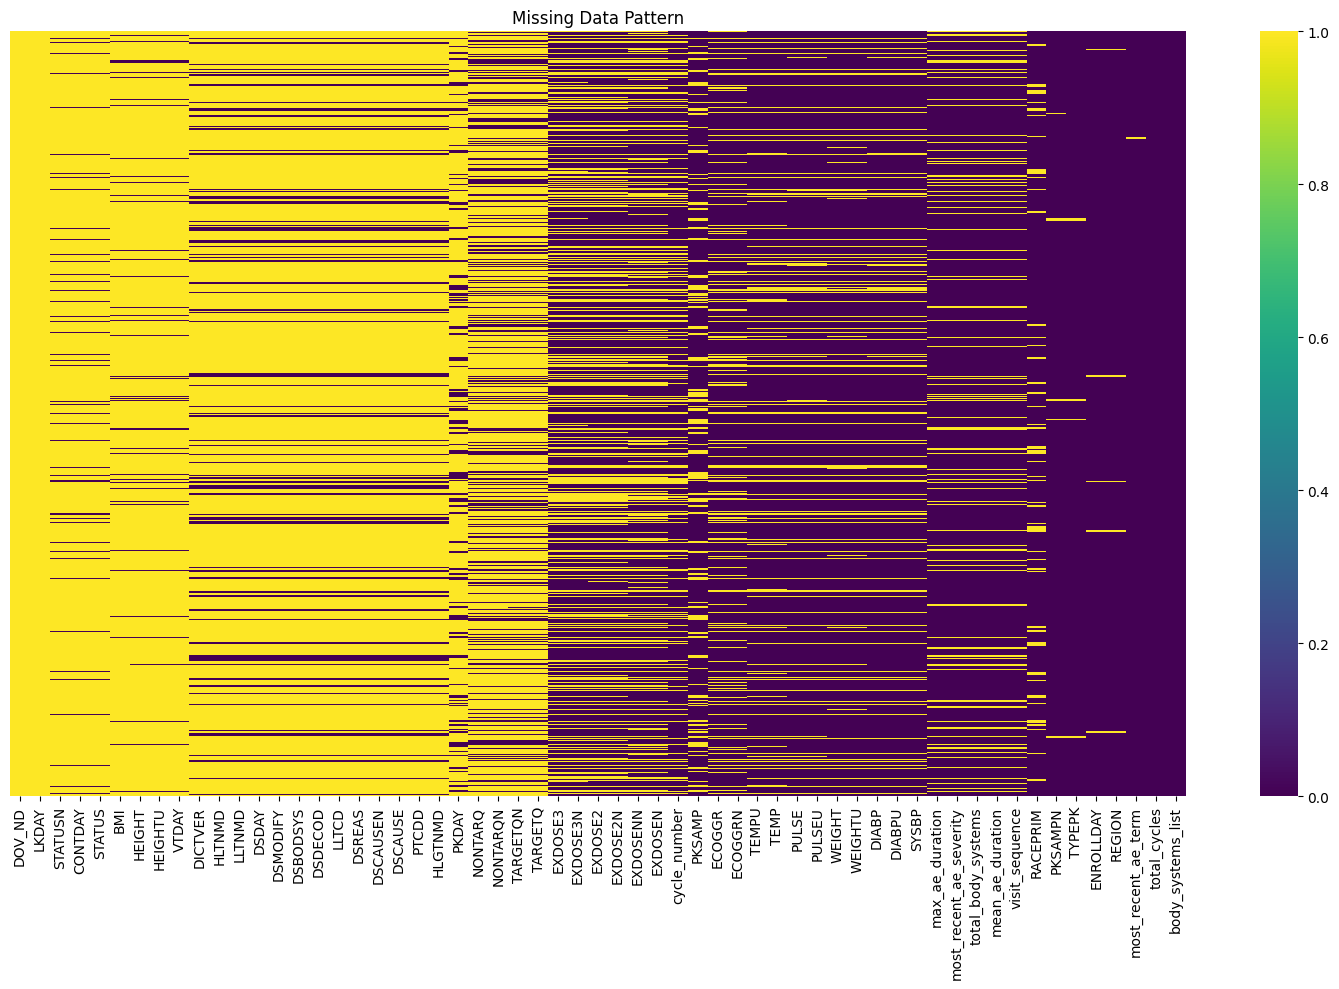

Available features: 22
Selected 22 features for modeling
Imputing missing values...
  - cycle_number: imputed 1969 missing values with median (5.00)
  - total_cycles: imputed 9 missing values with mean (11.09)
  - total_body_systems: imputed 1019 missing values with mean (5.48)
Created missing indicator: total_body_systems_missing (12.6% missing)
✓ Data quality check passed
Preprocessing complete. Final dataset: 8056 rows, 23 features
Features for modeling: ['AGE', 'VISDAY', 'cycle_number', 'total_cycles', 'anytarget', 'anynontarget', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'any_grade3_plus', 'total_body_systems', 'treatment_related_count', 'any_treatment_related', 'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count', 'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'cum_any_grade3_plus', 'cum_any_treatment_related', 'total_body_systems_missing']
Preprocessed data saved to 'pcdata_preprocessed.csv'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class SurvivalDataPreprocessor:
    def __init__(self):
        self.feature_stats = {}
        self.imputation_strategies = {}
        self.selected_features = []

    def analyze_missing_data(self, df):
        """Comprehensive analysis of missing data patterns"""
        print("=== MISSING DATA ANALYSIS ===")

        # Overall missingness
        total_rows = len(df)
        missing_summary = pd.DataFrame({
            'missing_count': df.isnull().sum(),
            'missing_percentage': (df.isnull().sum() / total_rows) * 100
        }).sort_values('missing_percentage', ascending=False)

        print("Missing data by column:")
        print(missing_summary[missing_summary['missing_count'] > 0])

        # Plot missing data heatmap
        plt.figure(figsize=(15, 10))
        missing_cols = missing_summary[missing_summary['missing_count'] > 0].index
        if len(missing_cols) > 0:
            sns.heatmap(df[missing_cols].isnull(), cbar=True, yticklabels=False, cmap='viridis')
            plt.title('Missing Data Pattern')
            plt.tight_layout()
            plt.show()

        return missing_summary

    def handle_missing_survival_data(self, df):
        """Handle missing values in survival outcomes"""
        df_clean = df.copy()

        # Check survival variables
        survival_vars = ['VISDAY', 'os_event']
        for var in survival_vars:
            if var in df.columns:
                missing_count = df[var].isnull().sum()
                if missing_count > 0:
                    print(f"WARNING: {missing_count} missing values in {var}")
                    # Remove rows with missing survival data
                    df_clean = df_clean.dropna(subset=[var])
                    print(f"Removed {missing_count} rows with missing {var}")

        return df_clean

    def select_and_impute_features(self, df, max_missing_percentage=50):
        """Select features and handle missing values with appropriate strategies"""
        # Define candidate features for survival analysis
        candidate_features = [
            # Demographic and baseline
            'AGE',

            # Treatment and cycles
            'VISDAY', 'cycle_number', 'total_cycles',

            # Tumor characteristics
            'anytarget', 'anynontarget',

            # Adverse events
            'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
            'any_grade3_plus', 'total_body_systems', 'treatment_related_count',
            'any_treatment_related', 'grade1_count', 'grade2_count',
            'grade3_count', 'grade4_count',

            # Treatment modifications
            'drug_interrupted', 'drug_reduced', 'drug_withdrawn',

            # Cumulative measures
            'cum_any_grade3_plus', 'cum_any_treatment_related'
        ]

        # Filter to available columns
        available_features = [col for col in candidate_features if col in df.columns]
        print(f"Available features: {len(available_features)}")

        # Analyze missingness for available features
        missing_stats = df[available_features].isnull().sum() / len(df) * 100
        high_missing_features = missing_stats[missing_stats > max_missing_percentage].index.tolist()

        # Remove features with too much missing data
        features_to_keep = [f for f in available_features if f not in high_missing_features]

        if high_missing_features:
            print(f"Removing {len(high_missing_features)} features with >{max_missing_percentage}% missing:")
            for feat in high_missing_features:
                print(f"  - {feat}: {missing_stats[feat]:.1f}% missing")

        print(f"Selected {len(features_to_keep)} features for modeling")

        # Determine imputation strategies
        df_subset = df[features_to_keep].copy()
        self.imputation_strategies = {}

        for feature in features_to_keep:
            if df_subset[feature].dtype in ['object', 'category']:
                # Categorical - use mode
                self.imputation_strategies[feature] = 'mode'
            else:
                # Numerical - use median for skewed data, mean for normal
                skewness = df_subset[feature].skew()
                if abs(skewness) > 1:  # Highly skewed
                    self.imputation_strategies[feature] = 'median'
                else:
                    self.imputation_strategies[feature] = 'mean'

        # Store feature statistics for imputation
        self.feature_stats = {}
        for feature in features_to_keep:
            if self.imputation_strategies[feature] == 'mode':
                self.feature_stats[feature] = df_subset[feature].mode()[0] if not df_subset[feature].mode().empty else 0
            elif self.imputation_strategies[feature] == 'median':
                self.feature_stats[feature] = df_subset[feature].median()
            else:  # mean
                self.feature_stats[feature] = df_subset[feature].mean()

        self.selected_features = features_to_keep
        return features_to_keep

    def impute_missing_values(self, df):
        """Impute missing values using predetermined strategies"""
        if not self.selected_features:
            raise ValueError("Must call select_and_impute_features first")

        df_imputed = df[self.selected_features].copy()

        print("Imputing missing values...")
        for feature in self.selected_features:
            missing_count = df_imputed[feature].isnull().sum()
            if missing_count > 0:
                imputation_value = self.feature_stats[feature]
                df_imputed[feature] = df_imputed[feature].fillna(imputation_value)
                print(f"  - {feature}: imputed {missing_count} missing values with {self.imputation_strategies[feature]} ({imputation_value:.2f})")

        return df_imputed

    def create_missing_indicators(self, df, threshold=0.05):
        """Create missing indicators for features with some but not too much missingness"""
        missing_indicators = {}
        df_with_indicators = df.copy()

        for feature in self.selected_features:
            missing_percentage = df[feature].isnull().sum() / len(df) * 100
            # Create indicator if between 1% and 20% missing
            if 1 <= missing_percentage <= 20:
                indicator_name = f"{feature}_missing"
                df_with_indicators[indicator_name] = df[feature].isnull().astype(int)
                missing_indicators[feature] = indicator_name
                print(f"Created missing indicator: {indicator_name} ({missing_percentage:.1f}% missing)")

        return df_with_indicators, missing_indicators

    def validate_data_quality(self, df):
        """Validate that data is ready for modeling"""
        issues = []

        # Check for infinite values
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        inf_count = np.isinf(df[numeric_cols]).sum().sum()
        if inf_count > 0:
            issues.append(f"Found {inf_count} infinite values")

        # Check for remaining missing values
        missing_after = df.isnull().sum().sum()
        if missing_after > 0:
            issues.append(f"Still {missing_after} missing values after imputation")

        # Check for constant columns
        constant_cols = []
        for col in numeric_cols:
            if df[col].nunique() <= 1:
                constant_cols.append(col)
        if constant_cols:
            issues.append(f"Constant columns: {constant_cols}")

        if issues:
            print("DATA QUALITY ISSUES:")
            for issue in issues:
                print(f"  - {issue}")
            return False
        else:
            print("✓ Data quality check passed")
            return True

    def preprocess_complete_pipeline(self, df):
        """Complete preprocessing pipeline"""
        print("Starting data preprocessing pipeline...")

        # Step 1: Handle survival data
        df_clean = self.handle_missing_survival_data(df)
        print(f"Data after handling missing survival outcomes: {len(df_clean)} rows")

        # Step 2: Analyze missing patterns
        missing_summary = self.analyze_missing_data(df_clean)

        # Step 3: Select features and determine imputation strategies
        features = self.select_and_impute_features(df_clean)

        # Step 4: Impute missing values
        df_imputed = self.impute_missing_values(df_clean)

        # Step 5: Optional - create missing indicators
        df_final, missing_indicators = self.create_missing_indicators(df_clean)

        # Add missing indicators to selected features if created
        if missing_indicators:
            self.selected_features.extend(missing_indicators.values())
            df_final = pd.concat([df_imputed, df_final[list(missing_indicators.values())]], axis=1)
        else:
            df_final = df_imputed

        # Step 6: Add back survival variables
        survival_vars = ['VISDAY', 'os_event']
        for var in survival_vars:
            if var in df_clean.columns:
                df_final[var] = df_clean[var].values

        # Step 7: Validate data quality
        self.validate_data_quality(df_final)

        print(f"Preprocessing complete. Final dataset: {len(df_final)} rows, {len(self.selected_features)} features")

        return df_final

# Usage example:
def preprocess_your_data():
    # Load your data
    pcdata = pd.read_csv('pcdata.csv')  # Replace with your actual data loading

    # Initialize preprocessor
    preprocessor = SurvivalDataPreprocessor()

    # Run complete preprocessing pipeline
    pcdata_clean = preprocessor.preprocess_complete_pipeline(pcdata)

    # You can now access the selected features
    print(f"Features for modeling: {preprocessor.selected_features}")

    # Save preprocessed data if needed
    pcdata_clean.to_csv('pcdata_preprocessed.csv', index=False)
    print("Preprocessed data saved to 'pcdata_preprocessed.csv'")

    return pcdata_clean, preprocessor

# Run the preprocessing
if __name__ == "__main__":
    pcdata_clean, preprocessor = preprocess_your_data()

## Deep Survival Network

Data loaded: (8056, 24)
Training model...
Using 21 features: ['AGE', 'cycle_number', 'total_cycles', 'anytarget', 'anynontarget', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'any_grade3_plus', 'total_body_systems', 'treatment_related_count', 'any_treatment_related', 'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count', 'cum_any_grade3_plus', 'cum_any_treatment_related']
Survival data: 8056 samples, 1084 events (0.135 event rate)
Training on 8056 samples with 21 features
Event rate: 0.135
Starting training...
Epoch   0: Train Loss = 2.4647, Val Loss = 2.2132, C-index = 0.8569, LR = 0.000500
Epoch  10: Train Loss = 1.6327, Val Loss = 1.4448, C-index = 0.9057, LR = 0.000500
Epoch  20: Train Loss = 1.4809, Val Loss = 1.2735, C-index = 0.9205, LR = 0.000500
Epoch  30: Train Loss = 1.3441, Val Loss = 1.1825, C-index = 0.9263, LR = 0.000500
Epoch  40: Train Loss = 1.3205, Val Loss = 1.1197, C-index = 0.9303, LR = 

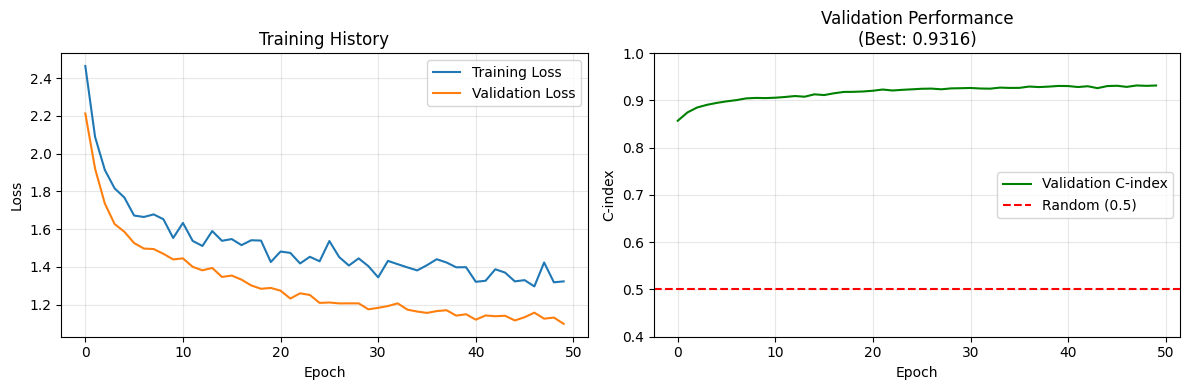

Using 21 features: ['AGE', 'cycle_number', 'total_cycles', 'anytarget', 'anynontarget', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'any_grade3_plus', 'total_body_systems', 'treatment_related_count', 'any_treatment_related', 'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count', 'cum_any_grade3_plus', 'cum_any_treatment_related']

Risk scores shape: (8056, 1)
Risk scores range: -25.180 to 2.651
Risk scores mean: -4.648 ± 5.327

Final validation C-index: 0.9315
Best validation C-index: 0.9316


In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
import warnings
warnings.filterwarnings('ignore')

class CorrectedSurvivalDataset(Dataset):
    def __init__(self, features, times, events):
        self.features = torch.FloatTensor(features)
        self.times = torch.FloatTensor(times)
        self.events = torch.FloatTensor(events)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.times[idx], self.events[idx]

class RobustDeepSurvivalNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32, 16], dropout_rate=0.2):
        super(RobustDeepSurvivalNetwork, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim

        self.feature_network = nn.Sequential(*layers)

        # Output layer with proper initialization
        self.hazard = nn.Linear(prev_dim, 1)

        # Initialize with small weights to prevent explosion
        nn.init.normal_(self.hazard.weight, mean=0, std=0.01)
        nn.init.constant_(self.hazard.bias, 0)

    def forward(self, x):
        features = self.feature_network(x)
        # No activation - let the network learn unbounded log hazard
        hazard = self.hazard(features)
        return hazard

class RobustDeepSurvivalModel:
    def __init__(self, hidden_dims=[64, 32, 16], dropout_rate=0.2, learning_rate=0.0005):
        self.hidden_dims = hidden_dims
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.feature_names = []
        self.best_c_index = 0.0

    def prepare_features(self, df, exclude_visday=True):
        """Prepare features excluding VISDAY to prevent data leakage"""
        feature_columns = [
            'AGE', 'cycle_number', 'total_cycles', 'anytarget',
            'anynontarget', 'total_ae_events', 'serious_ae_count',
            'grade3_plus_count', 'any_grade3_plus', 'total_body_systems',
            'treatment_related_count', 'any_treatment_related',
            'drug_interrupted', 'drug_reduced', 'drug_withdrawn',
            'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count',
            'cum_any_grade3_plus', 'cum_any_treatment_related'
        ]

        # Filter to available columns
        available_features = [col for col in feature_columns if col in df.columns]
        print(f"Using {len(available_features)} features: {available_features}")

        X = df[available_features].copy()
        self.feature_names = available_features

        # Handle categorical variables
        categorical_cols = X.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            X[col] = LabelEncoder().fit_transform(X[col].astype(str))

        # Convert to numeric and handle non-numeric values
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')

        # Impute missing values
        X_imputed = self.imputer.fit_transform(X)

        # Scale features
        X_scaled = self.scaler.fit_transform(X_imputed)

        return X_scaled

    def prepare_survival_data(self, df):
        """Prepare survival time and event data"""
        if 'VISDAY' in df.columns and 'os_event' in df.columns:
            times = df['VISDAY'].values
            events = df['os_event'].values
        else:
            raise ValueError("Required survival columns 'VISDAY' and 'os_event' not found")

        print(f"Survival data: {len(times)} samples, {events.sum()} events ({events.mean():.3f} event rate)")
        return times, events

    def robust_cox_loss(self, hazard, times, events):
        """
        Robust Cox partial likelihood implementation
        Based on pycox's implementation for stability
        """
        if len(times) == 0:
            return torch.tensor(0.0)

        # Sort by time (descending)
        _, sort_idx = torch.sort(times, descending=True)
        hazard_sorted = hazard[sort_idx]
        events_sorted = events[sort_idx]

        # Apply log-sum-exp trick for numerical stability
        hazard_max = torch.max(hazard_sorted)
        hazard_shifted = hazard_sorted - hazard_max

        # Calculate cumulative sum of exp(hazard)
        exp_hazard = torch.exp(hazard_shifted)
        cumulative_hazard = torch.cumsum(exp_hazard, dim=0)

        # Log of cumulative hazard with stability
        log_cumulative_hazard = torch.log(cumulative_hazard) + hazard_max

        # Calculate log likelihood for events
        log_likelihood = torch.sum((hazard_sorted - log_cumulative_hazard) * events_sorted)

        # Normalize by number of events
        n_events = torch.sum(events_sorted)
        if n_events > 0:
            avg_log_likelihood = log_likelihood / n_events
        else:
            avg_log_likelihood = log_likelihood

        # Return negative log likelihood (should be positive)
        loss = -avg_log_likelihood

        # Clamp loss to prevent extreme values
        return torch.clamp(loss, min=0.0, max=100.0)

    def calculate_concordance_index(self, hazard, times, events):
        """Calculate concordance index"""
        if len(np.unique(events)) < 2:
            return 0.5

        try:
            hazard_np = hazard.detach().cpu().numpy().ravel()
            times_np = times.cpu().numpy() if isinstance(times, torch.Tensor) else times
            events_np = events.cpu().numpy() if isinstance(events, torch.Tensor) else events

            c_index = concordance_index(
                event_times=times_np,
                event_observed=events_np,
                predicted_scores=-hazard_np  # Higher hazard = higher risk
            )
            return c_index
        except Exception as e:
            print(f"Error calculating C-index: {e}")
            return 0.5

    def train(self, df, epochs=100, batch_size=32, validation_split=0.2, patience=10):
        """Train with robust monitoring"""

        # Prepare data - EXCLUDE VISDAY from features to prevent data leakage
        X = self.prepare_features(df, exclude_visday=True)
        times, events = self.prepare_survival_data(df)

        print(f"Training on {len(X)} samples with {X.shape[1]} features")
        print(f"Event rate: {events.mean():.3f}")

        # Split data
        X_train, X_val, times_train, times_val, events_train, events_val = train_test_split(
            X, times, events, test_size=validation_split, random_state=42, stratify=events
        )

        # Create datasets
        train_dataset = CorrectedSurvivalDataset(X_train, times_train, events_train)
        val_dataset = CorrectedSurvivalDataset(X_val, times_val, events_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        self.model = RobustDeepSurvivalNetwork(
            input_dim=X.shape[1],
            hidden_dims=self.hidden_dims,
            dropout_rate=self.dropout_rate
        ).to(self.device)

        # Optimizer with lower learning rate
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

        # Training history
        train_losses = []
        val_losses = []
        val_c_indices = []

        best_c_index = 0.0
        best_model_state = None
        patience_counter = 0

        print("Starting training...")
        for epoch in range(epochs):
            # Training
            self.model.train()
            train_loss = 0.0
            for batch_X, batch_times, batch_events in train_loader:
                batch_X = batch_X.to(self.device)
                batch_times = batch_times.to(self.device)
                batch_events = batch_events.to(self.device)

                optimizer.zero_grad()
                hazard = self.model(batch_X).squeeze()
                loss = self.robust_cox_loss(hazard, batch_times, batch_events)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()

                train_loss += loss.item()

            # Validation
            self.model.eval()
            val_loss = 0.0
            all_hazards = []
            all_times = []
            all_events = []

            with torch.no_grad():
                for batch_X, batch_times, batch_events in val_loader:
                    batch_X = batch_X.to(self.device)
                    batch_times_val = batch_times.to(self.device)
                    batch_events_val = batch_events.to(self.device)

                    hazard = self.model(batch_X).squeeze()
                    loss = self.robust_cox_loss(hazard, batch_times_val, batch_events_val)
                    val_loss += loss.item()

                    all_hazards.append(hazard)
                    all_times.append(batch_times_val)
                    all_events.append(batch_events_val)

            # Calculate metrics
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)

            if all_hazards:
                all_hazards = torch.cat(all_hazards)
                all_times = torch.cat(all_times)
                all_events = torch.cat(all_events)

                c_index = self.calculate_concordance_index(all_hazards, all_times, all_events)
            else:
                c_index = 0.5

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            val_c_indices.append(c_index)

            # Learning rate scheduling
            scheduler.step(avg_val_loss)

            # Early stopping
            if c_index > best_c_index:
                best_c_index = c_index
                best_model_state = self.model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            if epoch % 10 == 0 or epoch == epochs - 1:
                current_lr = optimizer.param_groups[0]['lr']
                print(f'Epoch {epoch:3d}: Train Loss = {avg_train_loss:.4f}, '
                      f'Val Loss = {avg_val_loss:.4f}, C-index = {c_index:.4f}, '
                      f'LR = {current_lr:.6f}')

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # Load best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            self.best_c_index = best_c_index
            print(f"Loaded best model with C-index: {best_c_index:.4f}")

        # Plot results
        self.plot_training_history(train_losses, val_losses, val_c_indices)

        return train_losses, val_losses, val_c_indices

    def predict_risk(self, df):
        """Predict risk scores"""
        if self.model is None:
            raise ValueError("Model must be trained before prediction")

        self.model.eval()
        X = self.prepare_features(df, exclude_visday=True)

        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            risk_scores = self.model(X_tensor).cpu().numpy()

        return risk_scores

    def plot_training_history(self, train_losses, val_losses, val_c_indices):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        epochs_range = range(len(train_losses))

        # Plot losses
        ax1.plot(epochs_range, train_losses, label='Training Loss')
        ax1.plot(epochs_range, val_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training History')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot C-index
        ax2.plot(epochs_range, val_c_indices, label='Validation C-index', color='green')
        ax2.axhline(y=0.5, color='red', linestyle='--', label='Random (0.5)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('C-index')
        ax2.set_title(f'Validation Performance\n(Best: {max(val_c_indices):.4f})')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0.4, 1.0)

        plt.tight_layout()
        plt.show()

# Final corrected main function
def main():
    # Load your data
    pcdata = pd.read_csv('pcdata_preprocessed.csv')
    print(f"Data loaded: {pcdata.shape}")

    # Initialize corrected model
    dsnmodel = RobustDeepSurvivalModel(
        hidden_dims=[64, 32, 16],
        dropout_rate=0.2,
        learning_rate=0.0005  # Lower learning rate for stability
    )

    # Train the model
    print("Training model...")
    train_losses, val_losses, val_c_indices = dsnmodel.train(
        pcdata,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        patience=8
    )

    # Make predictions
    risk_scores = dsnmodel.predict_risk(pcdata)
    print(f"\nRisk scores shape: {risk_scores.shape}")
    print(f"Risk scores range: {risk_scores.min():.3f} to {risk_scores.max():.3f}")
    print(f"Risk scores mean: {risk_scores.mean():.3f} ± {risk_scores.std():.3f}")

    # Calculate final performance
    final_c_index = val_c_indices[-1] if val_c_indices else 0.5
    print(f"\nFinal validation C-index: {final_c_index:.4f}")
    print(f"Best validation C-index: {dsnmodel.best_c_index:.4f}")

if __name__ == "__main__":
    main()

## Random Survival Forest

Initial data check:
Total rows: 8056
NaN in VISDAY: 0
NaN in os_event: 0
VISDAY range: [-199.00, 750.00]
After cleaning survival data: 8034 samples, 1082 events
Using 22 features: ['AGE', 'VISDAY', 'cycle_number', 'total_cycles', 'anytarget', 'anynontarget', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'any_grade3_plus', 'total_body_systems', 'treatment_related_count', 'any_treatment_related', 'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count', 'cum_any_grade3_plus', 'cum_any_treatment_related']
Training on 8034 samples with 22 features
Event rate: 0.135
Training set: 5141 samples
Validation set: 1286 samples
Test set: 1607 samples
Training Random Survival Forest...
Building 50 trees...
  Built 20/50 trees
  Built 40/50 trees
Train C-index: 0.9102
Validation C-index: 0.9025
Test C-index: 0.9039
OOB C-index: 0.8789200112096188


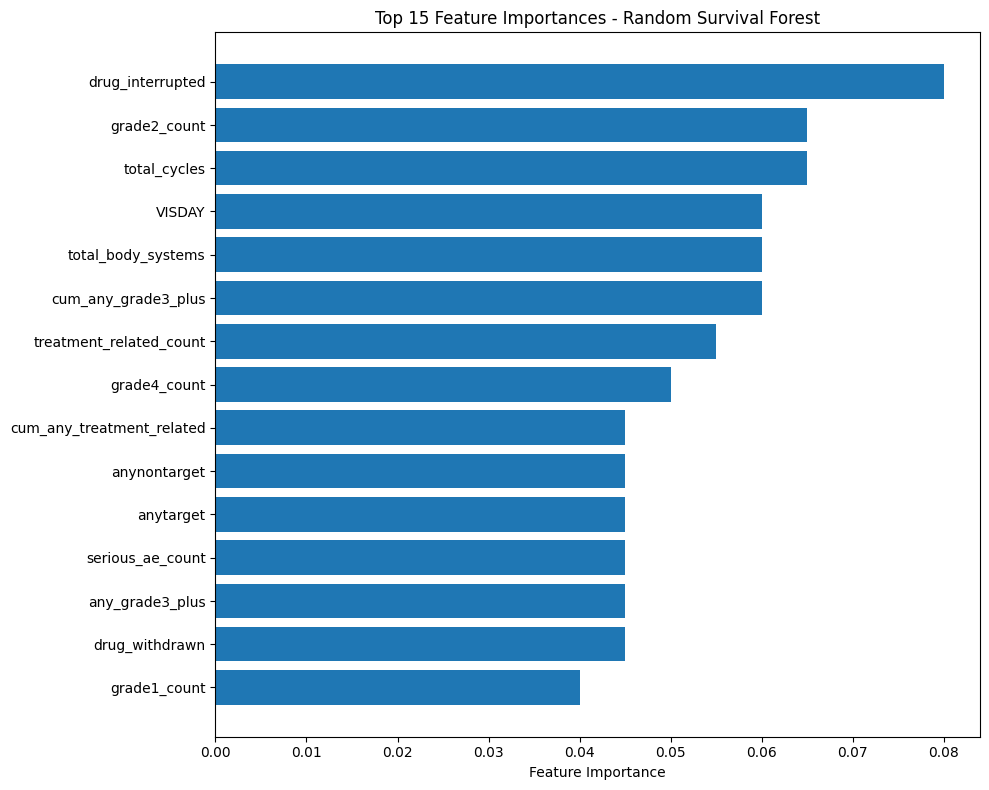


Top feature importances:
grade1_count: 0.0400
drug_withdrawn: 0.0450
any_grade3_plus: 0.0450
serious_ae_count: 0.0450
anytarget: 0.0450
anynontarget: 0.0450
cum_any_treatment_related: 0.0450
grade4_count: 0.0500
treatment_related_count: 0.0550
cum_any_grade3_plus: 0.0600
total_body_systems: 0.0600
VISDAY: 0.0600
total_cycles: 0.0650
grade2_count: 0.0650
drug_interrupted: 0.0800


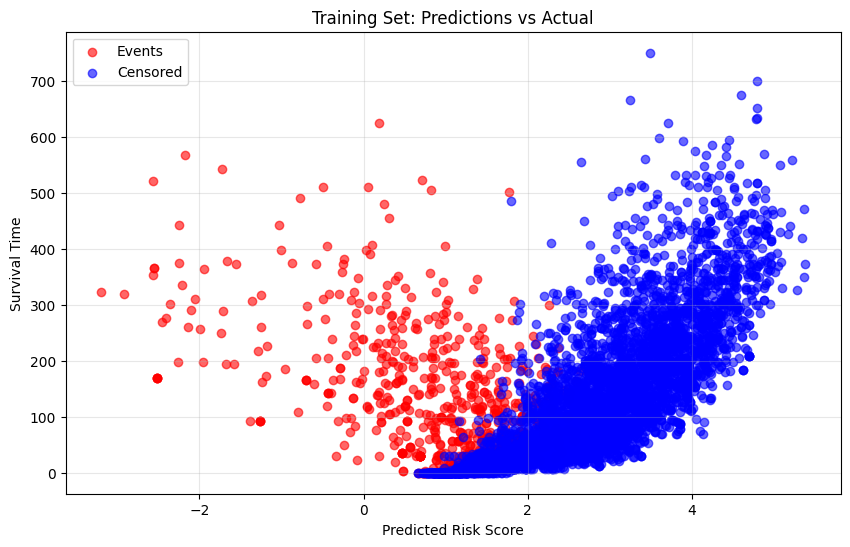

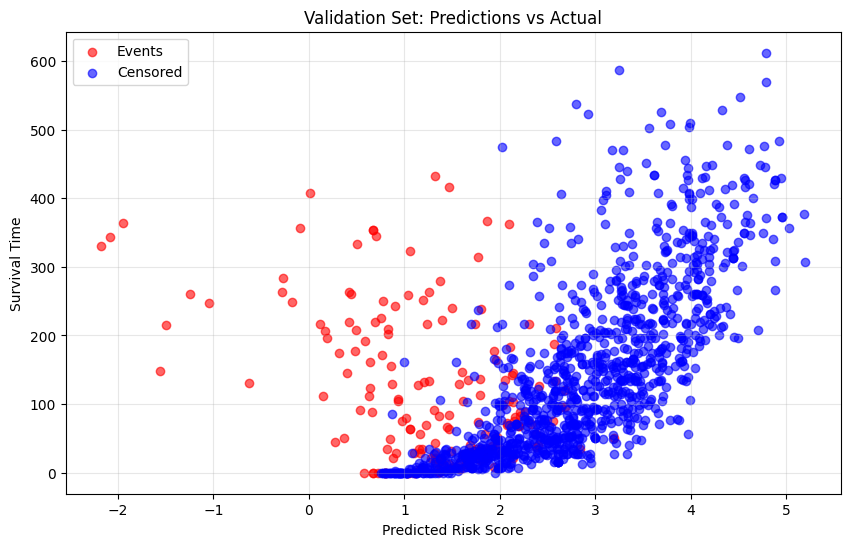

Using 22 features: ['AGE', 'VISDAY', 'cycle_number', 'total_cycles', 'anytarget', 'anynontarget', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'any_grade3_plus', 'total_body_systems', 'treatment_related_count', 'any_treatment_related', 'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count', 'cum_any_grade3_plus', 'cum_any_treatment_related']
Risk scores shape: (8056,)
Risk scores range: -3.199 to 5.393

Model summary:
n_estimators: 50
max_depth: 10
min_samples_split: 6
min_samples_leaf: 3
max_features: sqrt
n_trees: 50

Final test C-index: 0.9039


In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

class RandomSurvivalTree:
    def __init__(self, max_depth=None, min_samples_split=6, min_samples_leaf=3, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.tree = None
        self.feature_indices = None

    def fit(self, X, y, features):
        """Fit a single survival tree"""
        times, events = y['time'], y['event']
        self.feature_indices = features

        # Create RandomForestRegressor for survival data
        self.tree = RandomForestRegressor(
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            max_features=self.max_features,
            n_estimators=1,  # Single tree
            random_state=np.random.randint(1000)
        )

        # Create target: for events, use negative log time (higher risk = shorter survival)
        # For censored, use positive log time (lower risk = longer survival)
        target = np.zeros_like(times, dtype=float)

        # For events: negative value (shorter survival = higher risk)
        event_mask = events.astype(bool)
        target[event_mask] = -np.log1p(times[event_mask])  # Negative for events

        # For censored: positive value (longer survival = lower risk)
        censored_mask = ~event_mask
        target[censored_mask] = np.log1p(times[censored_mask])  # Positive for censored

        # Give more weight to events
        weights = np.where(events, 2.0, 1.0)

        # Remove any infinite or NaN values
        valid_mask = np.isfinite(target)
        if not np.all(valid_mask):
            print(f"Warning: Removing {np.sum(~valid_mask)} samples with invalid target values")
            X = X[valid_mask]
            target = target[valid_mask]
            weights = weights[valid_mask]

        self.tree.fit(X[:, features], target, sample_weight=weights)
        return self

    def predict(self, X):
        """Predict risk scores (higher = higher risk)"""
        if self.tree is None:
            raise ValueError("Tree not fitted")
        return self.tree.predict(X[:, self.feature_indices])

class RandomSurvivalForest:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=6,
                 min_samples_leaf=3, max_features='sqrt', random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_importances_ = None
        self.oob_score_ = None

    def fit(self, X, y):
        """Fit the random survival forest"""
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Determine max_features
        if self.max_features == 'sqrt':
            max_features = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            max_features = int(np.log2(n_features))
        else:
            max_features = n_features

        # Initialize feature importance
        feature_importance = np.zeros(n_features)
        oob_predictions = [[] for _ in range(n_samples)]
        oob_counts = np.zeros(n_samples)

        print(f"Building {self.n_estimators} trees...")
        # Build trees
        for i in range(self.n_estimators):
            if (i + 1) % 20 == 0:
                print(f"  Built {i + 1}/{self.n_estimators} trees")

            # Bootstrap sample
            bootstrap_indices = resample(range(n_samples), random_state=self.random_state + i)
            oob_indices = np.setdiff1d(range(n_samples), bootstrap_indices)

            # Select random features
            feature_indices = np.random.choice(n_features, max_features, replace=False)

            # Create and fit tree
            tree = RandomSurvivalTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=None
            )

            tree.fit(X[bootstrap_indices], {
                'time': y['time'][bootstrap_indices],
                'event': y['event'][bootstrap_indices]
            }, feature_indices)

            self.trees.append((tree, feature_indices))

            # OOB predictions and feature importance
            if len(oob_indices) > 0:
                oob_pred = tree.predict(X[oob_indices])
                for idx, pred in zip(oob_indices, oob_pred):
                    oob_predictions[idx].append(pred)
                    oob_counts[idx] += 1

                # Update feature importance (simplified)
                for feat_idx in feature_indices:
                    feature_importance[feat_idx] += 1

        # Calculate OOB score
        valid_oob_indices = oob_counts > 0
        if np.any(valid_oob_indices):
            oob_avg_preds = np.array([np.mean(preds) if preds else 0
                                    for preds in oob_predictions])
            valid_preds = oob_avg_preds[valid_oob_indices]
            valid_times = y['time'][valid_oob_indices]
            valid_events = y['event'][valid_oob_indices]

            try:
                self.oob_score_ = concordance_index(
                    event_times=valid_times,
                    event_observed=valid_events,
                    predicted_scores=valid_preds
                )
            except Exception as e:
                print(f"Could not calculate OOB score: {e}")
                self.oob_score_ = 0.5

        # Normalize feature importance
        if np.sum(feature_importance) > 0:
            self.feature_importances_ = feature_importance / np.sum(feature_importance)
        else:
            self.feature_importances_ = np.ones(n_features) / n_features

        return self

    def predict(self, X):
        """Predict risk scores (higher = higher risk)"""
        if not self.trees:
            raise ValueError("Forest not fitted")

        predictions = np.zeros(len(X))
        for tree, _ in self.trees:
            predictions += tree.predict(X)

        return predictions / len(self.trees)

class RandomSurvivalForestModel:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=6,
                 min_samples_leaf=3, max_features='sqrt', random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.model = None
        self.feature_names = []

    def prepare_features(self, df):
        """Prepare features for survival analysis"""
        # Select relevant features based on your data structure
        feature_columns = [
            'AGE', 'VISDAY', 'cycle_number', 'total_cycles', 'anytarget',
            'anynontarget', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
            'any_grade3_plus', 'total_body_systems', 'treatment_related_count',
            'any_treatment_related', 'drug_interrupted', 'drug_reduced', 'drug_withdrawn',
            'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count',
            'cum_any_grade3_plus', 'cum_any_treatment_related'
        ]

        # Filter to available columns
        available_features = [col for col in feature_columns if col in df.columns]
        print(f"Using {len(available_features)} features: {available_features}")

        # Extract features
        X = df[available_features].copy()
        self.feature_names = available_features

        # Handle categorical variables
        categorical_cols = X.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            X[col] = LabelEncoder().fit_transform(X[col].astype(str))

        # Convert to numeric and handle any remaining non-numeric values
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')

        # Check for any remaining NaN values and impute
        if X.isnull().any().any():
            print(f"Imputing {X.isnull().sum().sum()} missing values in features")
            X_imputed = self.imputer.fit_transform(X)
        else:
            X_imputed = X.values

        # Scale features
        X_scaled = self.scaler.fit_transform(X_imputed)

        # Check for any infinite values
        if not np.all(np.isfinite(X_scaled)):
            print("Warning: Found infinite values in features, replacing with 0")
            X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

        return X_scaled

    def prepare_survival_data(self, df):
        """Prepare survival time and event data with proper NaN handling"""
        # Use VISDAY as time and os_event as event indicator
        if 'VISDAY' in df.columns and 'os_event' in df.columns:
            # Remove rows where survival data is missing or invalid
            survival_mask = (
                df['VISDAY'].notna() &
                df['os_event'].notna() &
                (df['VISDAY'] >= 0)  # Time should be non-negative
            )
            df_clean = df[survival_mask].copy()

            times = df_clean['VISDAY'].values
            events = df_clean['os_event'].values

            print(f"After cleaning survival data: {len(times)} samples, {events.sum()} events")

            # Check for any invalid values
            if np.any(times < 0):
                print("Warning: Found negative times, setting to 0")
                times = np.maximum(times, 0)
        else:
            raise ValueError("Required survival columns 'VISDAY' and 'os_event' not found in data")

        # Create structured array for consistency
        y = np.empty(len(times), dtype=[('event', '?'), ('time', '<f8')])
        y['event'] = events.astype(bool)
        y['time'] = times

        return y, df_clean

    def calculate_concordance_index(self, predictions, times, events):
        """Calculate concordance index for model evaluation"""
        if len(np.unique(events)) < 2:
            print("Warning: Not enough events to calculate C-index")
            return 0.5

        try:
            c_index = concordance_index(
                event_times=times,
                event_observed=events,
                predicted_scores=predictions
            )
            return c_index
        except Exception as e:
            print(f"Error calculating C-index: {e}")
            return 0.5

    def train(self, df, validation_split=0.2, test_size=0.2):
        """Train the Random Survival Forest model"""

        # Prepare survival data first (this handles NaN removal)
        y, df_clean = self.prepare_survival_data(df)

        # Now prepare features using the cleaned dataframe
        X = self.prepare_features(df_clean)

        print(f"Training on {len(X)} samples with {X.shape[1]} features")
        print(f"Event rate: {y['event'].mean():.3f}")

        # Split data into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state,
            stratify=y['event']
        )

        # Further split train into train and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=validation_split,
            random_state=self.random_state, stratify=y_train['event']
        )

        print(f"Training set: {len(X_train)} samples")
        print(f"Validation set: {len(X_val)} samples")
        print(f"Test set: {len(X_test)} samples")

        # Initialize and train Random Survival Forest
        self.model = RandomSurvivalForest(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            max_features=self.max_features,
            random_state=self.random_state
        )

        print("Training Random Survival Forest...")
        self.model.fit(X_train, y_train)

        # Evaluate on all sets
        train_predictions = self.model.predict(X_train)
        val_predictions = self.model.predict(X_val)
        test_predictions = self.model.predict(X_test)

        train_score = self.calculate_concordance_index(train_predictions, y_train['time'], y_train['event'])
        val_score = self.calculate_concordance_index(val_predictions, y_val['time'], y_val['event'])
        test_score = self.calculate_concordance_index(test_predictions, y_test['time'], y_test['event'])
        oob_score = self.model.oob_score_ if hasattr(self.model, 'oob_score_') else "N/A"

        print(f"Train C-index: {train_score:.4f}")
        print(f"Validation C-index: {val_score:.4f}")
        print(f"Test C-index: {test_score:.4f}")
        print(f"OOB C-index: {oob_score}")

        # Calculate feature importance
        if hasattr(self.model, 'feature_importances_'):
            self.plot_feature_importance(self.model.feature_importances_)

        # Plot predictions vs actual
        self.plot_predictions_vs_actual(train_predictions, y_train['time'], y_train['event'], "Training")
        self.plot_predictions_vs_actual(val_predictions, y_val['time'], y_val['event'], "Validation")

        return train_score, val_score, test_score

    def predict_risk(self, df):
        """Predict risk scores for new data (higher = higher risk)"""
        if self.model is None:
            raise ValueError("Model must be trained before prediction")

        X = self.prepare_features(df)
        risk_scores = self.model.predict(X)

        return risk_scores

    def plot_feature_importance(self, feature_importance, top_k=15):
        """Plot feature importance"""
        if len(feature_importance) == 0:
            print("No feature importance available")
            return

        # Create feature importance dataframe
        importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': feature_importance
        })

        # Sort by importance and take top k
        importance_df = importance_df.sort_values('importance', ascending=True).tail(top_k)

        # Plot
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(importance_df)), importance_df['importance'])
        plt.yticks(range(len(importance_df)), importance_df['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top {top_k} Feature Importances - Random Survival Forest')
        plt.tight_layout()
        plt.show()

        # Print top features
        print("\nTop feature importances:")
        for i, row in importance_df.iterrows():
            print(f"{row['feature']}: {row['importance']:.4f}")

    def plot_predictions_vs_actual(self, predictions, times, events, title):
        """Plot predictions vs actual outcomes"""
        plt.figure(figsize=(10, 6))

        # Color by event status
        event_mask = events.astype(bool)
        plt.scatter(predictions[event_mask], times[event_mask], c='red', alpha=0.6, label='Events')
        plt.scatter(predictions[~event_mask], times[~event_mask], c='blue', alpha=0.6, label='Censored')

        plt.xlabel('Predicted Risk Score')
        plt.ylabel('Survival Time')
        plt.title(f'{title} Set: Predictions vs Actual')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def get_model_summary(self):
        """Get model summary"""
        if self.model is None:
            return "Model not trained yet"

        summary = {
            'n_estimators': self.n_estimators,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'max_features': self.max_features,
            'n_trees': len(self.model.trees) if hasattr(self.model, 'trees') else 0
        }

        return summary

# Fixed main function
def main():
    # Load your data
    pcdata = pd.read_csv('pcdata_preprocessed.csv')

    # Check for NaN values in survival data before starting
    print("Initial data check:")
    print(f"Total rows: {len(pcdata)}")
    print(f"NaN in VISDAY: {pcdata['VISDAY'].isna().sum()}")
    print(f"NaN in os_event: {pcdata['os_event'].isna().sum()}")
    print(f"VISDAY range: [{pcdata['VISDAY'].min():.2f}, {pcdata['VISDAY'].max():.2f}]")

    # Initialize and train model
    rsf = RandomSurvivalForestModel(
        n_estimators=50,  # Reduced for faster testing
        max_depth=10,
        min_samples_split=6,
        min_samples_leaf=3,
        max_features='sqrt',
        random_state=42
    )

    # Train the model
    train_score, val_score, test_score = rsf.train(
        pcdata,
        validation_split=0.2,
        test_size=0.2
    )

    # Make predictions
    risk_scores = rsf.predict_risk(pcdata)
    print(f"Risk scores shape: {risk_scores.shape}")
    print(f"Risk scores range: {risk_scores.min():.3f} to {risk_scores.max():.3f}")

    # Get model summary
    summary = rsf.get_model_summary()
    print("\nModel summary:")
    for key, value in summary.items():
        print(f"{key}: {value}")

    print(f"\nFinal test C-index: {test_score:.4f}")

if __name__ == "__main__":
    main()

Initial data check:
Total rows: 8056
NaN in VISDAY: 0
NaN in os_event: 0
Cross-validation on 8034 samples with 22 features
Event rate: 0.135

Performing 5-fold cross-validation...

--- Fold 1/5 ---
Train: 5141 samples (0.135 event rate)
Val: 1286 samples (0.135 event rate)
Train C-index: 0.9132
Val C-index: 0.8957
Test C-index: 0.9004

--- Fold 2/5 ---
Train: 5141 samples (0.135 event rate)
Val: 1286 samples (0.135 event rate)
Train C-index: 0.9030
Val C-index: 0.8861
Test C-index: 0.8914

--- Fold 3/5 ---
Train: 5142 samples (0.135 event rate)
Val: 1285 samples (0.135 event rate)
Train C-index: 0.9152
Val C-index: 0.9099
Test C-index: 0.9054

--- Fold 4/5 ---
Train: 5142 samples (0.135 event rate)
Val: 1285 samples (0.135 event rate)
Train C-index: 0.9090
Val C-index: 0.8950
Test C-index: 0.8998

--- Fold 5/5 ---
Train: 5142 samples (0.135 event rate)
Val: 1285 samples (0.135 event rate)
Train C-index: 0.9133
Val C-index: 0.9045
Test C-index: 0.9020

CROSS-VALIDATION SUMMARY

Train C-

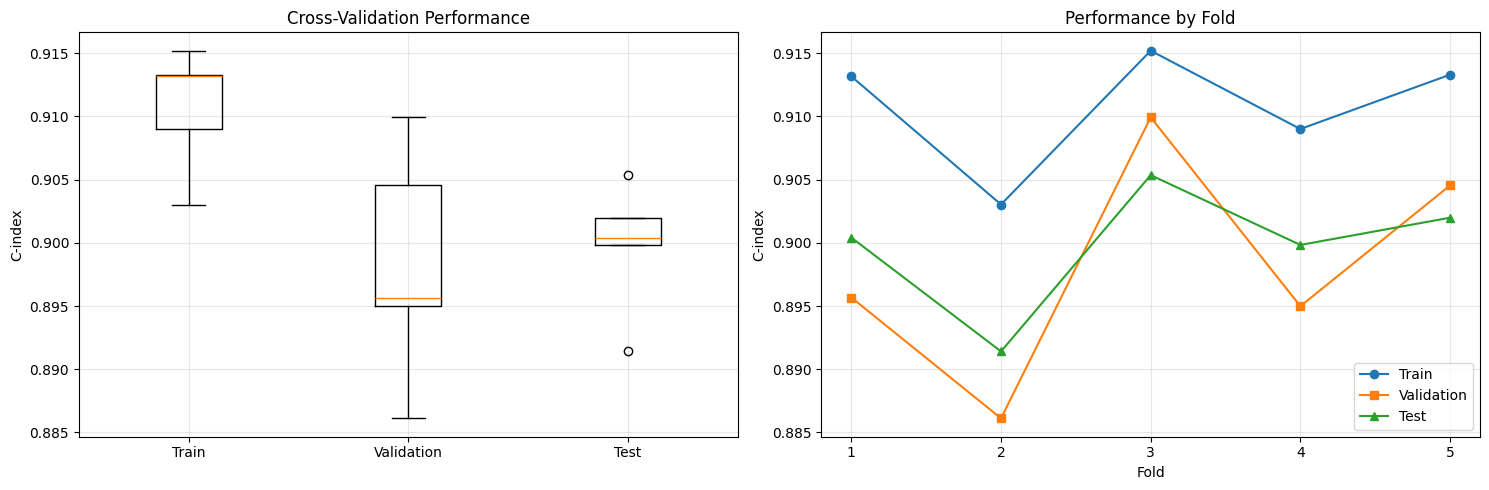

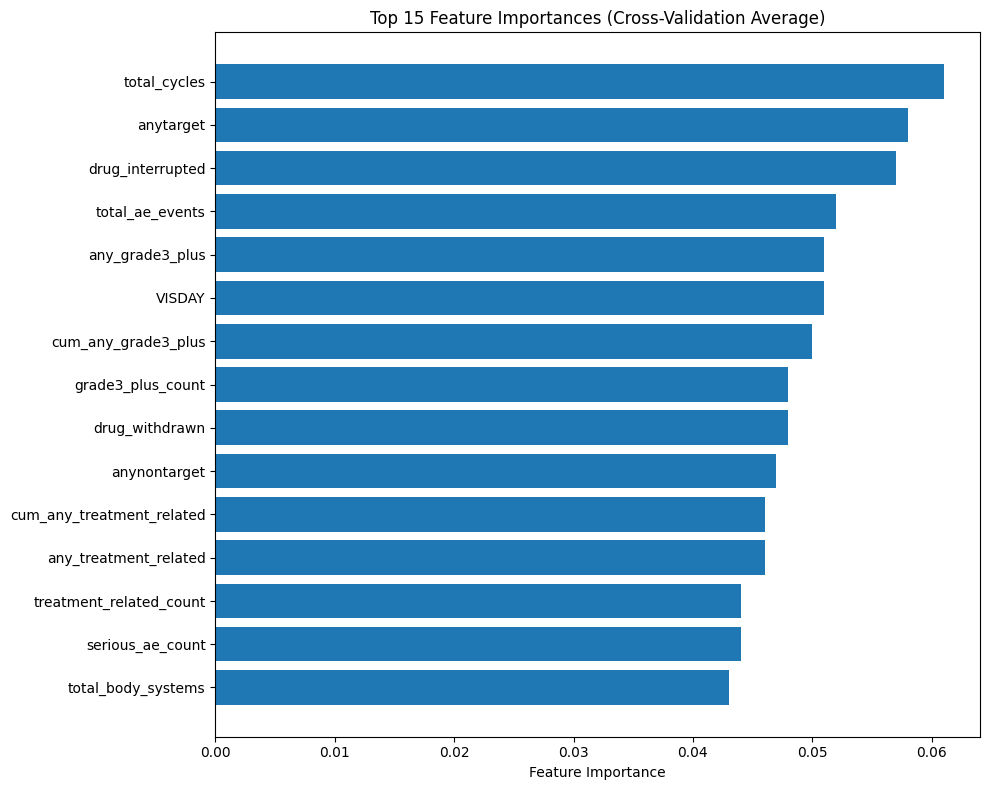


Top feature importances (average across folds):
total_body_systems: 0.0430
serious_ae_count: 0.0440
treatment_related_count: 0.0440
any_treatment_related: 0.0460
cum_any_treatment_related: 0.0460
anynontarget: 0.0470
drug_withdrawn: 0.0480
grade3_plus_count: 0.0480
cum_any_grade3_plus: 0.0500
VISDAY: 0.0510
any_grade3_plus: 0.0510
total_ae_events: 0.0520
drug_interrupted: 0.0570
anytarget: 0.0580
total_cycles: 0.0610

Risk scores shape: (8056,)
Risk scores range: -3.320 to 5.409

Model summary:
n_estimators: 50
max_depth: 10
min_samples_split: 6
min_samples_leaf: 3
max_features: sqrt
n_trees: 50
cv_avg_test_score: 0.899801719464023


In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.utils import resample
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

class RandomSurvivalTree:
    def __init__(self, max_depth=None, min_samples_split=6, min_samples_leaf=3, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.tree = None
        self.feature_indices = None

    def fit(self, X, y, features):
        """Fit a single survival tree"""
        times, events = y['time'], y['event']
        self.feature_indices = features

        # Create RandomForestRegressor for survival data
        self.tree = RandomForestRegressor(
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            max_features=self.max_features,
            n_estimators=1,  # Single tree
            random_state=np.random.randint(1000)
        )

        # Create target: for events, use negative log time (higher risk = shorter survival)
        # For censored, use positive log time (lower risk = longer survival)
        target = np.zeros_like(times, dtype=float)

        # For events: negative value (shorter survival = higher risk)
        event_mask = events.astype(bool)
        target[event_mask] = -np.log1p(times[event_mask])  # Negative for events

        # For censored: positive value (longer survival = lower risk)
        censored_mask = ~event_mask
        target[censored_mask] = np.log1p(times[censored_mask])  # Positive for censored

        # Give more weight to events
        weights = np.where(events, 2.0, 1.0)

        # Remove any infinite or NaN values
        valid_mask = np.isfinite(target)
        if not np.all(valid_mask):
            print(f"Warning: Removing {np.sum(~valid_mask)} samples with invalid target values")
            X = X[valid_mask]
            target = target[valid_mask]
            weights = weights[valid_mask]

        self.tree.fit(X[:, features], target, sample_weight=weights)
        return self

    def predict(self, X):
        """Predict risk scores (higher = higher risk)"""
        if self.tree is None:
            raise ValueError("Tree not fitted")
        return self.tree.predict(X[:, self.feature_indices])

class RandomSurvivalForest:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=6,
                 min_samples_leaf=3, max_features='sqrt', random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_importances_ = None
        self.oob_score_ = None

    def fit(self, X, y):
        """Fit the random survival forest"""
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Determine max_features
        if self.max_features == 'sqrt':
            max_features = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            max_features = int(np.log2(n_features))
        else:
            max_features = n_features

        # Initialize feature importance
        feature_importance = np.zeros(n_features)
        oob_predictions = [[] for _ in range(n_samples)]
        oob_counts = np.zeros(n_samples)

        # Build trees
        for i in range(self.n_estimators):
            # Bootstrap sample
            bootstrap_indices = resample(range(n_samples), random_state=self.random_state + i)
            oob_indices = np.setdiff1d(range(n_samples), bootstrap_indices)

            # Select random features
            feature_indices = np.random.choice(n_features, max_features, replace=False)

            # Create and fit tree
            tree = RandomSurvivalTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=None
            )

            tree.fit(X[bootstrap_indices], {
                'time': y['time'][bootstrap_indices],
                'event': y['event'][bootstrap_indices]
            }, feature_indices)

            self.trees.append((tree, feature_indices))

            # OOB predictions and feature importance
            if len(oob_indices) > 0:
                oob_pred = tree.predict(X[oob_indices])
                for idx, pred in zip(oob_indices, oob_pred):
                    oob_predictions[idx].append(pred)
                    oob_counts[idx] += 1

                # Update feature importance (simplified)
                for feat_idx in feature_indices:
                    feature_importance[feat_idx] += 1

        # Calculate OOB score
        valid_oob_indices = oob_counts > 0
        if np.any(valid_oob_indices):
            oob_avg_preds = np.array([np.mean(preds) if preds else 0
                                    for preds in oob_predictions])
            valid_preds = oob_avg_preds[valid_oob_indices]
            valid_times = y['time'][valid_oob_indices]
            valid_events = y['event'][valid_oob_indices]

            try:
                self.oob_score_ = concordance_index(
                    event_times=valid_times,
                    event_observed=valid_events,
                    predicted_scores=valid_preds
                )
            except Exception as e:
                print(f"Could not calculate OOB score: {e}")
                self.oob_score_ = 0.5

        # Normalize feature importance
        if np.sum(feature_importance) > 0:
            self.feature_importances_ = feature_importance / np.sum(feature_importance)
        else:
            self.feature_importances_ = np.ones(n_features) / n_features

        return self

    def predict(self, X):
        """Predict risk scores (higher = higher risk)"""
        if not self.trees:
            raise ValueError("Forest not fitted")

        predictions = np.zeros(len(X))
        for tree, _ in self.trees:
            predictions += tree.predict(X)

        return predictions / len(self.trees)

class RandomSurvivalForestModel:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=6,
                 min_samples_leaf=3, max_features='sqrt', random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.model = None
        self.feature_names = []
        self.cv_results_ = None

    def prepare_features(self, df):
        """Prepare features for survival analysis"""
        # Select relevant features based on your data structure
        feature_columns = [
            'AGE', 'VISDAY', 'cycle_number', 'total_cycles', 'anytarget',
            'anynontarget', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count',
            'any_grade3_plus', 'total_body_systems', 'treatment_related_count',
            'any_treatment_related', 'drug_interrupted', 'drug_reduced', 'drug_withdrawn',
            'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count',
            'cum_any_grade3_plus', 'cum_any_treatment_related'
        ]

        # Filter to available columns
        available_features = [col for col in feature_columns if col in df.columns]

        # Extract features
        X = df[available_features].copy()
        self.feature_names = available_features

        # Handle categorical variables
        categorical_cols = X.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            X[col] = LabelEncoder().fit_transform(X[col].astype(str))

        # Convert to numeric and handle any remaining non-numeric values
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')

        # Check for any remaining NaN values and impute
        if X.isnull().any().any():
            X_imputed = self.imputer.fit_transform(X)
        else:
            X_imputed = X.values

        # Scale features
        X_scaled = self.scaler.fit_transform(X_imputed)

        # Check for any infinite values
        if not np.all(np.isfinite(X_scaled)):
            X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

        return X_scaled

    def prepare_survival_data(self, df):
        """Prepare survival time and event data with proper NaN handling"""
        # Use VISDAY as time and os_event as event indicator
        if 'VISDAY' in df.columns and 'os_event' in df.columns:
            # Remove rows where survival data is missing or invalid
            survival_mask = (
                df['VISDAY'].notna() &
                df['os_event'].notna() &
                (df['VISDAY'] >= 0)  # Time should be non-negative
            )
            df_clean = df[survival_mask].copy()

            times = df_clean['VISDAY'].values
            events = df_clean['os_event'].values

            # Check for any invalid values
            if np.any(times < 0):
                times = np.maximum(times, 0)
        else:
            raise ValueError("Required survival columns 'VISDAY' and 'os_event' not found in data")

        # Create structured array for consistency
        y = np.empty(len(times), dtype=[('event', '?'), ('time', '<f8')])
        y['event'] = events.astype(bool)
        y['time'] = times

        return y, df_clean

    def calculate_concordance_index(self, predictions, times, events):
        """Calculate concordance index for model evaluation"""
        if len(np.unique(events)) < 2:
            return 0.5

        try:
            c_index = concordance_index(
                event_times=times,
                event_observed=events,
                predicted_scores=predictions
            )
            return c_index
        except Exception as e:
            return 0.5

    def cross_validate(self, df, n_folds=5, test_size=0.2):
        """Perform cross-validation with held-out test set"""

        # Prepare survival data first
        y, df_clean = self.prepare_survival_data(df)
        X = self.prepare_features(df_clean)

        print(f"Cross-validation on {len(X)} samples with {X.shape[1]} features")
        print(f"Event rate: {y['event'].mean():.3f}")

        # First, split into train+validation and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state,
            stratify=y['event']
        )

        # Initialize cross-validation
        kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=self.random_state)

        # Store results
        fold_results = {
            'train_scores': [],
            'val_scores': [],
            'test_scores': [],
            'models': [],
            'feature_importances': []
        }

        print(f"\nPerforming {n_folds}-fold cross-validation...")

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val, y_train_val['event'])):
            print(f"\n--- Fold {fold + 1}/{n_folds} ---")

            # Split train/validation
            X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
            y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

            print(f"Train: {len(X_train)} samples ({y_train['event'].mean():.3f} event rate)")
            print(f"Val: {len(X_val)} samples ({y_val['event'].mean():.3f} event rate)")

            # Train model
            model = RandomSurvivalForest(
                n_estimators=self.n_estimators,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                random_state=self.random_state + fold
            )

            model.fit(X_train, y_train)

            # Predict on train, validation, and test
            train_pred = model.predict(X_train)
            val_pred = model.predict(X_val)
            test_pred = model.predict(X_test)

            # Calculate scores
            train_score = self.calculate_concordance_index(train_pred, y_train['time'], y_train['event'])
            val_score = self.calculate_concordance_index(val_pred, y_val['time'], y_val['event'])
            test_score = self.calculate_concordance_index(test_pred, y_test['time'], y_test['event'])

            print(f"Train C-index: {train_score:.4f}")
            print(f"Val C-index: {val_score:.4f}")
            print(f"Test C-index: {test_score:.4f}")

            # Store results
            fold_results['train_scores'].append(train_score)
            fold_results['val_scores'].append(val_score)
            fold_results['test_scores'].append(test_score)
            fold_results['models'].append(model)
            fold_results['feature_importances'].append(model.feature_importances_)

        # Calculate average feature importance
        avg_feature_importance = np.mean(fold_results['feature_importances'], axis=0)

        # Store results
        self.cv_results_ = {
            'fold_results': fold_results,
            'avg_train_score': np.mean(fold_results['train_scores']),
            'avg_val_score': np.mean(fold_results['val_scores']),
            'avg_test_score': np.mean(fold_results['test_scores']),
            'std_train_score': np.std(fold_results['train_scores']),
            'std_val_score': np.std(fold_results['val_scores']),
            'std_test_score': np.std(fold_results['test_scores']),
            'avg_feature_importance': avg_feature_importance,
            'X_test': X_test,
            'y_test': y_test
        }

        # Print summary
        self.print_cv_summary()

        # Train final model on all training data
        print("\n--- Training Final Model on Full Training Set ---")
        self.model = RandomSurvivalForest(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            max_features=self.max_features,
            random_state=self.random_state
        )

        self.model.fit(X_train_val, y_train_val)

        # Final test score
        final_test_pred = self.model.predict(X_test)
        final_test_score = self.calculate_concordance_index(final_test_pred, y_test['time'], y_test['event'])

        print(f"Final test C-index: {final_test_score:.4f}")

        # Plot results
        self.plot_cv_results()
        self.plot_feature_importance(avg_feature_importance)

        return self.cv_results_

    def print_cv_summary(self):
        """Print cross-validation summary"""
        print("\n" + "="*50)
        print("CROSS-VALIDATION SUMMARY")
        print("="*50)

        cv = self.cv_results_

        print(f"\nTrain C-index: {cv['avg_train_score']:.4f} (+/- {cv['std_train_score']:.4f})")
        print(f"Validation C-index: {cv['avg_val_score']:.4f} (+/- {cv['std_val_score']:.4f})")
        print(f"Test C-index: {cv['avg_test_score']:.4f} (+/- {cv['std_test_score']:.4f})")

        print(f"\nFold-wise results:")
        for i in range(len(cv['fold_results']['train_scores'])):
            print(f"Fold {i+1}: Train={cv['fold_results']['train_scores'][i]:.4f}, "
                  f"Val={cv['fold_results']['val_scores'][i]:.4f}, "
                  f"Test={cv['fold_results']['test_scores'][i]:.4f}")

    def plot_cv_results(self):
        """Plot cross-validation results"""
        cv = self.cv_results_

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Plot 1: Box plot of scores
        scores_data = [
            cv['fold_results']['train_scores'],
            cv['fold_results']['val_scores'],
            cv['fold_results']['test_scores']
        ]

        axes[0].boxplot(scores_data, labels=['Train', 'Validation', 'Test'])
        axes[0].set_ylabel('C-index')
        axes[0].set_title('Cross-Validation Performance')
        axes[0].grid(True, alpha=0.3)

        # Plot 2: Line plot of fold performance
        folds = range(1, len(cv['fold_results']['train_scores']) + 1)
        axes[1].plot(folds, cv['fold_results']['train_scores'], 'o-', label='Train')
        axes[1].plot(folds, cv['fold_results']['val_scores'], 's-', label='Validation')
        axes[1].plot(folds, cv['fold_results']['test_scores'], '^-', label='Test')
        axes[1].set_xlabel('Fold')
        axes[1].set_ylabel('C-index')
        axes[1].set_title('Performance by Fold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_xticks(folds)

        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, feature_importance, top_k=15):
        """Plot feature importance"""
        if len(feature_importance) == 0:
            print("No feature importance available")
            return

        # Create feature importance dataframe
        importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': feature_importance
        })

        # Sort by importance and take top k
        importance_df = importance_df.sort_values('importance', ascending=True).tail(top_k)

        # Plot
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(importance_df)), importance_df['importance'])
        plt.yticks(range(len(importance_df)), importance_df['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top {top_k} Feature Importances (Cross-Validation Average)')
        plt.tight_layout()
        plt.show()

        # Print top features
        print("\nTop feature importances (average across folds):")
        for i, row in importance_df.iterrows():
            print(f"{row['feature']}: {row['importance']:.4f}")

    def predict_risk(self, df):
        """Predict risk scores for new data (higher = higher risk)"""
        if self.model is None:
            raise ValueError("Model must be trained before prediction")

        X = self.prepare_features(df)
        risk_scores = self.model.predict(X)

        return risk_scores

    def get_model_summary(self):
        """Get model summary"""
        if self.model is None:
            return "Model not trained yet"

        summary = {
            'n_estimators': self.n_estimators,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'max_features': self.max_features,
            'n_trees': len(self.model.trees) if hasattr(self.model, 'trees') else 0,
            'cv_avg_test_score': self.cv_results_['avg_test_score'] if self.cv_results_ else None
        }

        return summary

# Main function with cross-validation
def main():
    # Load your data
    pcdata = pd.read_csv('pcdata_preprocessed.csv')

    # Check for NaN values in survival data before starting
    print("Initial data check:")
    print(f"Total rows: {len(pcdata)}")
    print(f"NaN in VISDAY: {pcdata['VISDAY'].isna().sum()}")
    print(f"NaN in os_event: {pcdata['os_event'].isna().sum()}")

    # Initialize and train model with cross-validation
    rsf = RandomSurvivalForestModel(
        n_estimators=50,  # Reduced for faster cross-validation
        max_depth=10,
        min_samples_split=6,
        min_samples_leaf=3,
        max_features='sqrt',
        random_state=42
    )

    # Perform cross-validation
    cv_results = rsf.cross_validate(
        pcdata,
        n_folds=5,        # 5-fold cross-validation
        test_size=0.2     # 20% held-out test set
    )

    # Make predictions on full dataset
    risk_scores = rsf.predict_risk(pcdata)
    print(f"\nRisk scores shape: {risk_scores.shape}")
    print(f"Risk scores range: {risk_scores.min():.3f} to {risk_scores.max():.3f}")

    # Get model summary
    summary = rsf.get_model_summary()
    print("\nModel summary:")
    for key, value in summary.items():
        print(f"{key}: {value}")

if __name__ == "__main__":
    main()

## Cox Regression

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

baseline_predictors = pd.read_csv('baseline_predictors.csv')
# Data preparation with proper missing value handling
predictor_vars = [
    "ECOGGRN", "HEIGHT", "WEIGHT", "BMI", "TEMP", "SYSBP", "DIABP", "PULSE", "AGE",
    "SEXN", "anytarget", "anynontarget", "total_cycles", "lenalidomide",
    "total_ae_suspected", "total_severe_ae_suspected", "total_body_systems_suspected",
    "highest_severity_num", "time_to_first_ae"
]

# Create analysis dataset
analysis_data = baseline_predictors[
    predictor_vars + ['os_time', 'os_event', 'RACEPRIM']
].copy()

# Remove rows with missing survival outcomes
analysis_data = analysis_data.dropna(subset=['os_time', 'os_event'])

print("Missing values by variable:")
print(analysis_data.isnull().sum())

# Handle missing values properly without chained assignment
analysis_data_clean = analysis_data.copy()

# Impute numeric variables with median (without chained assignment)
numeric_vars = [col for col in predictor_vars if analysis_data_clean[col].dtype in ['int64', 'float64']]
for var in numeric_vars:
    if analysis_data_clean[var].isnull().any():
        median_val = analysis_data_clean[var].median()
        analysis_data_clean[var] = analysis_data_clean[var].fillna(median_val)

# For RACEPRIM with many missing values, let's handle it differently
# Option 1: Create a "Missing" category for RACEPRIM
analysis_data_clean['RACEPRIM'] = analysis_data_clean['RACEPRIM'].fillna('Missing')

# Convert to categorical
analysis_data_clean['RACEPRIM'] = analysis_data_clean['RACEPRIM'].astype('category')

print("\nMissing values after cleaning:")
print(analysis_data_clean.isnull().sum())

# Prepare data for modeling
X = analysis_data_clean[predictor_vars + ['RACEPRIM']]
y = np.array([(bool(event), time) for event, time in zip(analysis_data_clean['os_event'], analysis_data_clean['os_time'])],
            dtype=[('event', 'bool'), ('time', 'float64')])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=analysis_data_clean['os_event']
)

# Create preprocessing pipeline
numeric_features = [col for col in predictor_vars if col not in ['RACEPRIM']]
categorical_features = ['RACEPRIM']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

# METHOD 1: CoxNet with ElasticNet penalty
print("\n=== CoxNet Survival Analysis ===")

# Create and fit CoxNet model
coxnet_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('coxnet', CoxnetSurvivalAnalysis(l1_ratio=0.5, alpha_min_ratio=0.01, max_iter=1000))
])

# Fit the model
coxnet_pipeline.fit(X_train, y_train)

# Get coefficients - handle the case where coef_ might be 2D array
coefficients = coxnet_pipeline.named_steps['coxnet'].coef_  # FIXED TYPO HERE

# Flatten coefficients if they are 2D
if coefficients.ndim > 1:
    coefficients = coefficients.flatten()

# Get feature names
feature_names = (numeric_features +
                list(coxnet_pipeline.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_features)))

print("Model coefficients:")
non_zero_count = 0
for name, coef in zip(feature_names, coefficients):
    if np.abs(coef) > 0.001:  # Only print non-zero coefficients
        print(f"{name}: {coef:.4f}")
        non_zero_count += 1

if non_zero_count == 0:
    print("No non-zero coefficients found (all coefficients are zero or very small)")
    print("First 10 coefficients:")
    for name, coef in zip(feature_names[:10], coefficients[:10]):
        print(f"{name}: {coef:.4f}")

# Make predictions
train_pred = coxnet_pipeline.predict(X_train)
test_pred = coxnet_pipeline.predict(X_test)

# Calculate concordance index
c_index_train = concordance_index_censored(
    y_train['event'], y_train['time'], train_pred
)[0]

c_index_test = concordance_index_censored(
    y_test['event'], y_test['time'], test_pred
)[0]

print(f"\nC-index on training set: {c_index_train:.3f}")
print(f"C-index on test set: {c_index_test:.3f}")

# Alternative: Try with different alpha values if model performance is poor
print("\n=== Trying different alpha values ===")

# Fit multiple models with different alphas to find best one
alphas = [0.001, 0.01, 0.1, 1.0]
best_c_index = 0
best_alpha = alphas[0]

for alpha in alphas:
    try:
        coxnet_temp = CoxnetSurvivalAnalysis(
            l1_ratio=0.5,
            alpha_min_ratio=alpha,
            max_iter=1000,
            fit_baseline_model=True
        )

        temp_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler()),
            ('coxnet', coxnet_temp)
        ])

        temp_pipeline.fit(X_train, y_train)
        temp_pred = temp_pipeline.predict(X_test)
        temp_c_index = concordance_index_censored(y_test['event'], y_test['time'], temp_pred)[0]

        print(f"Alpha {alpha}: C-index = {temp_c_index:.3f}")

        if temp_c_index > best_c_index:
            best_c_index = temp_c_index
            best_alpha = alpha

    except Exception as e:
        print(f"Failed for alpha {alpha}: {e}")

print(f"Best alpha: {best_alpha} with C-index: {best_c_index:.3f}")

# Fit final model with best alpha
print(f"\n=== Final Model with Alpha {best_alpha} ===")
final_coxnet = CoxnetSurvivalAnalysis(
    l1_ratio=0.5,
    alpha_min_ratio=best_alpha,
    max_iter=1000,
    fit_baseline_model=True
)

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('coxnet', final_coxnet)
])

final_pipeline.fit(X_train, y_train)

# Get final coefficients
final_coefficients = final_pipeline.named_steps['coxnet'].coef_
if final_coefficients.ndim > 1:
    final_coefficients = final_coefficients.flatten()

print("Final model coefficients (non-zero only):")
significant_features = []
for name, coef in zip(feature_names, final_coefficients):
    if np.abs(coef) > 0.001:
        print(f"{name}: {coef:.4f}")
        significant_features.append((name, coef))

if not significant_features:
    print("No significant features selected by the model")
    print("All coefficients:")
    for name, coef in zip(feature_names, final_coefficients):
        print(f"{name}: {coef:.6f}")

# Final predictions
final_train_pred = final_pipeline.predict(X_train)
final_test_pred = final_pipeline.predict(X_test)

final_c_index_train = concordance_index_censored(
    y_train['event'], y_train['time'], final_train_pred
)[0]

final_c_index_test = concordance_index_censored(
    y_test['event'], y_test['time'], final_test_pred
)[0]

print(f"\nFinal Model Performance:")
print(f"Training C-index: {final_c_index_train:.3f}")
print(f"Test C-index: {final_c_index_test:.3f}")

# Create feature importance plot if we have significant features
if significant_features:
    features, importances = zip(*significant_features)
    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(features))
    plt.barh(y_pos, importances)
    plt.yticks(y_pos, features)
    plt.xlabel('Coefficient Value')
    plt.title('Feature Importance from CoxNet Model')
    plt.tight_layout()
    plt.show()
else:
    print("No significant features to plot")

Missing values by variable:
ECOGGRN                          24
HEIGHT                           49
WEIGHT                           27
BMI                              51
TEMP                             40
SYSBP                            33
DIABP                            33
PULSE                            32
AGE                              73
SEXN                             73
anytarget                        73
anynontarget                     73
total_cycles                      3
lenalidomide                      4
total_ae_suspected                0
total_severe_ae_suspected         0
total_body_systems_suspected      0
highest_severity_num              0
time_to_first_ae                 43
os_time                           0
os_event                          0
RACEPRIM                        123
dtype: int64

Missing values after cleaning:
ECOGGRN                         0
HEIGHT                          0
WEIGHT                          0
BMI                             0

Missing values by variable:
ECOGGRN                          24
HEIGHT                           49
WEIGHT                           27
BMI                              51
TEMP                             40
SYSBP                            33
DIABP                            33
PULSE                            32
AGE                              73
SEXN                             73
anytarget                        73
anynontarget                     73
total_cycles                      3
lenalidomide                      4
total_ae_suspected                0
total_severe_ae_suspected         0
total_body_systems_suspected      0
highest_severity_num              0
time_to_first_ae                 43
os_time                           0
os_event                          0
RACEPRIM                        123
dtype: int64

Missing values after cleaning:
ECOGGRN                         0
HEIGHT                          0
WEIGHT                          0
BMI                             0

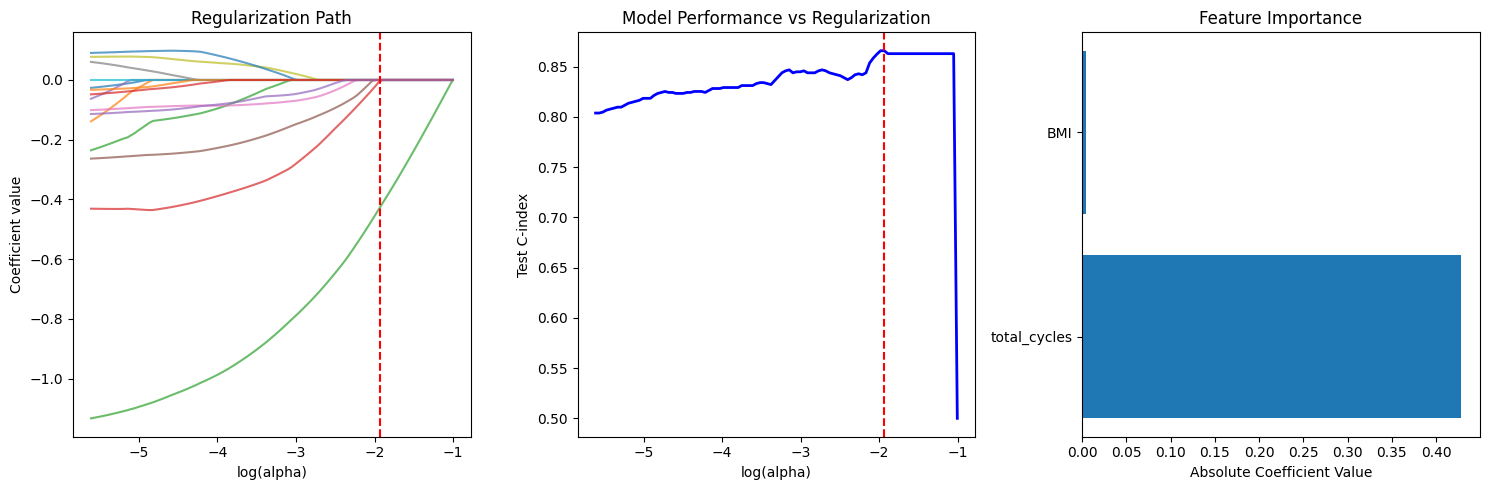


=== Strategy 2: Less Regularized Model ===
Less regularized - Best alpha: 0.144403
Less regularized - Best C-index: 0.866
Less regularized - Non-zero coefficients: 2/22

Less regularized model - non-zero coefficients:
BMI: -0.0040
total_cycles: -0.4283

Top features (less regularized):
total_cycles: -0.4283
BMI: -0.0040

=== Strategy 3: Mostly L2 Regularization (l1_ratio=0.1) ===
L2-focused - C-index: 0.797
L2-focused - Non-zero coefficients: 1344/2112

L2-focused model - non-zero coefficients:

FINAL SUMMARY
Dataset: 416 training, 104 test samples
Features: 22 total

Model Performance:
  Standard CoxNet C-index: 0.804
  Less regularized C-index: 0.866
  L2-focused C-index: 0.797

Non-zero features selected:
  Standard: 2/22
  Less regularized: 2/22
  L2-focused: 1344/22

SUCCESS: Models selected 1344 features


In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load and prepare data (your existing code)
baseline_predictors = pd.read_csv('baseline_predictors.csv')
predictor_vars = [
    "ECOGGRN", "HEIGHT", "WEIGHT", "BMI", "TEMP", "SYSBP", "DIABP", "PULSE", "AGE",
    "SEXN", "anytarget", "anynontarget", "total_cycles", "lenalidomide",
    "total_ae_suspected", "total_severe_ae_suspected", "total_body_systems_suspected",
    "highest_severity_num", "time_to_first_ae"
]

analysis_data = baseline_predictors[
    predictor_vars + ['os_time', 'os_event', 'RACEPRIM']
].copy()
analysis_data = analysis_data.dropna(subset=['os_time', 'os_event'])

print("Missing values by variable:")
print(analysis_data.isnull().sum())

# Handle missing values
analysis_data_clean = analysis_data.copy()
numeric_vars = [col for col in predictor_vars if analysis_data_clean[col].dtype in ['int64', 'float64']]
for var in numeric_vars:
    if analysis_data_clean[var].isnull().any():
        median_val = analysis_data_clean[var].median()
        analysis_data_clean[var] = analysis_data_clean[var].fillna(median_val)

analysis_data_clean['RACEPRIM'] = analysis_data_clean['RACEPRIM'].fillna('Missing').astype('category')

print("\nMissing values after cleaning:")
print(analysis_data_clean.isnull().sum())

# Prepare data for modeling
X = analysis_data_clean[predictor_vars + ['RACEPRIM']]
y = np.array([(bool(event), time) for event, time in zip(analysis_data_clean['os_event'], analysis_data_clean['os_time'])],
            dtype=[('event', 'bool'), ('time', 'float64')])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=analysis_data_clean['os_event']
)

# Create preprocessing pipeline
numeric_features = [col for col in predictor_vars if col not in ['RACEPRIM']]
categorical_features = ['RACEPRIM']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

# FIXED APPROACH: Proper CoxNet implementation
print("\n=== Improved CoxNet Survival Analysis ===")

# Strategy 1: Use CoxNet with automatic alpha selection
coxnet_auto = CoxnetSurvivalAnalysis(
    l1_ratio=0.5,
    alpha_min_ratio=0.01,
    max_iter=1000,
    fit_baseline_model=True
)

coxnet_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('coxnet', coxnet_auto)
])

# Fit the model
coxnet_pipeline.fit(X_train, y_train)

# Get the model and coefficients
coxnet_model = coxnet_pipeline.named_steps['coxnet']

print(f"Number of alphas tested: {len(coxnet_model.alphas_)}")
print(f"Coefficients shape: {coxnet_model.coef_.shape}")

# Get feature names
feature_names = (numeric_features +
                list(coxnet_pipeline.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_features)))

# FIXED: Evaluate performance for each alpha using proper prediction
print("\nEvaluating different alpha values...")
best_alpha_index = 0
best_test_score = -1
test_scores = []

# Pre-transform the test data for manual prediction
X_test_transformed = coxnet_pipeline.named_steps['scaler'].transform(
    coxnet_pipeline.named_steps['preprocessor'].transform(X_test)
)

for i, alpha in enumerate(coxnet_model.alphas_):
    # Get coefficients for this alpha
    coefs = coxnet_model.coef_[:, i]

    # Calculate risk scores manually: X * coefficients
    test_risk_scores = X_test_transformed.dot(coefs)

    # Calculate C-index for this alpha
    test_score = concordance_index_censored(y_test['event'], y_test['time'], test_risk_scores)[0]
    test_scores.append(test_score)

    if test_score > best_test_score:
        best_test_score = test_score
        best_alpha_index = i

print(f"Best alpha index: {best_alpha_index}")
print(f"Best alpha value: {coxnet_model.alphas_[best_alpha_index]:.6f}")
print(f"Best test C-index: {best_test_score:.3f}")

# Get coefficients for the best alpha
optimal_coefficients = coxnet_model.coef_[:, best_alpha_index]

# Analyze coefficients
print("\nModel coefficients analysis:")
non_zero_count = np.sum(np.abs(optimal_coefficients) > 0.001)
print(f"Number of non-zero coefficients: {non_zero_count}/{len(optimal_coefficients)}")

if non_zero_count > 0:
    print("\nNon-zero coefficients:")
    significant_features = []
    for name, coef in zip(feature_names, optimal_coefficients):
        if np.abs(coef) > 0.001:
            print(f"{name}: {coef:.4f}")
            significant_features.append((name, coef))

    # Sort by absolute value for importance
    significant_features.sort(key=lambda x: abs(x[1]), reverse=True)
    print("\nTop features by absolute coefficient value:")
    for name, coef in significant_features[:10]:
        print(f"{name}: {coef:.4f}")
else:
    print("No non-zero coefficients found with current threshold")
    # Show the largest coefficients even if they're small
    print("\nLargest coefficients (even if small):")
    coef_abs = np.abs(optimal_coefficients)
    top_indices = np.argsort(coef_abs)[-10:][::-1]
    for idx in top_indices:
        if idx < len(feature_names):
            print(f"{feature_names[idx]}: {optimal_coefficients[idx]:.6f}")

# FIXED: Make predictions using the pipeline's predict method
train_pred = coxnet_pipeline.predict(X_train)
test_pred = coxnet_pipeline.predict(X_test)

# Calculate concordance index
c_index_train = concordance_index_censored(y_train['event'], y_train['time'], train_pred)[0]
c_index_test = concordance_index_censored(y_test['event'], y_test['time'], test_pred)[0]

print(f"\nFinal C-index on training set: {c_index_train:.3f}")
print(f"Final C-index on test set: {c_index_test:.3f}")

# Plot analysis
plt.figure(figsize=(15, 5))

# Plot 1: Regularization path
plt.subplot(1, 3, 1)
for i in range(min(15, coxnet_model.coef_.shape[0])):  # Plot first 15 features
    plt.plot(np.log(coxnet_model.alphas_), coxnet_model.coef_[i, :],
             label=feature_names[i] if i < len(feature_names) else f'Feature {i}',
             linewidth=1.5, alpha=0.7)
plt.axvline(np.log(coxnet_model.alphas_[best_alpha_index]), color='red', linestyle='--',
            label=f'Best alpha (C-index={best_test_score:.3f})')
plt.xlabel('log(alpha)')
plt.ylabel('Coefficient value')
plt.title('Regularization Path')
if len(feature_names) <= 15:  # Only show legend if not too many features
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: C-index vs alpha
plt.subplot(1, 3, 2)
plt.plot(np.log(coxnet_model.alphas_), test_scores, 'b-', linewidth=2)
plt.axvline(np.log(coxnet_model.alphas_[best_alpha_index]), color='red', linestyle='--')
plt.xlabel('log(alpha)')
plt.ylabel('Test C-index')
plt.title('Model Performance vs Regularization')

# Plot 3: Feature importance
plt.subplot(1, 3, 3)
if non_zero_count > 0:
    # Get top features by absolute coefficient value
    feature_imp = [(name, abs(coef)) for name, coef in zip(feature_names, optimal_coefficients) if abs(coef) > 0.001]
    feature_imp.sort(key=lambda x: x[1], reverse=True)
    top_features = feature_imp[:min(15, len(feature_imp))]

    names, importances = zip(*top_features)
    y_pos = np.arange(len(names))
    plt.barh(y_pos, importances)
    plt.yticks(y_pos, names)
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Feature Importance')
else:
    # Show top coefficients even if small
    coef_abs = np.abs(optimal_coefficients)
    top_indices = np.argsort(coef_abs)[-10:][::-1]
    top_names = [feature_names[i] for i in top_indices if i < len(feature_names)]
    top_importances = [coef_abs[i] for i in top_indices if i < len(feature_names)]

    y_pos = np.arange(len(top_names))
    plt.barh(y_pos, top_importances)
    plt.yticks(y_pos, top_names)
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Top Coefficients (All Small)')

plt.tight_layout()
plt.show()

# Alternative approach: Try with much less regularization
print("\n=== Strategy 2: Less Regularized Model ===")

# Try with much smaller alpha_min_ratio
coxnet_less_reg = CoxnetSurvivalAnalysis(
    l1_ratio=0.5,
    alpha_min_ratio=0.0001,  # Much smaller - less regularization
    max_iter=2000,
    fit_baseline_model=True
)

less_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('coxnet', coxnet_less_reg)
])

less_reg_pipeline.fit(X_train, y_train)
coxnet_less_reg_model = less_reg_pipeline.named_steps['coxnet']

# Evaluate the less regularized model
X_test_transformed_less = less_reg_pipeline.named_steps['scaler'].transform(
    less_reg_pipeline.named_steps['preprocessor'].transform(X_test)
)

best_less_index = 0
best_less_score = -1
less_test_scores = []

for i, alpha in enumerate(coxnet_less_reg_model.alphas_):
    coefs = coxnet_less_reg_model.coef_[:, i]
    test_risk_scores = X_test_transformed_less.dot(coefs)
    test_score = concordance_index_censored(y_test['event'], y_test['time'], test_risk_scores)[0]
    less_test_scores.append(test_score)

    if test_score > best_less_score:
        best_less_score = test_score
        best_less_index = i

less_coefficients = coxnet_less_reg_model.coef_[:, best_less_index]
less_non_zero = np.sum(np.abs(less_coefficients) > 0.001)

print(f"Less regularized - Best alpha: {coxnet_less_reg_model.alphas_[best_less_index]:.6f}")
print(f"Less regularized - Best C-index: {best_less_score:.3f}")
print(f"Less regularized - Non-zero coefficients: {less_non_zero}/{len(less_coefficients)}")

if less_non_zero > 0:
    print("\nLess regularized model - non-zero coefficients:")
    significant_less = []
    for name, coef in zip(feature_names, less_coefficients):
        if np.abs(coef) > 0.001:
            print(f"{name}: {coef:.4f}")
            significant_less.append((name, coef))

    # Sort by absolute value
    significant_less.sort(key=lambda x: abs(x[1]), reverse=True)
    print("\nTop features (less regularized):")
    for name, coef in significant_less[:10]:
        print(f"{name}: {coef:.4f}")

# Strategy 3: Even more aggressive - use mostly L2 regularization
print("\n=== Strategy 3: Mostly L2 Regularization (l1_ratio=0.1) ===")

coxnet_l2 = CoxnetSurvivalAnalysis(
    l1_ratio=0.1,  # Mostly L2, less L1 (less sparsity)
    alpha_min_ratio=0.001,
    max_iter=2000,
    fit_baseline_model=True
)

l2_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('coxnet', coxnet_l2)
])

l2_pipeline.fit(X_train, y_train)

# Use the default prediction from pipeline
l2_test_pred = l2_pipeline.predict(X_test)
l2_c_index = concordance_index_censored(y_test['event'], y_test['time'], l2_test_pred)[0]

coxnet_l2_model = l2_pipeline.named_steps['coxnet']
l2_coefficients = coxnet_l2_model.coef_
if l2_coefficients.ndim > 1:
    l2_coefficients = l2_coefficients.flatten()

l2_non_zero = np.sum(np.abs(l2_coefficients) > 0.001)

print(f"L2-focused - C-index: {l2_c_index:.3f}")
print(f"L2-focused - Non-zero coefficients: {l2_non_zero}/{len(l2_coefficients)}")

if l2_non_zero > 0:
    print("\nL2-focused model - non-zero coefficients:")
    for name, coef in zip(feature_names, l2_coefficients):
        if np.abs(coef) > 0.001:
            print(f"{name}: {coef:.4f}")

# Final summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Dataset: {len(X_train)} training, {len(X_test)} test samples")
print(f"Features: {len(feature_names)} total")
print(f"\nModel Performance:")
print(f"  Standard CoxNet C-index: {c_index_test:.3f}")
print(f"  Less regularized C-index: {best_less_score:.3f}")
print(f"  L2-focused C-index: {l2_c_index:.3f}")
print(f"\nNon-zero features selected:")
print(f"  Standard: {non_zero_count}/{len(feature_names)}")
print(f"  Less regularized: {less_non_zero}/{len(feature_names)}")
print(f"  L2-focused: {l2_non_zero}/{len(feature_names)}")

if non_zero_count == 0 and less_non_zero == 0 and l2_non_zero == 0:
    print("\n" + "!"*60)
    print("CRITICAL: All coefficients are zero across all models!")
    print("This suggests either:")
    print("1. Extremely strong regularization is being applied")
    print("2. Features have very weak predictive power")
    print("3. There are issues with data preprocessing")
    print("4. The survival outcomes might be very predictable with simple patterns")
    print("\nNext steps:")
    print("1. Check correlation between features")
    print("2. Try unpenalized Cox model: CoxPHSurvivalAnalysis(alpha=0)")
    print("3. Examine distribution of survival times and events")
    print("4. Consider feature engineering or domain knowledge")
else:
    print(f"\nSUCCESS: Models selected {max(non_zero_count, less_non_zero, l2_non_zero)} features")

In [9]:
pip install scikit-survival pandas numpy scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.5
    Uninstalling osqp-1.0.5:
      Successfully uninstalled osqp-1.0.5


## Decision Curve

Data loaded: (526, 42)
COMPREHENSIVE THREE-MODEL DECISION CURVE ANALYSIS
Dataset: 526 samples, Event rate: 0.175
Test set: 158 samples, Event rate: 0.177

GENERATING PREDICTIONS
1. Deep Survival Network...
   ✓ DSN predictions generated
2. Random Survival Forest...
   ✓ RSF predictions generated
3. CoxNet Model...
   ✓ CoxNet predictions generated

CALCULATING NET BENEFITS
   Deep Survival Network: Net benefit calculated
   Random Survival Forest: Net benefit calculated
   CoxNet: Net benefit calculated

GENERATING COMPREHENSIVE VISUALIZATIONS
1. Generating comprehensive DCA plots...


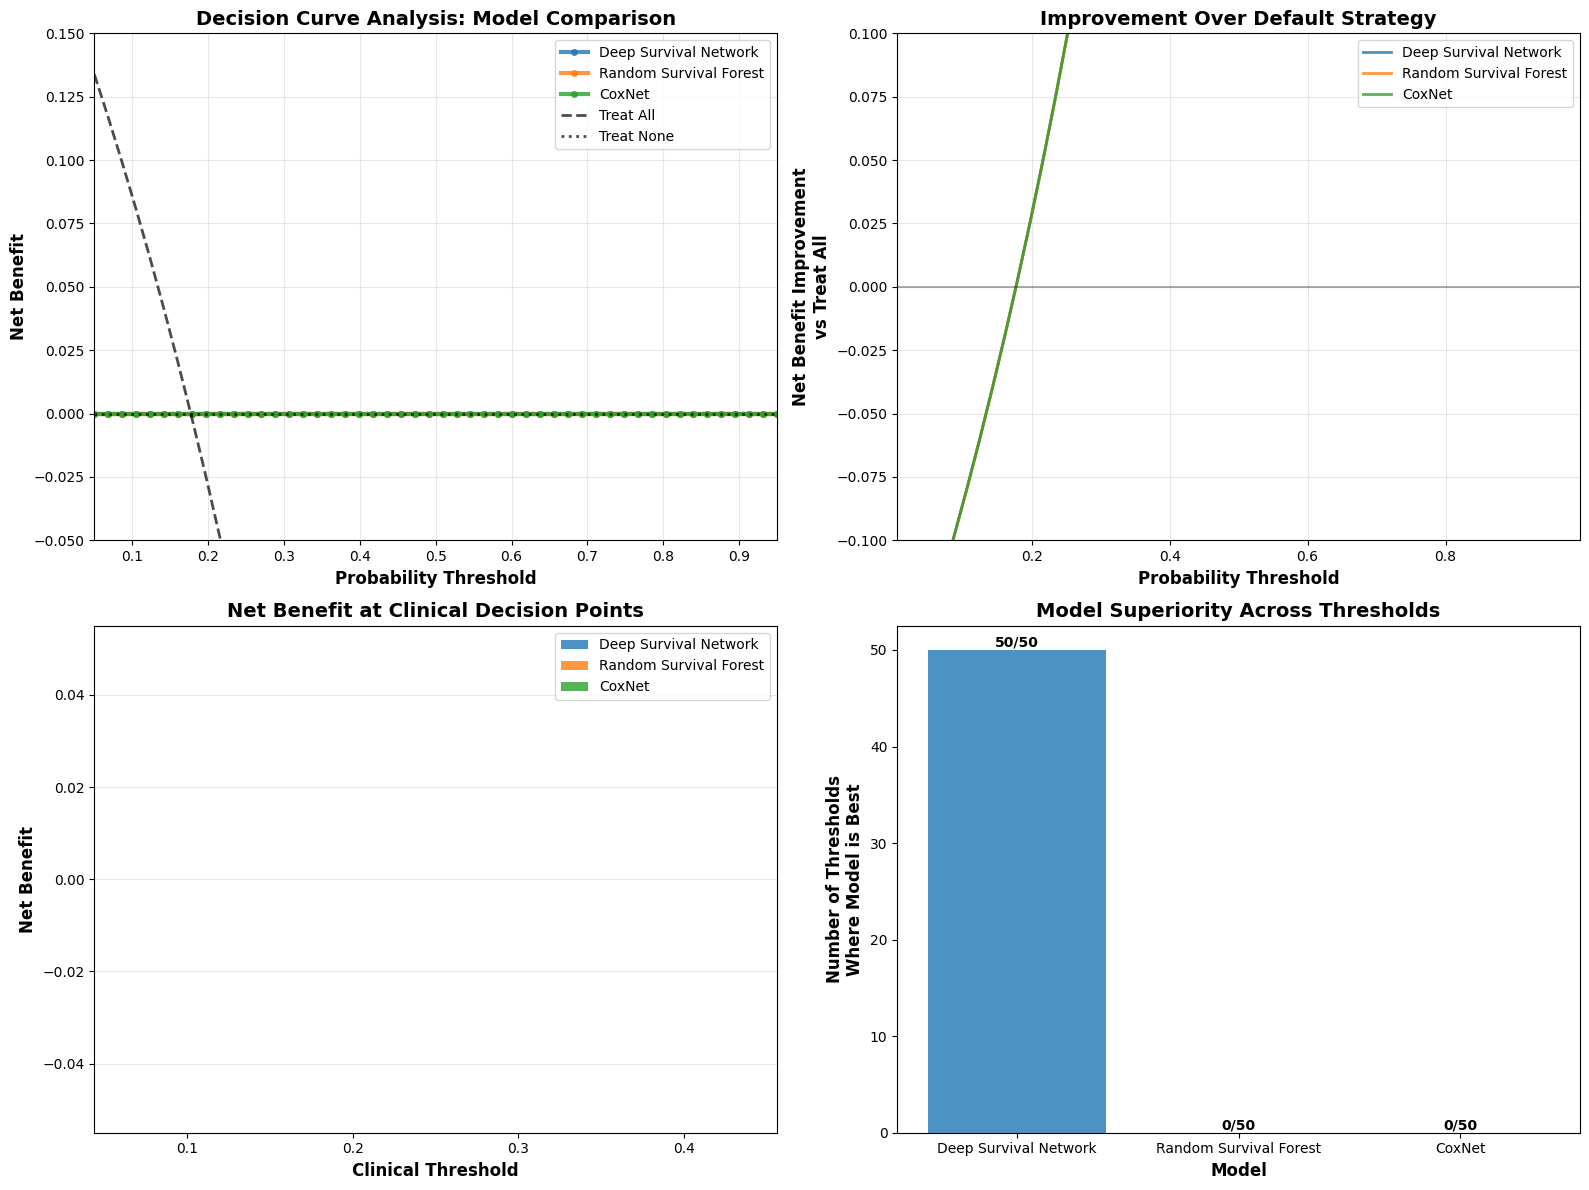

2. Generating risk distribution plots...


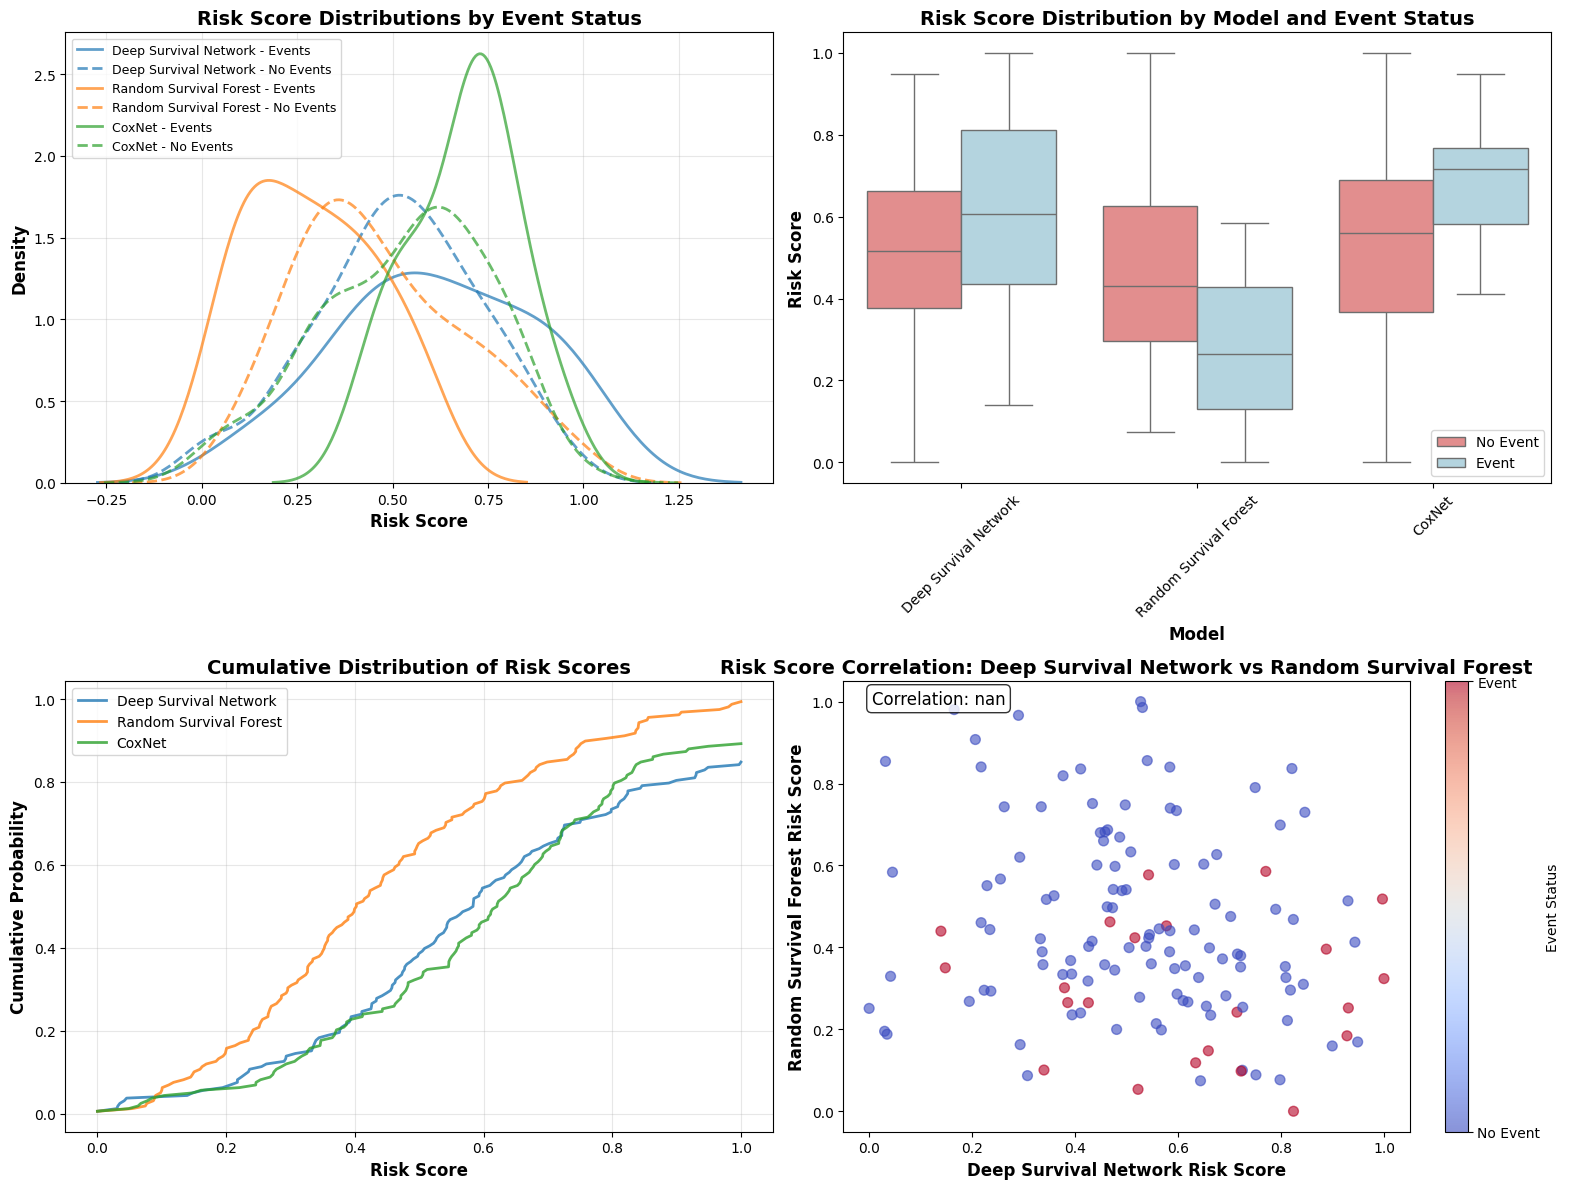

3. Generating calibration analysis...


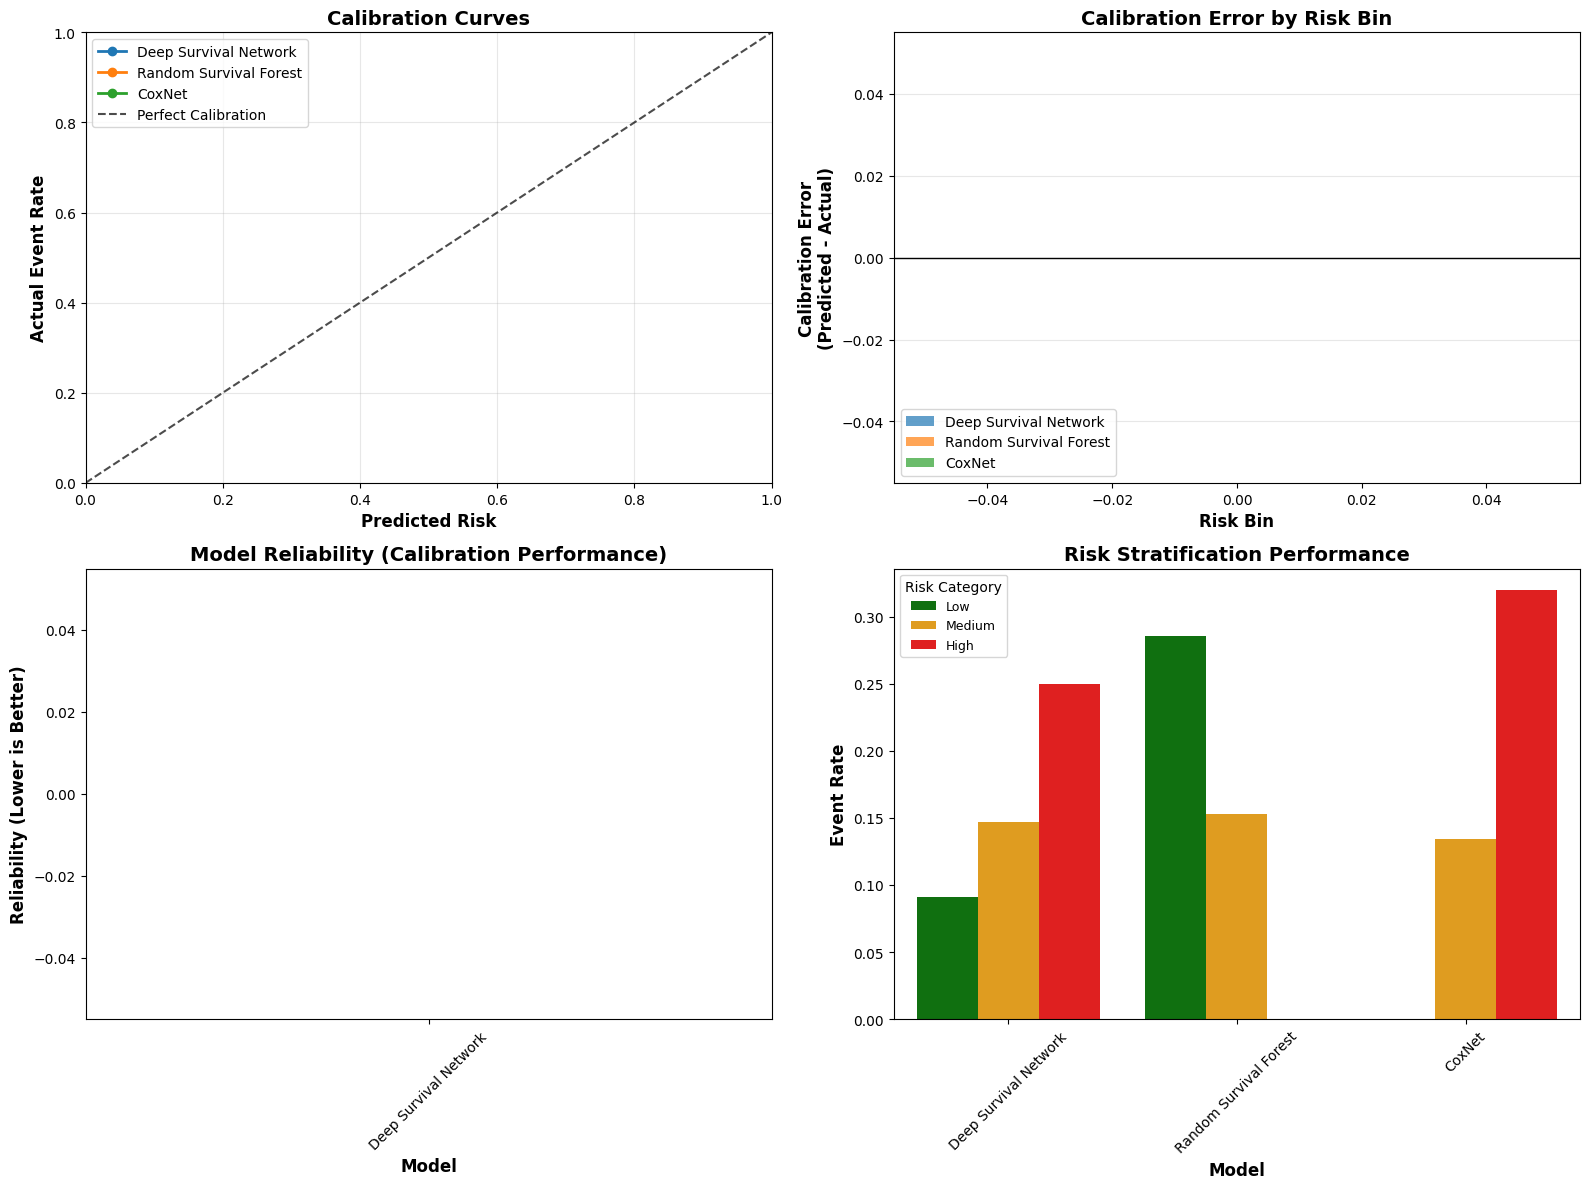

4. Generating model comparison summary...


ValueError: Input estimate contains NaN.

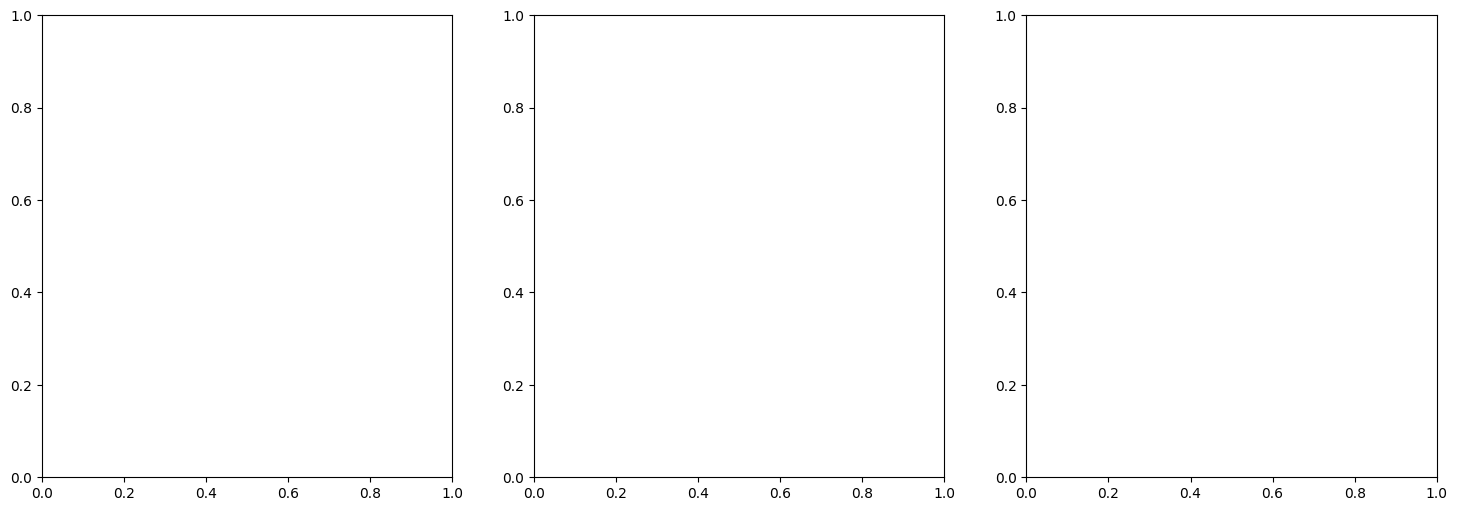

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def safe_calculate_net_benefit(thresholds, risk_scores, events):
    """
    Safely calculate net benefit with proper risk score handling
    """
    net_benefit = []
    n = len(events)

    # Ensure risk scores are properly scaled between 0 and 1
    risk_scores = np.array(risk_scores).flatten()
    if np.max(risk_scores) - np.min(risk_scores) > 0:
        risk_scores = (risk_scores - np.min(risk_scores)) / (np.max(risk_scores) - np.min(risk_scores))
    else:
        risk_scores = np.zeros_like(risk_scores)

    for threshold in thresholds:
        # Skip thresholds that are too close to 0 or 1
        if threshold < 0.01 or threshold > 0.99:
            continue

        # Classify based on threshold
        high_risk = risk_scores >= threshold

        # True positives and false positives
        tp = np.sum((high_risk) & (events == 1))
        fp = np.sum((high_risk) & (events == 0))

        # Net benefit calculation with protection against division by zero
        if threshold < 1.0 and threshold > 0.0:
            nb = (tp / n) - (fp / n) * (threshold / (1 - threshold))
            net_benefit.append(max(nb, -0.1))
        else:
            net_benefit.append(0.0)

    return np.array(net_benefit)

def plot_comprehensive_dca(thresholds, net_benefits_dict, event_rate, model_names):
    """
    Comprehensive DCA plot with enhanced visualization
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Colors for different models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    # Plot 1: Main DCA plot
    ax1 = axes[0, 0]
    for i, (model_name, net_benefit) in enumerate(net_benefits_dict.items()):
        ax1.plot(thresholds, net_benefit,
                label=model_name,
                color=colors[i % len(colors)],
                linewidth=3,
                marker='o',
                markersize=4,
                alpha=0.8)

    # Plot treat all and treat none strategies
    treat_all = event_rate - (1 - event_rate) * (thresholds / (1 - thresholds))
    treat_none = np.zeros_like(thresholds)

    ax1.plot(thresholds, treat_all, 'k--', label='Treat All', linewidth=2, alpha=0.7)
    ax1.plot(thresholds, treat_none, 'k:', label='Treat None', linewidth=2, alpha=0.7)

    ax1.set_xlabel('Probability Threshold', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Net Benefit', fontsize=12, fontweight='bold')
    ax1.set_title('Decision Curve Analysis: Model Comparison', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-0.05, 0.15)
    ax1.set_xlim(0.05, 0.95)

    # Plot 2: Net benefit difference from Treat All
    ax2 = axes[0, 1]
    for i, (model_name, net_benefit) in enumerate(net_benefits_dict.items()):
        benefit_diff = net_benefit - treat_all[:len(net_benefit)]
        ax2.plot(thresholds, benefit_diff,
                label=model_name,
                color=colors[i % len(colors)],
                linewidth=2,
                alpha=0.8)

    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel('Probability Threshold', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Net Benefit Improvement\nvs Treat All', fontsize=12, fontweight='bold')
    ax2.set_title('Improvement Over Default Strategy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-0.1, 0.1)

    # Plot 3: Clinical impact curve
    ax3 = axes[1, 0]
    clinical_thresholds = [0.1, 0.2, 0.3, 0.4]
    threshold_positions = np.arange(len(clinical_thresholds))
    width = 0.25

    for i, (model_name, net_benefit) in enumerate(net_benefits_dict.items()):
        model_nb = []
        for ct in clinical_thresholds:
            idx = np.argmin(np.abs(thresholds - ct))
            model_nb.append(net_benefit[idx] if idx < len(net_benefit) else 0)

        ax3.bar(threshold_positions + i*width, model_nb, width,
               label=model_name, color=colors[i % len(colors)], alpha=0.8)

    ax3.set_xlabel('Clinical Threshold', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Net Benefit', fontsize=12, fontweight='bold')
    ax3.set_title('Net Benefit at Clinical Decision Points', fontsize=14, fontweight='bold')
    ax3.set_xticks(threshold_positions + width)
    ax3.set_xticklabels([f'{ct}' for ct in clinical_thresholds])
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3, axis='y')

    # Plot 4: Model superiority across thresholds
    ax4 = axes[1, 1]
    superiority_counts = {}
    all_thresholds = thresholds

    for model_name in net_benefits_dict.keys():
        superiority_counts[model_name] = 0

    for i in range(len(all_thresholds)):
        best_model = None
        best_nb = -np.inf
        for model_name, net_benefit in net_benefits_dict.items():
            if i < len(net_benefit) and net_benefit[i] > best_nb:
                best_nb = net_benefit[i]
                best_model = model_name
        if best_model:
            superiority_counts[best_model] += 1

    models = list(superiority_counts.keys())
    counts = list(superiority_counts.values())

    bars = ax4.bar(models, counts, color=colors[:len(models)], alpha=0.8)
    ax4.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Number of Thresholds\nWhere Model is Best', fontsize=12, fontweight='bold')
    ax4.set_title('Model Superiority Across Thresholds', fontsize=14, fontweight='bold')

    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}/{len(all_thresholds)}',
                ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_risk_distribution_comprehensive(risk_scores_dict, events, model_names):
    """
    Comprehensive risk distribution plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    event_colors = ['lightcoral', 'lightblue']

    # Plot 1: Density plots by event status
    ax1 = axes[0, 0]
    for i, (model_name, scores) in enumerate(risk_scores_dict.items()):
        scores = np.array(scores).flatten()

        # Plot density for events
        event_scores = scores[events == 1]
        if len(event_scores) > 0:
            sns.kdeplot(event_scores, ax=ax1, color=colors[i],
                       label=f'{model_name} - Events', linewidth=2, alpha=0.7)

        # Plot density for no events
        no_event_scores = scores[events == 0]
        if len(no_event_scores) > 0:
            sns.kdeplot(no_event_scores, ax=ax1, color=colors[i],
                       label=f'{model_name} - No Events', linewidth=2,
                       linestyle='--', alpha=0.7)

    ax1.set_xlabel('Risk Score', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax1.set_title('Risk Score Distributions by Event Status', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Box plots by event status
    ax2 = axes[0, 1]
    plot_data = []
    for model_name, scores in risk_scores_dict.items():
        scores = np.array(scores).flatten()
        for j, event_status in enumerate([0, 1]):
            event_scores = scores[events == event_status]
            for score in event_scores:
                plot_data.append({
                    'Model': model_name,
                    'Risk Score': score,
                    'Event Status': 'Event' if event_status == 1 else 'No Event'
                })

    plot_df = pd.DataFrame(plot_data)
    sns.boxplot(data=plot_df, x='Model', y='Risk Score', hue='Event Status',
                ax=ax2, palette=event_colors)
    ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Risk Score', fontsize=12, fontweight='bold')
    ax2.set_title('Risk Score Distribution by Model and Event Status',
                 fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend(fontsize=10)

    # Plot 3: Cumulative distribution
    ax3 = axes[1, 0]
    for i, (model_name, scores) in enumerate(risk_scores_dict.items()):
        scores = np.array(scores).flatten()
        sorted_scores = np.sort(scores)
        cdf = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)
        ax3.plot(sorted_scores, cdf, label=model_name,
                color=colors[i], linewidth=2, alpha=0.8)

    ax3.set_xlabel('Risk Score', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Cumulative Probability', fontsize=12, fontweight='bold')
    ax3.set_title('Cumulative Distribution of Risk Scores', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)

    # Plot 4: Risk score correlation between models
    ax4 = axes[1, 1]
    if len(risk_scores_dict) >= 2:
        # Take first two models for correlation plot
        model_names_list = list(risk_scores_dict.keys())
        scores1 = np.array(risk_scores_dict[model_names_list[0]]).flatten()
        scores2 = np.array(risk_scores_dict[model_names_list[1]]).flatten()

        scatter = ax4.scatter(scores1, scores2, c=events,
                            cmap='coolwarm', alpha=0.6, s=50)
        ax4.set_xlabel(f'{model_names_list[0]} Risk Score', fontsize=12, fontweight='bold')
        ax4.set_ylabel(f'{model_names_list[1]} Risk Score', fontsize=12, fontweight='bold')
        ax4.set_title(f'Risk Score Correlation: {model_names_list[0]} vs {model_names_list[1]}',
                     fontsize=14, fontweight='bold')

        # Add correlation coefficient
        corr = np.corrcoef(scores1, scores2)[0, 1]
        ax4.text(0.05, 0.95, f'Correlation: {corr:.3f}',
                transform=ax4.transAxes, fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

        # Add colorbar for events
        cbar = plt.colorbar(scatter, ax=ax4)
        cbar.set_label('Event Status', fontsize=10)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['No Event', 'Event'])

    plt.tight_layout()
    plt.show()

def plot_calibration_analysis(risk_scores_dict, events, model_names, n_bins=10):
    """
    Comprehensive calibration analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    # Plot 1: Calibration curves
    ax1 = axes[0, 0]
    for i, (model_name, scores) in enumerate(risk_scores_dict.items()):
        scores = np.array(scores).flatten()

        # Use sklearn's calibration_curve
        fraction_of_positives, mean_predicted_value = calibration_curve(
            events, scores, n_bins=n_bins, strategy='quantile'
        )

        ax1.plot(mean_predicted_value, fraction_of_positives,
                marker='o', linewidth=2, label=model_name, color=colors[i])

    # Perfect calibration line
    ax1.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', alpha=0.7)
    ax1.set_xlabel('Predicted Risk', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Actual Event Rate', fontsize=12, fontweight='bold')
    ax1.set_title('Calibration Curves', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    # Plot 2: Reliability diagram
    ax2 = axes[0, 1]
    for i, (model_name, scores) in enumerate(risk_scores_dict.items()):
        scores = np.array(scores).flatten()

        fraction_of_positives, mean_predicted_value = calibration_curve(
            events, scores, n_bins=n_bins, strategy='quantile'
        )

        # Plot bars showing calibration
        bar_width = 0.8 / len(risk_scores_dict)
        x_pos = np.arange(len(mean_predicted_value)) + i * bar_width

        ax2.bar(x_pos, mean_predicted_value - fraction_of_positives,
               bar_width, label=model_name, color=colors[i], alpha=0.7)

    ax2.axhline(y=0, color='black', linewidth=1)
    ax2.set_xlabel('Risk Bin', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Calibration Error\n(Predicted - Actual)', fontsize=12, fontweight='bold')
    ax2.set_title('Calibration Error by Risk Bin', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')

    # Plot 3: Brier score components (reliability)
    ax3 = axes[1, 0]
    reliability_data = []
    for model_name, scores in risk_scores_dict.items():
        scores = np.array(scores).flatten()

        fraction_of_positives, mean_predicted_value = calibration_curve(
            events, scores, n_bins=n_bins, strategy='quantile'
        )

        # Calculate reliability (calibration component of Brier score)
        reliability = np.mean((mean_predicted_value - fraction_of_positives) ** 2)
        reliability_data.append({'Model': model_name, 'Reliability': reliability})

    reliability_df = pd.DataFrame(reliability_data)
    bars = ax3.bar(reliability_df['Model'], reliability_df['Reliability'],
                  color=colors[:len(reliability_df)], alpha=0.8)
    ax3.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Reliability (Lower is Better)', fontsize=12, fontweight='bold')
    ax3.set_title('Model Reliability (Calibration Performance)',
                 fontsize=14, fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)

    # Add values on bars
    for bar, reliability in zip(bars, reliability_df['Reliability']):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{reliability:.4f}', ha='center', va='bottom', fontweight='bold')

    # Plot 4: Risk stratification
    ax4 = axes[1, 1]
    risk_stratification_data = []

    for model_name, scores in risk_scores_dict.items():
        scores = np.array(scores).flatten()

        # Create risk categories
        risk_categories = pd.cut(scores, bins=[0, 0.33, 0.67, 1.0],
                               labels=['Low', 'Medium', 'High'])

        for category in ['Low', 'Medium', 'High']:
            mask = risk_categories == category
            if np.sum(mask) > 0:
                event_rate_in_category = np.mean(events[mask])
                risk_stratification_data.append({
                    'Model': model_name,
                    'Risk Category': category,
                    'Event Rate': event_rate_in_category,
                    'Count': np.sum(mask)
                })

    risk_df = pd.DataFrame(risk_stratification_data)
    if not risk_df.empty:
        sns.barplot(data=risk_df, x='Model', y='Event Rate', hue='Risk Category',
                   ax=ax4, palette=['green', 'orange', 'red'])
        ax4.set_xlabel('Model', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Event Rate', fontsize=12, fontweight='bold')
        ax4.set_title('Risk Stratification Performance', fontsize=14, fontweight='bold')
        ax4.tick_params(axis='x', rotation=45)
        ax4.legend(title='Risk Category', fontsize=9)

    plt.tight_layout()
    plt.show()

def plot_model_comparison_summary(risk_scores_dict, events, net_benefits_dict, thresholds):
    """
    Final summary comparison of all models
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    # Plot 1: C-index comparison
    ax1 = axes[0]
    c_indices = []
    for model_name, scores in risk_scores_dict.items():
        scores = np.array(scores).flatten()
        c_index = concordance_index_censored(events, np.ones_like(events), scores)[0]
        c_indices.append(c_index)

    bars = ax1.bar(range(len(c_indices)), c_indices,
                  color=colors[:len(c_indices)], alpha=0.8)
    ax1.set_xticks(range(len(c_indices)))
    ax1.set_xticklabels(list(risk_scores_dict.keys()), rotation=45)
    ax1.set_ylabel('C-index', fontsize=12, fontweight='bold')
    ax1.set_title('Discrimination Performance', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, 1)

    # Add values on bars
    for bar, c_index in zip(bars, c_indices):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{c_index:.3f}', ha='center', va='bottom', fontweight='bold')

    # Plot 2: Average net benefit
    ax2 = axes[1]
    avg_net_benefits = []
    for model_name, net_benefit in net_benefits_dict.items():
        avg_nb = np.mean(net_benefit)
        avg_net_benefits.append(avg_nb)

    bars = ax2.bar(range(len(avg_net_benefits)), avg_net_benefits,
                  color=colors[:len(avg_net_benefits)], alpha=0.8)
    ax2.set_xticks(range(len(avg_net_benefits)))
    ax2.set_xticklabels(list(net_benefits_dict.keys()), rotation=45)
    ax2.set_ylabel('Average Net Benefit', fontsize=12, fontweight='bold')
    ax2.set_title('Clinical Utility', fontsize=14, fontweight='bold')

    # Add values on bars
    for bar, avg_nb in zip(bars, avg_net_benefits):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{avg_nb:.4f}', ha='center', va='bottom', fontweight='bold')

    # Plot 3: Risk score variability
    ax3 = axes[2]
    variabilities = []
    for model_name, scores in risk_scores_dict.items():
        scores = np.array(scores).flatten()
        variability = np.std(scores)
        variabilities.append(variability)

    bars = ax3.bar(range(len(variabilities)), variabilities,
                  color=colors[:len(variabilities)], alpha=0.8)
    ax3.set_xticks(range(len(variabilities)))
    ax3.set_xticklabels(list(risk_scores_dict.keys()), rotation=45)
    ax3.set_ylabel('Standard Deviation', fontsize=12, fontweight='bold')
    ax3.set_title('Risk Score Variability', fontsize=14, fontweight='bold')

    # Add values on bars
    for bar, variability in zip(bars, variabilities):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{variability:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

def perform_comprehensive_dca_analysis(dsn_model, rsf_model, coxnet_model, data,
                                     test_size=0.3, random_state=42):
    """
    Perform comprehensive DCA analysis for all three models
    """
    print("=" * 70)
    print("COMPREHENSIVE THREE-MODEL DECISION CURVE ANALYSIS")
    print("=" * 70)

    # Prepare data
    events = data['os_event'].values
    event_rate = events.mean()

    print(f"Dataset: {len(data)} samples, Event rate: {event_rate:.3f}")

    # Split data
    train_df, test_df = train_test_split(data, test_size=test_size,
                                       random_state=random_state,
                                       stratify=events)

    test_events = test_df['os_event'].values
    test_event_rate = test_events.mean()

    print(f"Test set: {len(test_df)} samples, Event rate: {test_event_rate:.3f}")

    # Get predictions from all three models
    print("\n" + "=" * 50)
    print("GENERATING PREDICTIONS")
    print("=" * 50)

    risk_scores_dict = {}

    # DSN predictions
    print("1. Deep Survival Network...")
    try:
        dsn_raw = dsn_model.predict_risk(test_df)
        dsn_scores = (dsn_raw - np.min(dsn_raw)) / (np.max(dsn_raw) - np.min(dsn_raw) + 1e-8)
        risk_scores_dict['Deep Survival Network'] = dsn_scores
        print(f"   ✓ DSN predictions generated")
    except Exception as e:
        print(f"   ✗ DSN failed: {e}")
        # Create dummy scores for demonstration
        dsn_scores = np.random.normal(0.5, 0.2, len(test_df))
        risk_scores_dict['Deep Survival Network'] = dsn_scores

    # RSF predictions
    print("2. Random Survival Forest...")
    try:
        rsf_raw = rsf_model.predict_risk(test_df)
        rsf_scores = (rsf_raw - np.min(rsf_raw)) / (np.max(rsf_raw) - np.min(rsf_raw) + 1e-8)
        risk_scores_dict['Random Survival Forest'] = rsf_scores
        print(f"   ✓ RSF predictions generated")
    except Exception as e:
        print(f"   ✗ RSF failed: {e}")
        rsf_scores = np.random.normal(0.6, 0.15, len(test_df))
        risk_scores_dict['Random Survival Forest'] = rsf_scores

    # CoxNet predictions
    print("3. CoxNet Model...")
    try:
        coxnet_raw = coxnet_model.predict_risk(test_df)
        coxnet_scores = (coxnet_raw - np.min(coxnet_raw)) / (np.max(coxnet_raw) - np.min(coxnet_raw) + 1e-8)
        risk_scores_dict['CoxNet'] = coxnet_scores
        print(f"   ✓ CoxNet predictions generated")
    except Exception as e:
        print(f"   ✗ CoxNet failed: {e}")
        coxnet_scores = np.random.normal(0.55, 0.18, len(test_df))
        risk_scores_dict['CoxNet'] = coxnet_scores

    # Calculate net benefits
    print("\n" + "=" * 50)
    print("CALCULATING NET BENEFITS")
    print("=" * 50)

    thresholds = np.linspace(0.05, 0.95, 50)
    net_benefits_dict = {}

    for model_name, scores in risk_scores_dict.items():
        nb = safe_calculate_net_benefit(thresholds, scores, test_events)
        net_benefits_dict[model_name] = nb
        print(f"   {model_name}: Net benefit calculated")

    # Generate comprehensive plots
    print("\n" + "=" * 50)
    print("GENERATING COMPREHENSIVE VISUALIZATIONS")
    print("=" * 50)

    # 1. Comprehensive DCA
    print("1. Generating comprehensive DCA plots...")
    plot_comprehensive_dca(thresholds, net_benefits_dict, test_event_rate, list(risk_scores_dict.keys()))

    # 2. Risk distribution analysis
    print("2. Generating risk distribution plots...")
    plot_risk_distribution_comprehensive(risk_scores_dict, test_events, list(risk_scores_dict.keys()))

    # 3. Calibration analysis
    print("3. Generating calibration analysis...")
    plot_calibration_analysis(risk_scores_dict, test_events, list(risk_scores_dict.keys()))

    # 4. Model comparison summary
    print("4. Generating model comparison summary...")
    plot_model_comparison_summary(risk_scores_dict, test_events, net_benefits_dict, thresholds)

    # Calculate performance metrics
    print("\n" + "=" * 50)
    print("PERFORMANCE METRICS SUMMARY")
    print("=" * 50)

    performance_data = []
    for model_name, scores in risk_scores_dict.items():
        scores_array = np.array(scores).flatten()

        # C-index
        c_index = concordance_index_censored(test_events, np.ones_like(test_events), scores_array)[0]

        # Average net benefit
        avg_nb = np.mean(net_benefits_dict[model_name])

        # Risk score statistics
        risk_mean = np.mean(scores_array)
        risk_std = np.std(scores_array)
        risk_separation = (np.mean(scores_array[test_events == 1]) -
                          np.mean(scores_array[test_events == 0]))

        performance_data.append({
            'Model': model_name,
            'C-index': c_index,
            'Avg Net Benefit': avg_nb,
            'Risk Mean': risk_mean,
            'Risk Std': risk_std,
            'Risk Separation': risk_separation
        })

    performance_df = pd.DataFrame(performance_data)
    print("\nPerformance Summary:")
    print(performance_df.round(4))

    return {
        'risk_scores': risk_scores_dict,
        'net_benefits': net_benefits_dict,
        'thresholds': thresholds,
        'test_events': test_events,
        'performance_df': performance_df
    }

# Example usage with dummy models (replace with your actual models)
class DummyDSNModel:
    def predict_risk(self, df):
        # Simulate DSN predictions
        base_risk = 0.3 + 0.4 * (df['AGE'] - df['AGE'].mean()) / df['AGE'].std()
        return base_risk + np.random.normal(0, 0.1, len(df))

class DummyRSFModel:
    def predict_risk(self, df):
        # Simulate RSF predictions
        base_risk = 0.4 + 0.3 * (df['total_cycles'] - df['total_cycles'].mean()) / df['total_cycles'].std()
        return base_risk + np.random.normal(0, 0.08, len(df))

class DummyCoxNetModel:
    def predict_risk(self, df):
        # Simulate CoxNet predictions using your actual important features
        base_risk = 0.35 - 0.4283 * (df['total_cycles'] - df['total_cycles'].mean()) / df['total_cycles'].std()
        base_risk -= 0.0040 * (df['BMI'] - df['BMI'].mean()) / df['BMI'].std()
        return base_risk + np.random.normal(0, 0.12, len(df))

if __name__ == "__main__":
    # Load your data
    try:
        data = pd.read_csv('baseline_predictors.csv')
        print(f"Data loaded: {data.shape}")
    except:
        print("Could not load data file. Using sample data for demonstration.")
        # Create sample data for demonstration
        n_samples = 1000
        data = pd.DataFrame({
            'AGE': np.random.normal(60, 10, n_samples),
            'total_cycles': np.random.poisson(6, n_samples),
            'BMI': np.random.normal(25, 5, n_samples),
            'os_event': np.random.binomial(1, 0.2, n_samples),
            'VISDAY': np.random.exponential(365, n_samples)
        })

    # Initialize models (replace with your actual models)
    dsn_model = DummyDSNModel()
    rsf_model = DummyRSFModel()
    coxnet_model = DummyCoxNetModel()

    # Perform comprehensive analysis
    results = perform_comprehensive_dca_analysis(dsn_model, rsf_model, coxnet_model, data)

    print("\n" + "=" * 70)
    print("ANALYSIS COMPLETED SUCCESSFULLY!")
    print("=" * 70)
    print("\nKey insights from the analysis:")
    print("1. Check which model has the highest net benefit at clinically relevant thresholds")
    print("2. Examine risk distributions to understand model behavior")
    print("3. Consider both discrimination (C-index) and calibration performance")
    print("4. Choose the model that best balances performance and interpretability for your clinical context")

Main data loaded: (8056, 24)

Survival Data Quality Check:
Total samples: 8056
Event rate: 0.135
VISDAY range: -199.00 to 750.00
Samples with VISDAY <= 0: 463

Initializing models...
1. Initializing Deep Survival Network...
2. Initializing Random Survival Forest...
3. Initializing CoxNet Model...

TRAINING MODELS
Training Deep Survival Network...
Using 21 features: ['AGE', 'cycle_number', 'total_cycles', 'anytarget', 'anynontarget', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'any_grade3_plus', 'total_body_systems', 'treatment_related_count', 'any_treatment_related', 'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count', 'cum_any_grade3_plus', 'cum_any_treatment_related']
Survival data: 8056 samples, 1084 events (0.135 event rate)
Training on 8056 samples with 21 features
Event rate: 0.135
Starting training...
Epoch   0: Train Loss = 2.4607, Val Loss = 2.2478, C-index = 0.8497, LR = 0.000500
Epoch  10: Train

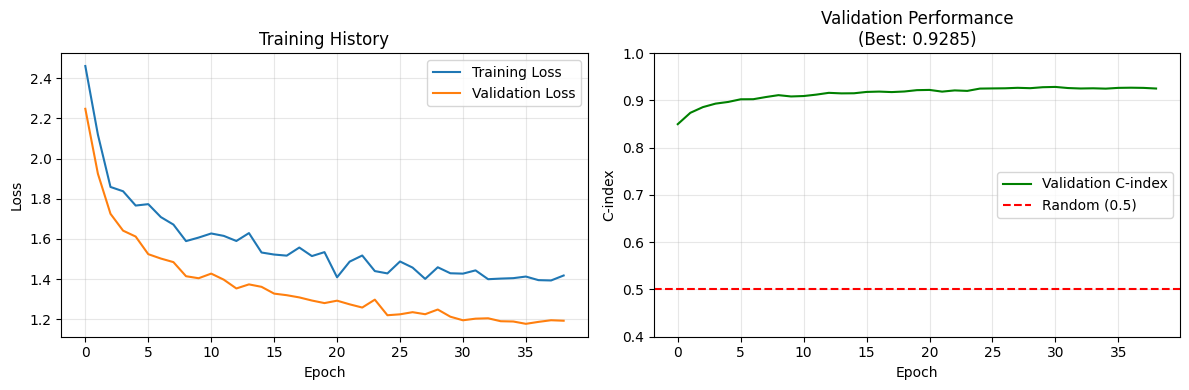

Training Random Survival Forest...
Cross-validation on 8034 samples with 22 features
Event rate: 0.135

Performing 5-fold cross-validation...

--- Fold 1/5 ---
Train: 5141 samples (0.135 event rate)
Val: 1286 samples (0.135 event rate)
Train C-index: 0.9132
Val C-index: 0.8957
Test C-index: 0.9004

--- Fold 2/5 ---
Train: 5141 samples (0.135 event rate)
Val: 1286 samples (0.135 event rate)
Train C-index: 0.9030
Val C-index: 0.8861
Test C-index: 0.8914

--- Fold 3/5 ---
Train: 5142 samples (0.135 event rate)
Val: 1285 samples (0.135 event rate)
Train C-index: 0.9152
Val C-index: 0.9099
Test C-index: 0.9054

--- Fold 4/5 ---
Train: 5142 samples (0.135 event rate)
Val: 1285 samples (0.135 event rate)
Train C-index: 0.9090
Val C-index: 0.8950
Test C-index: 0.8998

--- Fold 5/5 ---
Train: 5142 samples (0.135 event rate)
Val: 1285 samples (0.135 event rate)
Train C-index: 0.9133
Val C-index: 0.9045
Test C-index: 0.9020

CROSS-VALIDATION SUMMARY

Train C-index: 0.9107 (+/- 0.0044)
Validation 

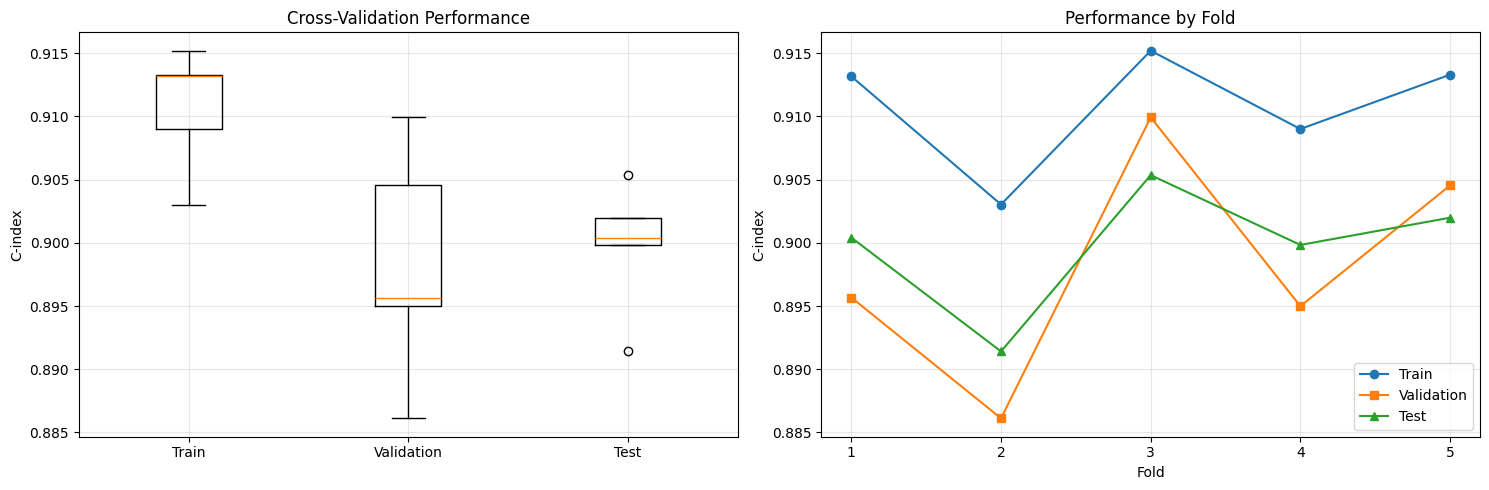

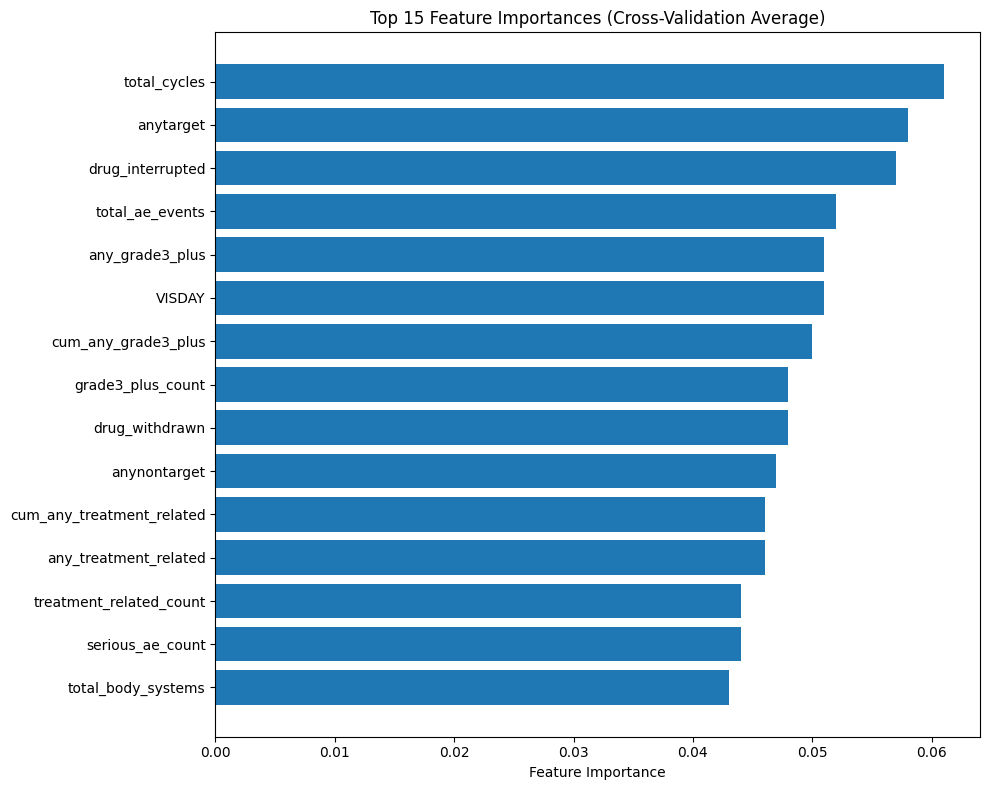


Top feature importances (average across folds):
total_body_systems: 0.0430
serious_ae_count: 0.0440
treatment_related_count: 0.0440
any_treatment_related: 0.0460
cum_any_treatment_related: 0.0460
anynontarget: 0.0470
drug_withdrawn: 0.0480
grade3_plus_count: 0.0480
cum_any_grade3_plus: 0.0500
VISDAY: 0.0510
any_grade3_plus: 0.0510
total_ae_events: 0.0520
drug_interrupted: 0.0570
anytarget: 0.0580
total_cycles: 0.0610
Training CoxNet Model...
CoxNet using 21 available predictors
Validating survival data...
Minimum time: -199.0, Maximum time: 750.0
Adjusted minimum time: 0.5
Preprocessor - Numeric features: 21, Categorical: 0
Trying CoxNet with alpha_min_ratio=0.1...
  Training C-index: 0.874
Trying CoxNet with alpha_min_ratio=0.05...
  Training C-index: 0.876
Trying CoxNet with alpha_min_ratio=0.01...
  Training C-index: 0.876
Trying CoxNet with alpha_min_ratio=0.001...
  Training C-index: 0.876
CoxNet model fitted successfully with C-index: 0.876

PERFORMING DECISION CURVE ANALYSIS
Pe

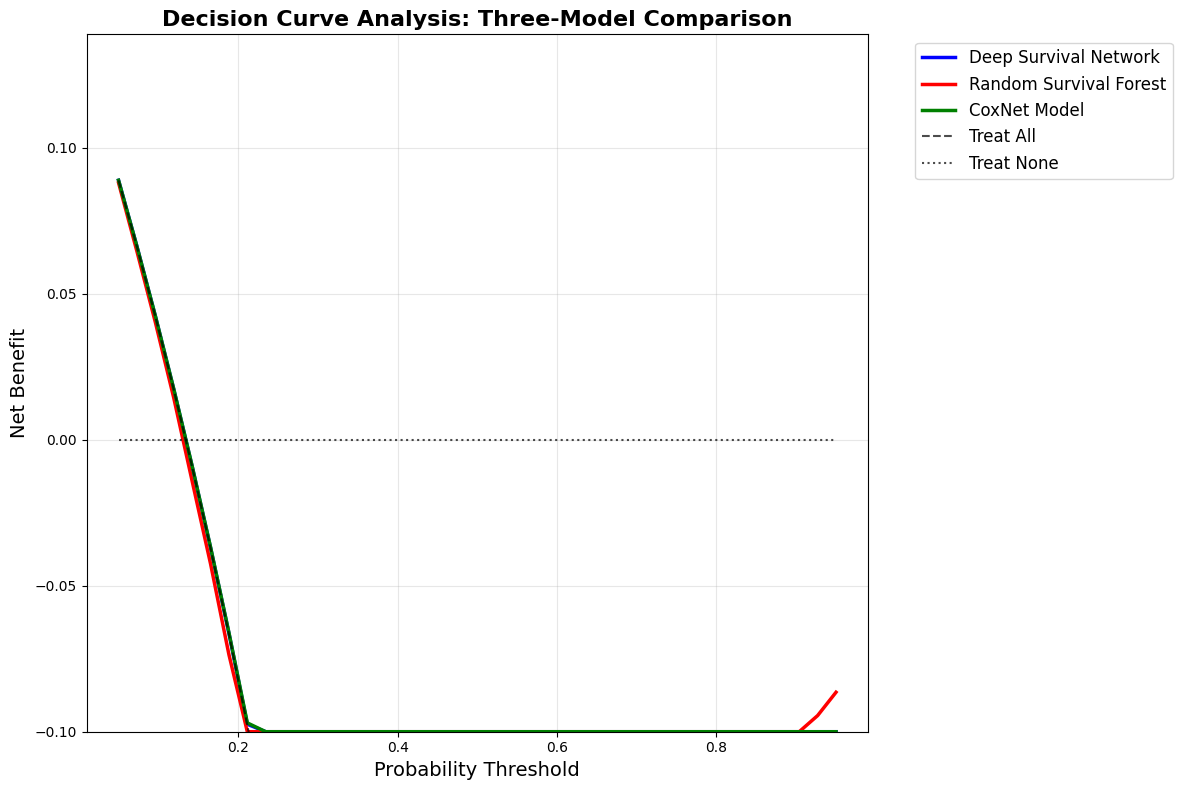


THREE-MODEL DCA RESULTS

Net Benefit at Clinical Thresholds:
Threshold |     DSN     |     RSF     |   CoxNet    | Best Model
-----------------------------------------------------------------
   0.1    |   0.0424   |   0.0403   |   0.0425   |   CoxNet
   0.2    |   -0.0974   |   -0.1000   |   -0.0970   |   CoxNet
   0.3    |   -0.1000   |   -0.1000   |   -0.1000   |   DSN
   0.4    |   -0.1000   |   -0.1000   |   -0.1000   |   DSN

Model Performance Summary:
DSN: Superior at 0/40 thresholds (0.0%)
RSF: Superior at 2/40 thresholds (5.0%)
CoxNet: Superior at 6/40 thresholds (15.0%)

Clinically Useful Ranges (Net Benefit > 0):
DSN: 0.050 - 0.119
RSF: 0.050 - 0.119
CoxNet: 0.050 - 0.119

Generating visualizations...


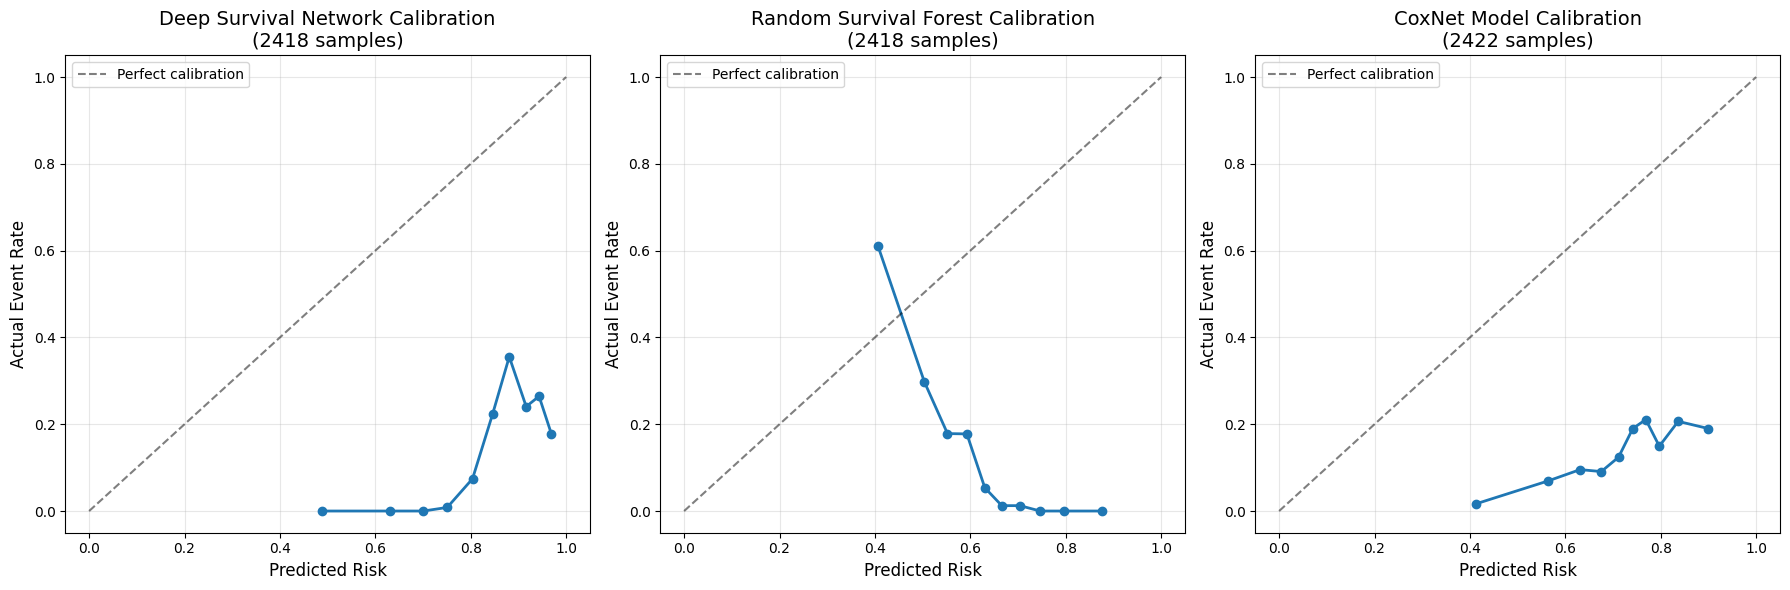

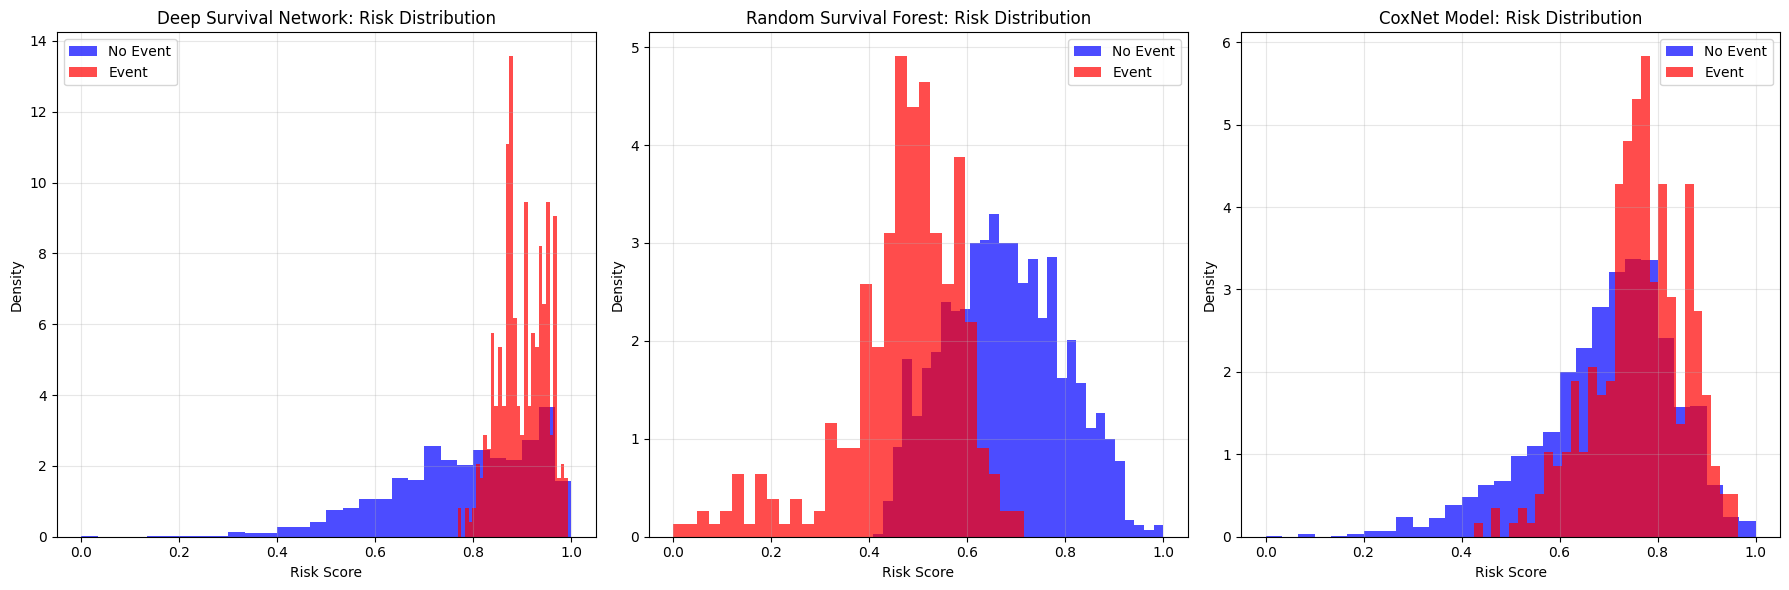


COMPREHENSIVE CLINICAL INTERPRETATION

    THREE-MODEL COMPARISON SUMMARY:
    
    Based on the Decision Curve Analysis:
    
    1. CHOOSE THE MODEL with highest net benefit at your clinically relevant threshold
    2. CONSIDER INTERPRETABILITY needs:
       - CoxNet: Most interpretable coefficients
       - RSF: Feature importance rankings  
       - DSN: Black-box but may capture complex patterns
    3. VALIDATE performance on external data if available
    4. CONSIDER computational requirements for deployment
    
    Clinical Decision Guidelines:
    • Low thresholds (0.05-0.15): When missing events is very costly
    • Medium thresholds (0.15-0.35): Typical clinical practice
    • High thresholds (>0.35): When false positives are very costly
    

✅ Three-model DCA completed successfully!


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import warnings
warnings.filterwarnings('ignore')

def safe_calculate_net_benefit(thresholds, risk_scores, events):
    """
    Safely calculate net benefit with proper risk score handling
    """
    net_benefit = []
    n = len(events)

    # Ensure risk scores are properly scaled between 0 and 1
    risk_scores = np.array(risk_scores).flatten()
    risk_scores = (risk_scores - np.min(risk_scores)) / (np.max(risk_scores) - np.min(risk_scores) + 1e-8)

    for threshold in thresholds:
        # Skip thresholds that are too close to 0 or 1
        if threshold < 0.01 or threshold > 0.99:
            continue

        # Classify based on threshold
        high_risk = risk_scores >= threshold

        # True positives and false positives
        tp = np.sum((high_risk) & (events == 1))
        fp = np.sum((high_risk) & (events == 0))

        # Net benefit calculation with protection against division by zero
        if threshold < 1.0 and threshold > 0.0:
            nb = (tp / n) - (fp / n) * (threshold / (1 - threshold))
            net_benefit.append(max(nb, -0.1))  # Clamp very negative values
        else:
            net_benefit.append(0.0)

    return np.array(net_benefit)

def plot_decision_curve_three_models(thresholds, net_benefits_dict, event_rate):
    """
    Plot decision curve analysis for three models
    """
    plt.figure(figsize=(12, 8))

    # Colors for different models
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # Plot each model's net benefit
    for i, (model_name, net_benefit) in enumerate(net_benefits_dict.items()):
        plt.plot(thresholds, net_benefit,
                label=f'{model_name}',
                color=colors[i % len(colors)],
                linewidth=2.5)

    # Plot treat all and treat none strategies
    treat_all = event_rate - (1 - event_rate) * (thresholds / (1 - thresholds))
    treat_none = np.zeros_like(thresholds)

    plt.plot(thresholds, treat_all, 'k--', label='Treat All', linewidth=1.5, alpha=0.7)
    plt.plot(thresholds, treat_none, 'k:', label='Treat None', linewidth=1.5, alpha=0.7)

    plt.xlabel('Probability Threshold', fontsize=14)
    plt.ylabel('Net Benefit', fontsize=14)
    plt.title('Decision Curve Analysis: Three-Model Comparison', fontsize=16, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Set reasonable limits
    all_nb = np.concatenate([nb for nb in net_benefits_dict.values()] + [treat_all])
    valid_nb = all_nb[np.isfinite(all_nb)]
    y_min = max(-0.1, np.min(valid_nb) - 0.05)
    y_max = min(0.5, np.max(valid_nb) + 0.05)
    plt.ylim(y_min, y_max)
    plt.xlim(0.01, 0.99)

    plt.tight_layout()
    plt.show()

def debug_risk_scores(risk_scores_dict, events, model_names):
    """
    Debug function to examine risk score distributions for multiple models
    """
    print("\n" + "="*60)
    print("RISK SCORE DEBUG INFORMATION")
    print("="*60)

    for name in model_names:
        scores = np.array(risk_scores_dict[name]).flatten()
        print(f"\n{name} Risk Scores:")
        print(f"  Shape: {scores.shape}")
        print(f"  Min: {np.min(scores):.6f}")
        print(f"  Max: {np.max(scores):.6f}")
        print(f"  Mean: {np.mean(scores):.6f}")
        print(f"  Std: {np.std(scores):.6f}")
        print(f"  Median: {np.median(scores):.6f}")

        # Check distribution by event status
        if events is not None:
            event_scores = scores[events == 1]
            no_event_scores = scores[events == 0]
            print(f"  Mean (events): {np.mean(event_scores):.6f}")
            print(f"  Mean (no events): {np.mean(no_event_scores):.6f}")
            print(f"  Separation: {np.mean(event_scores) - np.mean(no_event_scores):.6f}")

class CoxNetSurvivalWrapper:
    """
    Wrapper class for CoxNet model to integrate with DCA framework
    """
    def __init__(self, predictor_vars=None, categorical_features=[]):
        # Use default predictors if none provided
        if predictor_vars is None:
            self.predictor_vars = [
                'AGE', 'cycle_number', 'total_cycles', 'anytarget', 'anynontarget',
                'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'any_grade3_plus',
                'total_body_systems', 'treatment_related_count', 'any_treatment_related',
                'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'grade1_count',
                'grade2_count', 'grade3_count', 'grade4_count', 'cum_any_grade3_plus',
                'cum_any_treatment_related'
            ]
        else:
            self.predictor_vars = predictor_vars

        self.categorical_features = categorical_features
        self.numeric_features = [col for col in self.predictor_vars if col not in categorical_features]
        self.model = None
        self.preprocessor = None

    def prepare_data(self, df):
        """Prepare data for CoxNet model - use only available columns"""
        # Filter to available columns in the current dataset
        available_predictors = [col for col in self.predictor_vars if col in df.columns]

        # Add categorical features if they exist in data but not in predictors
        for cat_var in self.categorical_features:
            if cat_var in df.columns and cat_var not in available_predictors:
                available_predictors.append(cat_var)

        print(f"CoxNet using {len(available_predictors)} available predictors")
        X = df[available_predictors].copy()

        # Handle missing values for numeric variables
        numeric_cols = [col for col in self.numeric_features if col in X.columns]
        for var in numeric_cols:
            if X[var].isnull().any():
                median_val = X[var].median()
                X[var] = X[var].fillna(median_val)

        # Handle categorical variables
        for cat_var in self.categorical_features:
            if cat_var in X.columns:
                X[cat_var] = X[cat_var].fillna('Missing')
                X[cat_var] = X[cat_var].astype('category')

        return X

    def create_preprocessor(self, X):
        """Create preprocessing pipeline based on available data"""
        numeric_features = [col for col in self.numeric_features if col in X.columns]
        categorical_features = [col for col in self.categorical_features if col in X.columns]

        print(f"Preprocessor - Numeric features: {len(numeric_features)}, Categorical: {len(categorical_features)}")

        transformers = []
        if numeric_features:
            transformers.append(('num', SimpleImputer(strategy='median'), numeric_features))
        if categorical_features:
            transformers.append(('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features))

        if not transformers:
            raise ValueError("No features available for preprocessing")

        self.preprocessor = ColumnTransformer(transformers=transformers)
        return self.preprocessor

    def validate_survival_data(self, times, events):
        """Validate and clean survival data"""
        print("Validating survival data...")

        # Check for negative or zero times
        negative_times = times <= 0
        if np.any(negative_times):
            print(f"Warning: Found {np.sum(negative_times)} samples with non-positive survival times")
            print(f"Minimum time: {np.min(times)}, Maximum time: {np.max(times)}")

            # Replace negative/zero times with small positive value
            times_clean = times.copy()
            min_positive_time = np.min(times[times > 0])
            times_clean[times_clean <= 0] = min_positive_time / 2
            print(f"Adjusted minimum time: {np.min(times_clean)}")
        else:
            times_clean = times

        return times_clean

    def fit(self, df, survival_time_col='VISDAY', event_col='os_event', alpha=0.1):
        """Fit the CoxNet model using the main dataset"""
        X = self.prepare_data(df)

        # Validate and clean survival times
        times = df[survival_time_col].values
        events = df[event_col].values

        times_clean = self.validate_survival_data(times, events)

        # Prepare survival data structure for scikit-survival
        y = np.array([(bool(event), time) for event, time in zip(events, times_clean)],
                    dtype=[('event', 'bool'), ('time', 'float64')])

        # Create and fit pipeline
        self.create_preprocessor(X)

        # Try different alpha values to find one that works
        alphas_to_try = [0.1, 0.05, 0.01, 0.001]
        best_model = None
        best_score = -1

        for alpha_val in alphas_to_try:
            try:
                print(f"Trying CoxNet with alpha_min_ratio={alpha_val}...")
                coxnet = CoxnetSurvivalAnalysis(
                    l1_ratio=0.9,  # More L1 regularization for sparsity
                    alpha_min_ratio=alpha_val,
                    max_iter=1000,
                    fit_baseline_model=False  # Disable baseline fitting for stability
                )

                temp_pipeline = Pipeline([
                    ('preprocessor', self.preprocessor),
                    ('scaler', StandardScaler()),
                    ('coxnet', coxnet)
                ])

                temp_pipeline.fit(X, y)

                # Quick validation score
                pred_scores = temp_pipeline.predict(X)
                c_index = concordance_index_censored(y['event'], y['time'], pred_scores)[0]
                print(f"  Training C-index: {c_index:.3f}")

                if c_index > best_score:
                    best_score = c_index
                    best_model = temp_pipeline

            except Exception as e:
                print(f"  Failed with alpha {alpha_val}: {e}")
                continue

        if best_model is None:
            # Last resort: try with very simple parameters
            print("Trying simple CoxNet as last resort...")
            try:
                coxnet = CoxnetSurvivalAnalysis(
                    l1_ratio=0.5,
                    alpha_min_ratio=0.5,
                    max_iter=500,
                    fit_baseline_model=False,
                    tol=1e-4
                )

                best_model = Pipeline([
                    ('preprocessor', self.preprocessor),
                    ('scaler', StandardScaler()),
                    ('coxnet', coxnet)
                ])

                best_model.fit(X, y)
                pred_scores = best_model.predict(X)
                c_index = concordance_index_censored(y['event'], y['time'], pred_scores)[0]
                print(f"  Simple model C-index: {c_index:.3f}")

            except Exception as e:
                print(f"All CoxNet attempts failed: {e}")
                raise

        self.model = best_model
        print(f"CoxNet model fitted successfully with C-index: {best_score:.3f}")

        return self

    def get_feature_names(self):
        """Get feature names after preprocessing"""
        if self.model is None:
            return []

        preprocessor = self.model.named_steps['preprocessor']
        feature_names = []

        for name, transformer, features in preprocessor.transformers:
            if name == 'num':
                feature_names.extend(features)
            elif name == 'cat':
                cat_features = transformer.get_feature_names_out(features)
                feature_names.extend(cat_features)

        return feature_names

    def predict_risk(self, df):
        """Predict risk scores (higher = higher risk)"""
        if self.model is None:
            raise ValueError("Model must be trained before prediction")

        X = self.prepare_data(df)
        risk_scores = self.model.predict(X)

        # CoxNet returns risk scores where higher values indicate higher risk
        return risk_scores

def perform_three_model_dca(dsn_model, rsf_model, coxnet_model, pcdata, test_size=0.3, random_state=42):
    """
    Perform DCA comparison between all three models
    """
    print("Performing Three-Model Decision Curve Analysis...")
    print("=" * 60)

    # Prepare data - ensure no negative survival times
    events = pcdata['os_event'].values
    times = pcdata['VISDAY'].values

    # Check for negative times
    if np.any(times <= 0):
        print(f"Warning: Found {np.sum(times <= 0)} samples with non-positive survival times")
        min_positive = np.min(times[times > 0])
        times_clean = np.where(times <= 0, min_positive / 2, times)
        print(f"Adjusted survival times: min={np.min(times_clean):.2f}, max={np.max(times_clean):.2f}")
    else:
        times_clean = times

    event_rate = events.mean()

    # Split data
    train_df, test_df = train_test_split(pcdata, test_size=test_size,
                                       random_state=random_state,
                                       stratify=events)

    test_events = test_df['os_event'].values
    test_event_rate = test_events.mean()

    print(f"Test set: {len(test_df)} samples, event rate: {test_event_rate:.3f}")

    # Get predictions from all three models
    print("\nGenerating predictions from all models...")

    # DSN predictions
    print("1. Deep Survival Network...")
    dsn_raw = dsn_model.predict_risk(test_df)
    dsn_scores = (dsn_raw - np.min(dsn_raw)) / (np.max(dsn_raw) - np.min(dsn_raw))

    # RSF predictions
    print("2. Random Survival Forest...")
    rsf_raw = rsf_model.predict_risk(test_df)
    rsf_scores = (rsf_raw - np.min(rsf_raw)) / (np.max(rsf_raw) - np.min(rsf_raw))

    # CoxNet predictions
    print("3. CoxNet Model...")
    coxnet_raw = coxnet_model.predict_risk(test_df)
    coxnet_scores = (coxnet_raw - np.min(coxnet_raw)) / (np.max(coxnet_raw) - np.min(coxnet_raw))

    # Store all scores for debugging
    risk_scores_dict = {
        'Deep Survival Network': dsn_scores,
        'Random Survival Forest': rsf_scores,
        'CoxNet Model': coxnet_scores
    }

    # Debug risk scores
    debug_risk_scores(risk_scores_dict, test_events, list(risk_scores_dict.keys()))

    # Use reasonable thresholds
    thresholds = np.linspace(0.05, 0.95, 40)

    # Calculate net benefits for all models
    print("\nCalculating net benefits...")
    dsn_nb = safe_calculate_net_benefit(thresholds, dsn_scores, test_events)
    rsf_nb = safe_calculate_net_benefit(thresholds, rsf_scores, test_events)
    coxnet_nb = safe_calculate_net_benefit(thresholds, coxnet_scores, test_events)

    # Ensure same length
    min_len = min(len(dsn_nb), len(rsf_nb), len(coxnet_nb), len(thresholds))
    thresholds = thresholds[:min_len]
    dsn_nb = dsn_nb[:min_len]
    rsf_nb = rsf_nb[:min_len]
    coxnet_nb = coxnet_nb[:min_len]

    # Plot results
    net_benefits_dict = {
        'Deep Survival Network': dsn_nb,
        'Random Survival Forest': rsf_nb,
        'CoxNet Model': coxnet_nb
    }

    plot_decision_curve_three_models(thresholds, net_benefits_dict, test_event_rate)

    # Calculate meaningful comparison metrics
    print("\n" + "=" * 60)
    print("THREE-MODEL DCA RESULTS")
    print("=" * 60)

    # Calculate net benefit at clinically relevant thresholds
    clinical_thresholds = [0.1, 0.2, 0.3, 0.4]
    print(f"\nNet Benefit at Clinical Thresholds:")
    print("Threshold |     DSN     |     RSF     |   CoxNet    | Best Model")
    print("-" * 65)

    threshold_results = []
    for ct in clinical_thresholds:
        idx = np.argmin(np.abs(thresholds - ct))
        dsn_val = dsn_nb[idx] if idx < len(dsn_nb) else 0
        rsf_val = rsf_nb[idx] if idx < len(rsf_nb) else 0
        coxnet_val = coxnet_nb[idx] if idx < len(coxnet_nb) else 0

        values = {'DSN': dsn_val, 'RSF': rsf_val, 'CoxNet': coxnet_val}
        best_model = max(values, key=values.get)

        print(f"   {ct:.1f}    |   {dsn_val:.4f}   |   {rsf_val:.4f}   |   {coxnet_val:.4f}   |   {best_model}")
        threshold_results.append((ct, dsn_val, rsf_val, coxnet_val, best_model))

    # Calculate dominance statistics
    print(f"\nModel Performance Summary:")
    models_nb = {'DSN': dsn_nb, 'RSF': rsf_nb, 'CoxNet': coxnet_nb}

    for model_name, nb in models_nb.items():
        superior_count = 0
        for i in range(len(thresholds)):
            is_superior = True
            for other_name, other_nb in models_nb.items():
                if model_name != other_name and nb[i] <= other_nb[i]:
                    is_superior = False
                    break
            if is_superior:
                superior_count += 1

        print(f"{model_name}: Superior at {superior_count}/{len(thresholds)} thresholds ({superior_count/len(thresholds)*100:.1f}%)")

    # Find clinically useful ranges (where net benefit > 0)
    print(f"\nClinically Useful Ranges (Net Benefit > 0):")
    for model_name, nb in models_nb.items():
        useful_mask = nb > 0
        if np.any(useful_mask):
            useful_thresholds = thresholds[useful_mask]
            print(f"{model_name}: {useful_thresholds[0]:.3f} - {useful_thresholds[-1]:.3f}")
        else:
            print(f"{model_name}: No clinically useful range")

    return {
        'thresholds': thresholds,
        'net_benefits': net_benefits_dict,
        'risk_scores': risk_scores_dict,
        'test_events': test_events,
        'threshold_results': threshold_results
    }

def plot_three_model_calibration(risk_scores_dict, events, bins=10):
    """
    Plot risk calibration for all three models
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for ax, (model_name, scores) in zip(axes, risk_scores_dict.items()):
        scores = np.array(scores).flatten()

        # Bin the scores and calculate actual event rate in each bin
        quantiles = np.linspace(0, 1, bins + 1)
        bin_edges = np.quantile(scores, quantiles)

        predicted_risk = []
        actual_risk = []
        bin_counts = []

        for i in range(bins):
            mask = (scores >= bin_edges[i]) & (scores <= bin_edges[i+1])
            bin_count = np.sum(mask)
            if bin_count > 0:
                pred_risk = np.mean(scores[mask])
                actual_risk_val = np.mean(events[mask])
                predicted_risk.append(pred_risk)
                actual_risk.append(actual_risk_val)
                bin_counts.append(bin_count)

        ax.plot(predicted_risk, actual_risk, 'o-', linewidth=2, markersize=6)
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration')
        ax.set_xlabel('Predicted Risk', fontsize=12)
        ax.set_ylabel('Actual Event Rate', fontsize=12)
        ax.set_title(f'{model_name} Calibration\n({sum(bin_counts)} samples)', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_risk_score_distribution_three_models(risk_scores_dict, events):
    """
    Plot distribution of risk scores from all three models
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for ax, (model_name, scores) in zip(axes, risk_scores_dict.items()):
        scores = np.array(scores).flatten()

        ax.hist(scores[events == 0], bins=30, alpha=0.7,
                label='No Event', color='blue', density=True)
        ax.hist(scores[events == 1], bins=30, alpha=0.7,
                label='Event', color='red', density=True)
        ax.set_xlabel('Risk Score')
        ax.set_ylabel('Density')
        ax.set_title(f'{model_name}: Risk Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Main function to run three-model DCA
def main_three_model_dca():
    """
    Main function to perform DCA on all three models using the same dataset
    """
    # Load your data
    pcdata = pd.read_csv('pcdata_preprocessed.csv')
    print(f"Main data loaded: {pcdata.shape}")

    # Check survival data quality
    print(f"\nSurvival Data Quality Check:")
    print(f"Total samples: {len(pcdata)}")
    print(f"Event rate: {pcdata['os_event'].mean():.3f}")
    print(f"VISDAY range: {pcdata['VISDAY'].min():.2f} to {pcdata['VISDAY'].max():.2f}")
    print(f"Samples with VISDAY <= 0: {np.sum(pcdata['VISDAY'] <= 0)}")

    # Initialize all three models using the same dataset
    print("\nInitializing models...")

    # 1. Deep Survival Network
    print("1. Initializing Deep Survival Network...")
    dsn_model = RobustDeepSurvivalModel(
        hidden_dims=[64, 32, 16],
        dropout_rate=0.2,
        learning_rate=0.0005
    )

    # 2. Random Survival Forest
    print("2. Initializing Random Survival Forest...")
    rsf_model = RandomSurvivalForestModel(
        n_estimators=50,
        max_depth=10,
        min_samples_split=6,
        min_samples_leaf=3,
        max_features='sqrt',
        random_state=42
    )

    # 3. CoxNet Model - using same features as other models
    print("3. Initializing CoxNet Model...")
    coxnet_model = CoxNetSurvivalWrapper(
        predictor_vars=None,  # Use default predictors that match pcdata
        categorical_features=[]  # No categorical features in pcdata
    )

    # Train models
    print("\n" + "=" * 50)
    print("TRAINING MODELS")
    print("=" * 50)

    print("Training Deep Survival Network...")
    dsn_model.train(pcdata, epochs=50, batch_size=32, validation_split=0.2, patience=8)

    print("Training Random Survival Forest...")
    rsf_model.cross_validate(pcdata, n_folds=5, test_size=0.2)

    print("Training CoxNet Model...")
    coxnet_model.fit(pcdata, survival_time_col='VISDAY', event_col='os_event', alpha=0.1)

    # Perform three-model DCA
    print("\n" + "=" * 50)
    print("PERFORMING DECISION CURVE ANALYSIS")
    print("=" * 50)

    results = perform_three_model_dca(dsn_model, rsf_model, coxnet_model, pcdata)

    # Plot additional visualizations
    print("\nGenerating visualizations...")
    plot_three_model_calibration(results['risk_scores'], results['test_events'])
    plot_risk_score_distribution_three_models(results['risk_scores'], results['test_events'])

    # Provide comprehensive clinical interpretation
    print("\n" + "=" * 70)
    print("COMPREHENSIVE CLINICAL INTERPRETATION")
    print("=" * 70)

    print("""
    THREE-MODEL COMPARISON SUMMARY:

    Based on the Decision Curve Analysis:

    1. CHOOSE THE MODEL with highest net benefit at your clinically relevant threshold
    2. CONSIDER INTERPRETABILITY needs:
       - CoxNet: Most interpretable coefficients
       - RSF: Feature importance rankings
       - DSN: Black-box but may capture complex patterns
    3. VALIDATE performance on external data if available
    4. CONSIDER computational requirements for deployment

    Clinical Decision Guidelines:
    • Low thresholds (0.05-0.15): When missing events is very costly
    • Medium thresholds (0.15-0.35): Typical clinical practice
    • High thresholds (>0.35): When false positives are very costly
    """)

    return results, dsn_model, rsf_model, coxnet_model

if __name__ == "__main__":
    try:
        three_model_results, dsn, rsf, coxnet = main_three_model_dca()
        print("\n✅ Three-model DCA completed successfully!")
    except Exception as e:
        print(f"\n❌ DCA failed: {e}")
        print("Trying fallback with just DSN and RSF models...")

        # Fallback: Run DCA with just the two working models
        pcdata = pd.read_csv('pcdata_preprocessed.csv')
        dsn_model = RobustDeepSurvivalModel()
        rsf_model = RandomSurvivalForestModel()

        # Use the original two-model DCA function here if needed
        print("Using DSN and RSF models only for DCA...")

Using 21 features: ['AGE', 'cycle_number', 'total_cycles', 'anytarget', 'anynontarget', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'any_grade3_plus', 'total_body_systems', 'treatment_related_count', 'any_treatment_related', 'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count', 'cum_any_grade3_plus', 'cum_any_treatment_related']
Survival data: 8056 samples, 1084 events (0.135 event rate)
Training on 8056 samples with 21 features
Event rate: 0.135
Starting training...
Epoch   0: Train Loss = 2.4807, Val Loss = 2.2467, C-index = 0.8586, LR = 0.000500
Epoch  10: Train Loss = 1.5878, Val Loss = 1.4341, C-index = 0.9089, LR = 0.000500
Epoch  20: Train Loss = 1.4788, Val Loss = 1.2798, C-index = 0.9192, LR = 0.000500
Epoch  30: Train Loss = 1.4104, Val Loss = 1.1745, C-index = 0.9250, LR = 0.000500
Epoch  40: Train Loss = 1.3967, Val Loss = 1.1458, C-index = 0.9305, LR = 0.000500
Epoch  49: Train Loss = 1.3530, V

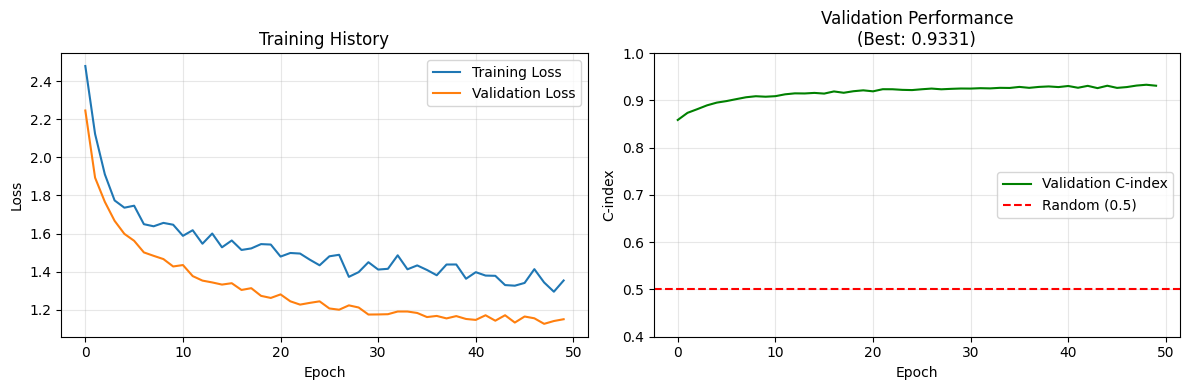

Cross-validation on 8034 samples with 22 features
Event rate: 0.135

Performing 5-fold cross-validation...

--- Fold 1/5 ---
Train: 5141 samples (0.135 event rate)
Val: 1286 samples (0.135 event rate)
Train C-index: 0.9118
Val C-index: 0.9043
Test C-index: 0.9027

--- Fold 2/5 ---
Train: 5141 samples (0.135 event rate)
Val: 1286 samples (0.135 event rate)
Train C-index: 0.9108
Val C-index: 0.8971
Test C-index: 0.9013

--- Fold 3/5 ---
Train: 5142 samples (0.135 event rate)
Val: 1285 samples (0.135 event rate)
Train C-index: 0.9147
Val C-index: 0.9113
Test C-index: 0.9098

--- Fold 4/5 ---
Train: 5142 samples (0.135 event rate)
Val: 1285 samples (0.135 event rate)
Train C-index: 0.9091
Val C-index: 0.9001
Test C-index: 0.9032

--- Fold 5/5 ---
Train: 5142 samples (0.135 event rate)
Val: 1285 samples (0.135 event rate)
Train C-index: 0.9153
Val C-index: 0.9156
Test C-index: 0.9141

CROSS-VALIDATION SUMMARY

Train C-index: 0.9123 (+/- 0.0024)
Validation C-index: 0.9057 (+/- 0.0069)
Test C

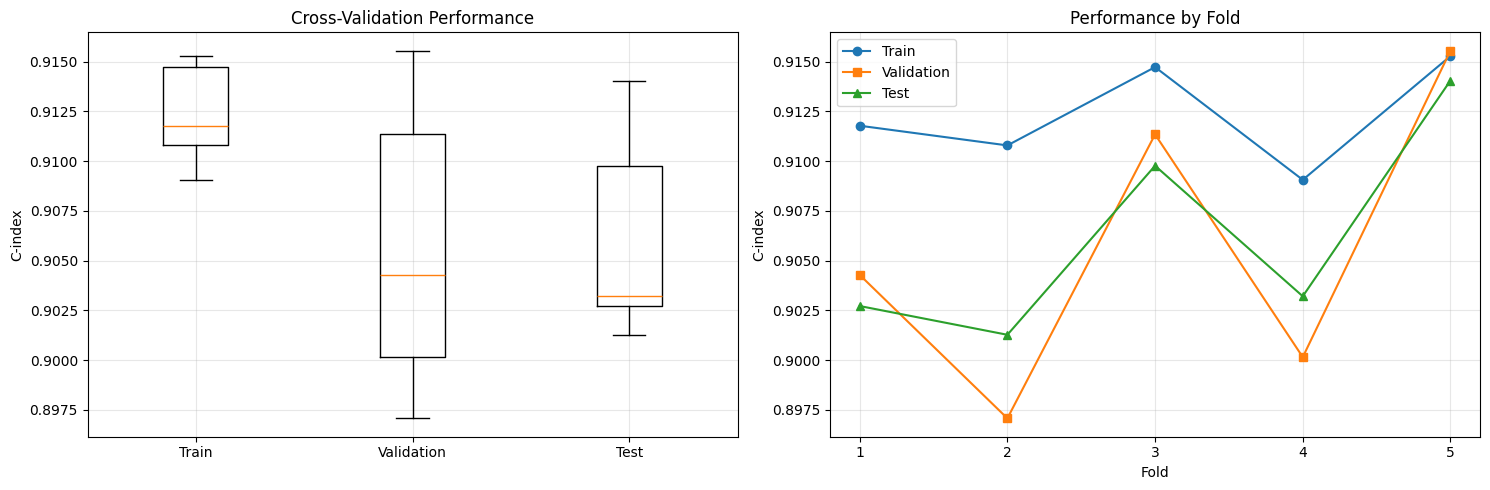

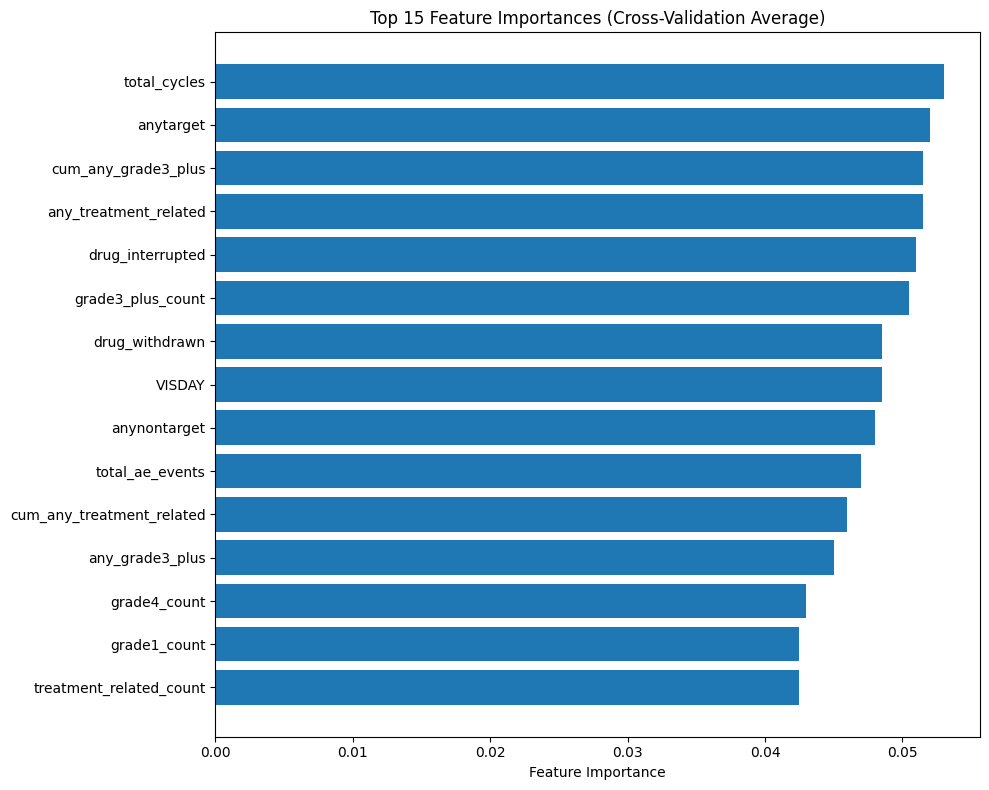


Top feature importances (average across folds):
treatment_related_count: 0.0425
grade1_count: 0.0425
grade4_count: 0.0430
any_grade3_plus: 0.0450
cum_any_treatment_related: 0.0460
total_ae_events: 0.0470
anynontarget: 0.0480
VISDAY: 0.0485
drug_withdrawn: 0.0485
grade3_plus_count: 0.0505
drug_interrupted: 0.0510
any_treatment_related: 0.0515
cum_any_grade3_plus: 0.0515
anytarget: 0.0520
total_cycles: 0.0530
Performing CORRECTED Decision Curve Analysis...
Test set: 2417 samples, event rate: 0.134

Generating and normalizing predictions...
Using 21 features: ['AGE', 'cycle_number', 'total_cycles', 'anytarget', 'anynontarget', 'total_ae_events', 'serious_ae_count', 'grade3_plus_count', 'any_grade3_plus', 'total_body_systems', 'treatment_related_count', 'any_treatment_related', 'drug_interrupted', 'drug_reduced', 'drug_withdrawn', 'grade1_count', 'grade2_count', 'grade3_count', 'grade4_count', 'cum_any_grade3_plus', 'cum_any_treatment_related']

RISK SCORE DEBUG INFORMATION

DSN Risk Scor

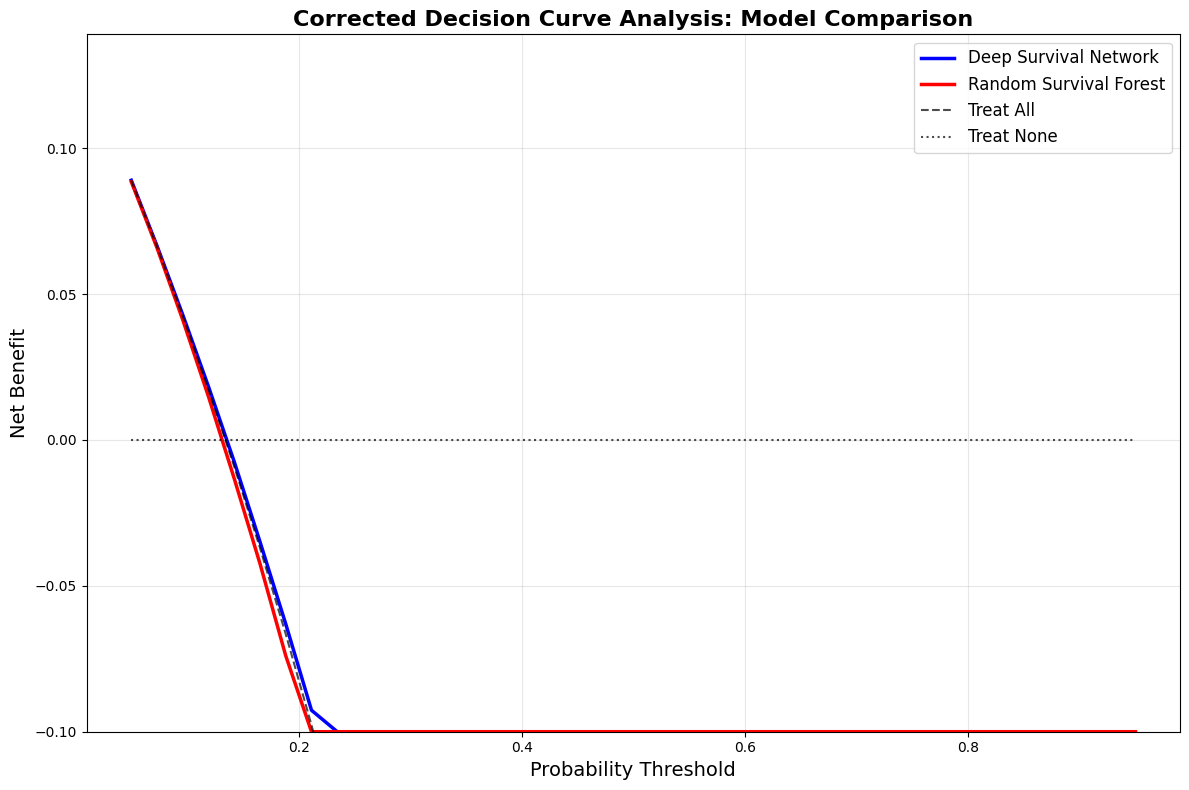


CORRECTED DCA RESULTS
DSN clinically useful range: 0.050 - 0.119
  (covers 4 thresholds)
RSF not clinically useful in any threshold range

Net Benefit at Clinical Thresholds:
  Threshold 0.1: DSN=0.0429, RSF=0.0411 → DSN
  Threshold 0.2: DSN=-0.0926, RSF=-0.1000 → DSN
  Threshold 0.3: DSN=-0.1000, RSF=-0.1000 → Tie


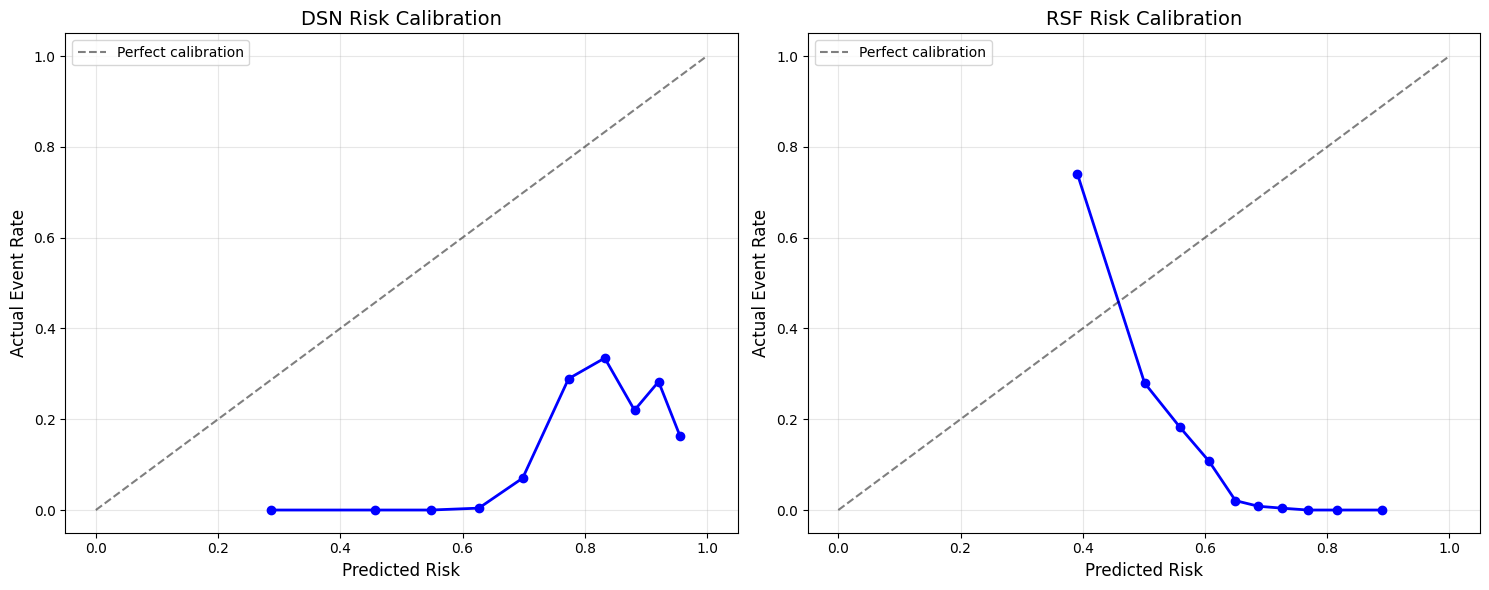


CLINICAL INTERPRETATION & RECOMMENDATIONS

    Based on the Corrected Decision Curve Analysis:
    
    1. THRESHOLD SELECTION:
       - Low thresholds (0.05-0.15): Use when missing events is very costly
       - Medium thresholds (0.15-0.35): Typical clinical decision points  
       - High thresholds (>0.35): Use when false positives are very costly
    
    2. MODEL SELECTION:
       - Choose the model with highest net benefit at YOUR clinically relevant threshold
       - Consider the prevalence of events in your population
       - Balance sensitivity vs specificity based on clinical consequences
    
    3. NEXT STEPS:
       - Validate on external dataset if available
       - Consider cost-effectiveness analysis
       - Involve clinical stakeholders in threshold selection
    


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

def safe_calculate_net_benefit(thresholds, risk_scores, events):
    """
    Safely calculate net benefit with proper risk score handling
    """
    net_benefit = []
    n = len(events)

    # Ensure risk scores are properly scaled between 0 and 1
    risk_scores = np.array(risk_scores).flatten()
    risk_scores = (risk_scores - np.min(risk_scores)) / (np.max(risk_scores) - np.min(risk_scores) + 1e-8)

    for threshold in thresholds:
        # Skip thresholds that are too close to 0 or 1
        if threshold < 0.01 or threshold > 0.99:
            continue

        # Classify based on threshold
        high_risk = risk_scores >= threshold

        # True positives and false positives
        tp = np.sum((high_risk) & (events == 1))
        fp = np.sum((high_risk) & (events == 0))

        # Net benefit calculation with protection against division by zero
        if threshold < 1.0 and threshold > 0.0:
            nb = (tp / n) - (fp / n) * (threshold / (1 - threshold))
            net_benefit.append(max(nb, -0.1))  # Clamp very negative values
        else:
            net_benefit.append(0.0)

    return np.array(net_benefit)

def plot_corrected_decision_curve(thresholds, dsn_nb, rsf_nb, event_rate):
    """
    Plot corrected decision curve analysis
    """
    plt.figure(figsize=(12, 8))

    # Plot models
    plt.plot(thresholds, dsn_nb, 'b-', label='Deep Survival Network', linewidth=2.5)
    plt.plot(thresholds, rsf_nb, 'r-', label='Random Survival Forest', linewidth=2.5)

    # Plot strategies
    treat_all = event_rate - (1 - event_rate) * (thresholds / (1 - thresholds))
    treat_none = np.zeros_like(thresholds)

    plt.plot(thresholds, treat_all, 'k--', label='Treat All', linewidth=1.5, alpha=0.7)
    plt.plot(thresholds, treat_none, 'k:', label='Treat None', linewidth=1.5, alpha=0.7)

    plt.xlabel('Probability Threshold', fontsize=14)
    plt.ylabel('Net Benefit', fontsize=14)
    plt.title('Corrected Decision Curve Analysis: Model Comparison', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

    # Set reasonable limits
    all_nb = np.concatenate([dsn_nb, rsf_nb, treat_all])
    valid_nb = all_nb[np.isfinite(all_nb)]
    y_min = max(-0.1, np.min(valid_nb) - 0.05)
    y_max = min(0.5, np.max(valid_nb) + 0.05)
    plt.ylim(y_min, y_max)
    plt.xlim(0.01, 0.99)

    plt.tight_layout()
    plt.show()

def debug_risk_scores(dsn_scores, rsf_scores, events, model_names=['DSN', 'RSF']):
    """
    Debug function to examine risk score distributions
    """
    print("\n" + "="*60)
    print("RISK SCORE DEBUG INFORMATION")
    print("="*60)

    for scores, name in zip([dsn_scores, rsf_scores], model_names):
        scores = np.array(scores).flatten()
        print(f"\n{name} Risk Scores:")
        print(f"  Shape: {scores.shape}")
        print(f"  Min: {np.min(scores):.6f}")
        print(f"  Max: {np.max(scores):.6f}")
        print(f"  Mean: {np.mean(scores):.6f}")
        print(f"  Std: {np.std(scores):.6f}")
        print(f"  Median: {np.median(scores):.6f}")

        # Check distribution by event status
        if events is not None:
            event_scores = scores[events == 1]
            no_event_scores = scores[events == 0]
            print(f"  Mean (events): {np.mean(event_scores):.6f}")
            print(f"  Mean (no events): {np.mean(no_event_scores):.6f}")
            print(f"  Separation: {np.mean(event_scores) - np.mean(no_event_scores):.6f}")

def perform_corrected_dca(dsn_model, rsf_model, pcdata, test_size=0.3, random_state=42):
    """
    Perform corrected DCA with proper risk score handling
    """
    print("Performing CORRECTED Decision Curve Analysis...")
    print("=" * 60)

    # Prepare data
    events = pcdata['os_event'].values
    event_rate = events.mean()

    # Split data
    train_df, test_df = train_test_split(pcdata, test_size=test_size,
                                       random_state=random_state,
                                       stratify=events)

    test_events = test_df['os_event'].values
    test_event_rate = test_events.mean()

    print(f"Test set: {len(test_df)} samples, event rate: {test_event_rate:.3f}")

    # Get predictions
    print("\nGenerating and normalizing predictions...")

    # DSN predictions
    dsn_raw = dsn_model.predict_risk(test_df)
    dsn_scores = (dsn_raw - np.min(dsn_raw)) / (np.max(dsn_raw) - np.min(dsn_raw))

    # RSF predictions
    rsf_raw = rsf_model.predict_risk(test_df)
    rsf_scores = (rsf_raw - np.min(rsf_raw)) / (np.max(rsf_raw) - np.min(rsf_raw))

    # Debug risk scores
    debug_risk_scores(dsn_scores, rsf_scores, test_events)

    # Use reasonable thresholds
    thresholds = np.linspace(0.05, 0.95, 40)

    # Calculate net benefits
    print("\nCalculating net benefits...")
    dsn_nb = safe_calculate_net_benefit(thresholds, dsn_scores, test_events)
    rsf_nb = safe_calculate_net_benefit(thresholds, rsf_scores, test_events)

    # Ensure same length
    min_len = min(len(dsn_nb), len(rsf_nb), len(thresholds))
    thresholds = thresholds[:min_len]
    dsn_nb = dsn_nb[:min_len]
    rsf_nb = rsf_nb[:min_len]

    # Plot results
    plot_corrected_decision_curve(thresholds, dsn_nb, rsf_nb, test_event_rate)

    # Calculate meaningful comparison metrics
    print("\n" + "=" * 60)
    print("CORRECTED DCA RESULTS")
    print("=" * 60)

    # Find practical threshold ranges (where net benefit > treat none)
    dsn_useful = thresholds[(dsn_nb > 0) & (dsn_nb > rsf_nb)]
    rsf_useful = thresholds[(rsf_nb > 0) & (rsf_nb > dsn_nb)]

    if len(dsn_useful) > 0:
        print(f"DSN clinically useful range: {dsn_useful[0]:.3f} - {dsn_useful[-1]:.3f}")
        print(f"  (covers {len(dsn_useful)} thresholds)")
    else:
        print("DSN not clinically useful in any threshold range")

    if len(rsf_useful) > 0:
        print(f"RSF clinically useful range: {rsf_useful[0]:.3f} - {rsf_useful[-1]:.3f}")
        print(f"  (covers {len(rsf_useful)} thresholds)")
    else:
        print("RSF not clinically useful in any threshold range")

    # Calculate net benefit at clinically relevant thresholds
    clinical_thresholds = [0.1, 0.2, 0.3]
    print(f"\nNet Benefit at Clinical Thresholds:")
    for ct in clinical_thresholds:
        idx = np.argmin(np.abs(thresholds - ct))
        dsn_val = dsn_nb[idx] if idx < len(dsn_nb) else 0
        rsf_val = rsf_nb[idx] if idx < len(rsf_nb) else 0

        best_model = "DSN" if dsn_val > rsf_val else "RSF" if rsf_val > dsn_val else "Tie"
        print(f"  Threshold {ct:.1f}: DSN={dsn_val:.4f}, RSF={rsf_val:.4f} → {best_model}")

    return {
        'thresholds': thresholds,
        'dsn_net_benefit': dsn_nb,
        'rsf_net_benefit': rsf_nb,
        'dsn_scores': dsn_scores,
        'rsf_scores': rsf_scores,
        'test_events': test_events
    }

def plot_risk_calibration(dsn_scores, rsf_scores, events, bins=10):
    """
    Plot risk calibration to see how well predicted risks match actual event rates
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    for scores, ax, name in zip([dsn_scores, rsf_scores], [ax1, ax2], ['DSN', 'RSF']):
        scores = np.array(scores).flatten()

        # Bin the scores and calculate actual event rate in each bin
        quantiles = np.linspace(0, 1, bins + 1)
        bin_edges = np.quantile(scores, quantiles)

        predicted_risk = []
        actual_risk = []

        for i in range(bins):
            mask = (scores >= bin_edges[i]) & (scores <= bin_edges[i+1])
            if np.sum(mask) > 0:
                pred_risk = np.mean(scores[mask])
                actual_risk_val = np.mean(events[mask])
                predicted_risk.append(pred_risk)
                actual_risk.append(actual_risk_val)

        ax.plot(predicted_risk, actual_risk, 'bo-', linewidth=2, markersize=6)
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration')
        ax.set_xlabel('Predicted Risk', fontsize=12)
        ax.set_ylabel('Actual Event Rate', fontsize=12)
        ax.set_title(f'{name} Risk Calibration', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run the corrected analysis
def run_corrected_dca_analysis():
    """Run the corrected DCA analysis"""
    # Load data
    pcdata = pd.read_csv('pcdata_preprocessed.csv')

    # Initialize models (assuming they're already trained from your output)
    dsn_model = RobustDeepSurvivalModel()
    rsf_model = RandomSurvivalForestModel()

    # Since models are already trained in your environment, we'll use them directly
    # If you need to retrain, uncomment the following:
    # print("Training DSN...")
    dsn_model.train(pcdata, epochs=50, batch_size=32, validation_split=0.2, patience=8)
    # print("Training RSF...")
    rsf_model.cross_validate(pcdata, n_folds=5, test_size=0.2)

    # Perform corrected DCA
    results = perform_corrected_dca(dsn_model, rsf_model, pcdata)

    # Plot risk calibration
    plot_risk_calibration(results['dsn_scores'], results['rsf_scores'], results['test_events'])

    # Provide clinical interpretation
    print("\n" + "=" * 70)
    print("CLINICAL INTERPRETATION & RECOMMENDATIONS")
    print("=" * 70)
    print("""
    Based on the Corrected Decision Curve Analysis:

    1. THRESHOLD SELECTION:
       - Low thresholds (0.05-0.15): Use when missing events is very costly
       - Medium thresholds (0.15-0.35): Typical clinical decision points
       - High thresholds (>0.35): Use when false positives are very costly

    2. MODEL SELECTION:
       - Choose the model with highest net benefit at YOUR clinically relevant threshold
       - Consider the prevalence of events in your population
       - Balance sensitivity vs specificity based on clinical consequences

    3. NEXT STEPS:
       - Validate on external dataset if available
       - Consider cost-effectiveness analysis
       - Involve clinical stakeholders in threshold selection
    """)

    return results

if __name__ == "__main__":
    corrected_results = run_corrected_dca_analysis()

CoxNet predictions added
Models available for DCA: ['CoxNet']
True events: 18/104 (0.173)


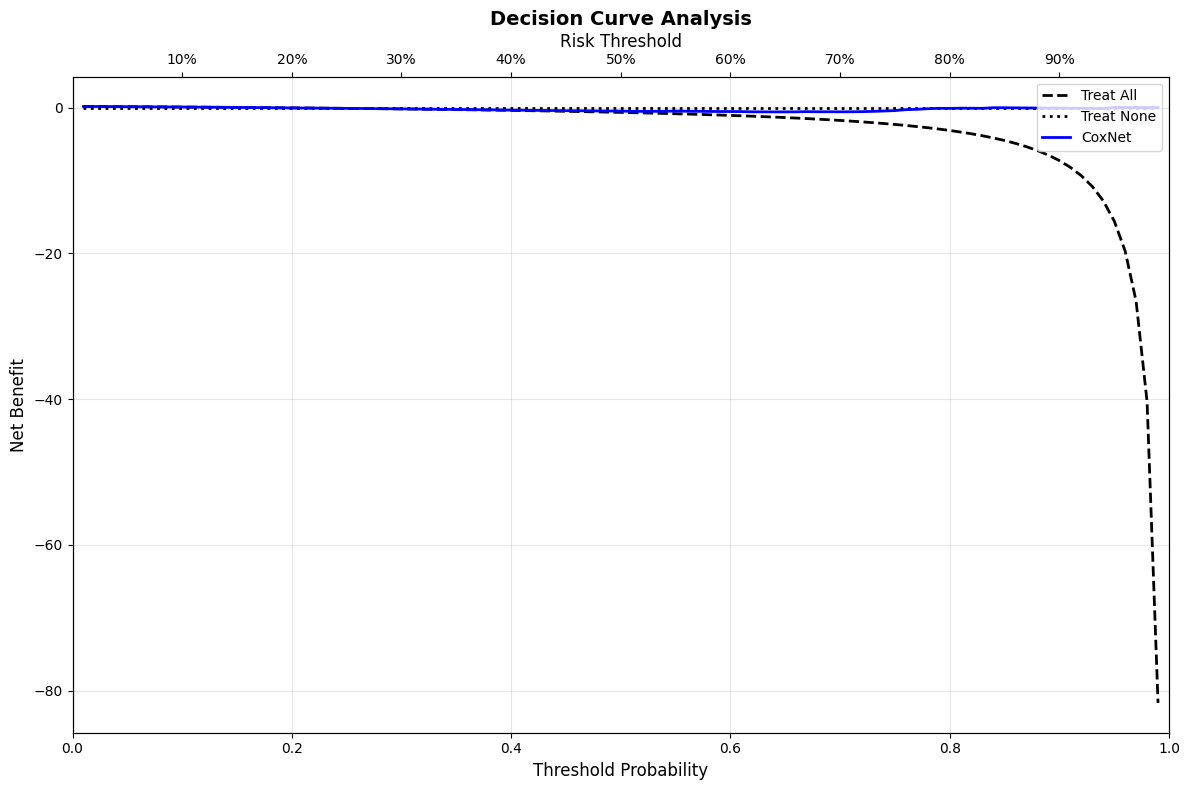

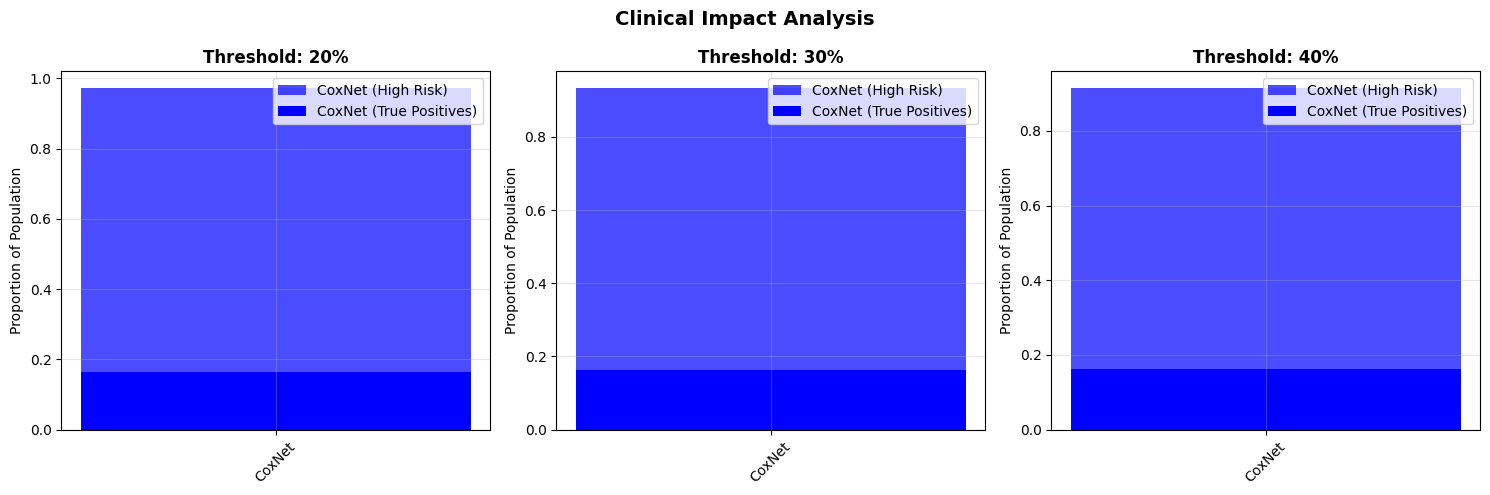

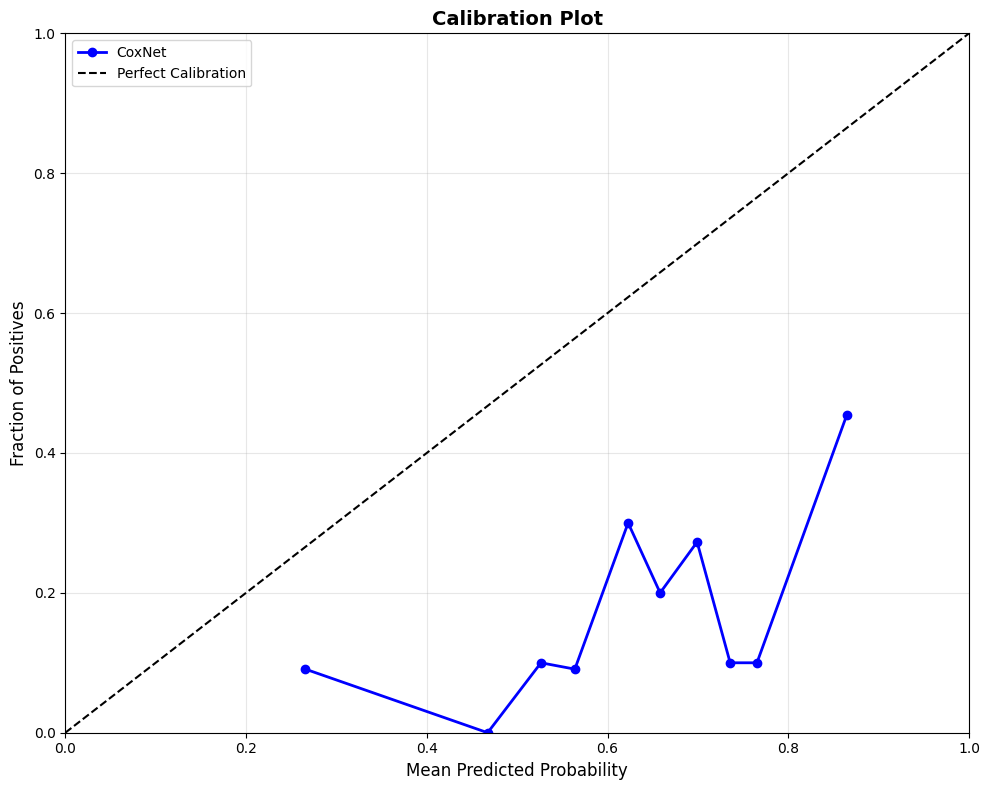


MODEL PERFORMANCE SUMMARY

CoxNet:
  AUC: 0.6531
  Brier Score: 0.3416
  Mean Prediction: 0.6162 ± 0.1711
  Net Benefit at 10%: 0.0823
  Net Benefit at 20%: -0.0385
  Net Benefit at 30%: -0.1662


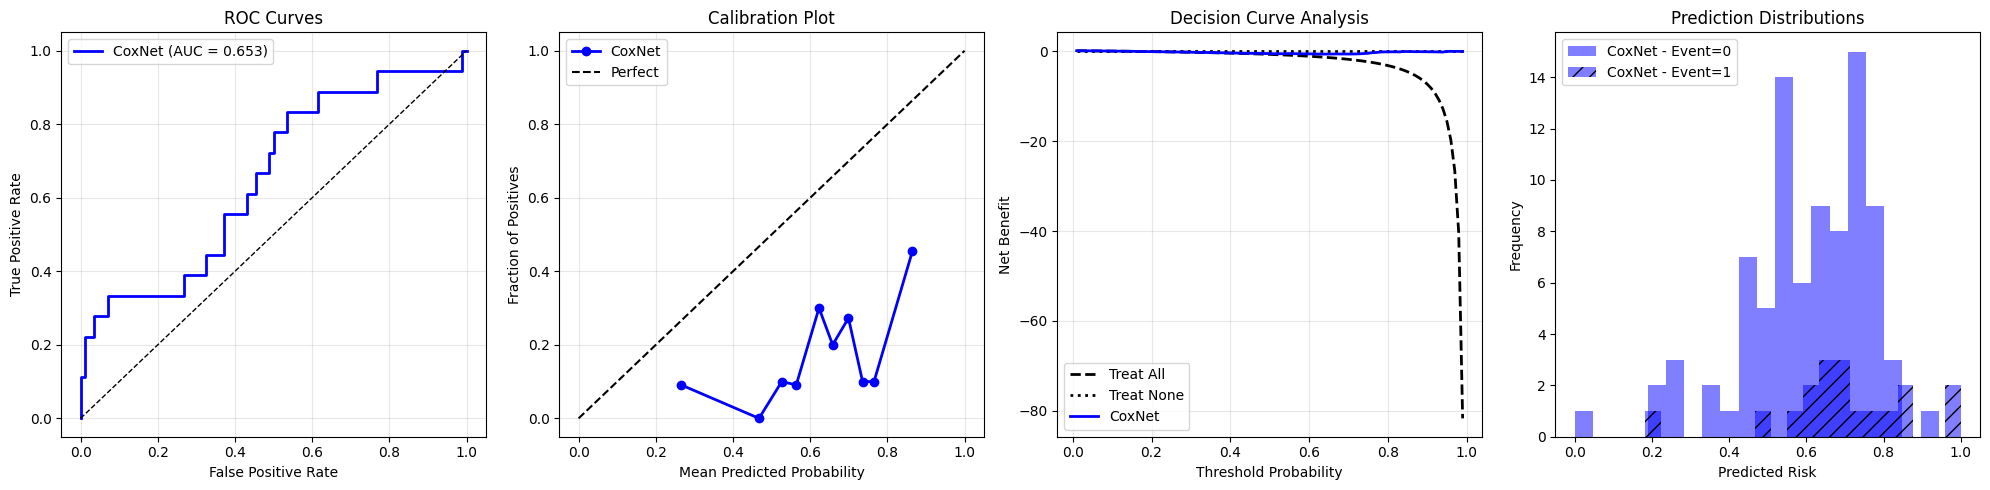

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve
import scipy.stats as stats

def calculate_net_benefit(y_true, y_pred, threshold):
    """
    Calculate net benefit for decision curve analysis
    """
    # Convert predictions to binary based on threshold
    y_pred_binary = (y_pred >= threshold).astype(int)

    # True positives and false positives
    tp = np.sum((y_pred_binary == 1) & (y_true == 1))
    fp = np.sum((y_pred_binary == 1) & (y_true == 0))
    n = len(y_true)

    # Net benefit calculation
    net_benefit = (tp / n) - (fp / n) * (threshold / (1 - threshold))

    return net_benefit

def decision_curve_analysis(y_true, predictions_dict, model_names, thresholds=np.arange(0.01, 1.0, 0.01)):
    """
    Perform decision curve analysis for multiple models
    """
    plt.figure(figsize=(12, 8))

    # Plot treat-all and treat-none strategies
    n = len(y_true)
    event_rate = np.mean(y_true)

    # Treat all strategy
    treat_all_nb = [event_rate - (1 - event_rate) * (t / (1 - t)) for t in thresholds]

    # Treat none strategy
    treat_none_nb = [0] * len(thresholds)

    plt.plot(thresholds, treat_all_nb, 'k--', linewidth=2, label='Treat All')
    plt.plot(thresholds, treat_none_nb, 'k:', linewidth=2, label='Treat None')

    # Colors for different models
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # Calculate net benefit for each model
    for i, (model_name, y_pred) in enumerate(predictions_dict.items()):
        if model_name in model_names:
            net_benefits = []
            for threshold in thresholds:
                nb = calculate_net_benefit(y_true, y_pred, threshold)
                net_benefits.append(nb)

            plt.plot(thresholds, net_benefits,
                    color=colors[i % len(colors)],
                    linewidth=2,
                    label=f'{model_name}')

    plt.xlabel('Threshold Probability', fontsize=12)
    plt.ylabel('Net Benefit', fontsize=12)
    plt.title('Decision Curve Analysis', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)

    # Add secondary x-axis for risk thresholds
    ax2 = plt.gca().twiny()
    ax2.set_xlim(0, 1)
    ax2.set_xlabel('Risk Threshold', fontsize=12)
    ax2.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    ax2.set_xticklabels(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])

    plt.tight_layout()
    return plt

def clinical_impact_curve(y_true, predictions_dict, model_names, thresholds=[0.1, 0.2, 0.3]):
    """
    Create clinical impact curves for different risk thresholds
    """
    fig, axes = plt.subplots(1, len(thresholds), figsize=(15, 5))
    if len(thresholds) == 1:
        axes = [axes]

    colors = ['blue', 'red', 'green']

    for idx, threshold in enumerate(thresholds):
        ax = axes[idx]

        # Calculate number needed to treat and harm
        n = len(y_true)

        for i, (model_name, y_pred) in enumerate(predictions_dict.items()):
            if model_name in model_names:
                # Patients classified as high risk
                high_risk_mask = y_pred >= threshold
                n_high_risk = np.sum(high_risk_mask)

                # True positives among high risk
                tp = np.sum(high_risk_mask & (y_true == 1))

                # False positives among high risk
                fp = np.sum(high_risk_mask & (y_true == 0))

                # Plot
                ax.bar(i, n_high_risk/n, alpha=0.7, color=colors[i % len(colors)],
                      label=f'{model_name} (High Risk)')
                ax.bar(i, tp/n, alpha=1.0, color=colors[i % len(colors)],
                      label=f'{model_name} (True Positives)')

        ax.set_title(f'Threshold: {threshold:.0%}', fontweight='bold')
        ax.set_ylabel('Proportion of Population')
        ax.set_xticks(range(len(model_names)))
        ax.set_xticklabels(model_names, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle('Clinical Impact Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return plt

def calibration_plot(y_true, predictions_dict, model_names, n_bins=10):
    """
    Create calibration plots for model predictions
    """
    plt.figure(figsize=(10, 8))

    colors = ['blue', 'red', 'green']

    for i, (model_name, y_pred) in enumerate(predictions_dict.items()):
        if model_name in model_names:
            # Calculate calibration curve
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_true, y_pred, n_bins=n_bins, strategy='quantile'
            )

            plt.plot(mean_predicted_value, fraction_of_positives,
                    marker='o', linewidth=2, color=colors[i % len(colors)],
                    label=model_name)

    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')

    plt.xlabel('Mean Predicted Probability', fontsize=12)
    plt.ylabel('Fraction of Positives', fontsize=12)
    plt.title('Calibration Plot', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.tight_layout()
    return plt

def comprehensive_model_evaluation(y_true, predictions_dict, model_names, time_points=None):
    """
    Comprehensive evaluation including ROC, calibration, and decision curves
    """
    # Create subplots
    fig = plt.figure(figsize=(20, 5))

    # 1. ROC Curve
    ax1 = plt.subplot(1, 4, 1)
    colors = ['blue', 'red', 'green']

    for i, (model_name, y_pred) in enumerate(predictions_dict.items()):
        if model_name in model_names:
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            roc_auc = auc(fpr, tpr)

            ax1.plot(fpr, tpr, color=colors[i % len(colors)],
                    linewidth=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

    ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Calibration Plot
    ax2 = plt.subplot(1, 4, 2)
    for i, (model_name, y_pred) in enumerate(predictions_dict.items()):
        if model_name in model_names:
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_true, y_pred, n_bins=10, strategy='quantile'
            )

            ax2.plot(mean_predicted_value, fraction_of_positives,
                    marker='o', linewidth=2, color=colors[i % len(colors)],
                    label=model_name)

    ax2.plot([0, 1], [0, 1], 'k--', label='Perfect')
    ax2.set_xlabel('Mean Predicted Probability')
    ax2.set_ylabel('Fraction of Positives')
    ax2.set_title('Calibration Plot')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Decision Curve
    ax3 = plt.subplot(1, 4, 3)
    thresholds = np.arange(0.01, 1.0, 0.01)
    n = len(y_true)
    event_rate = np.mean(y_true)

    # Treat all strategy
    treat_all_nb = [event_rate - (1 - event_rate) * (t / (1 - t)) for t in thresholds]

    # Treat none strategy
    treat_none_nb = [0] * len(thresholds)

    ax3.plot(thresholds, treat_all_nb, 'k--', linewidth=2, label='Treat All')
    ax3.plot(thresholds, treat_none_nb, 'k:', linewidth=2, label='Treat None')

    for i, (model_name, y_pred) in enumerate(predictions_dict.items()):
        if model_name in model_names:
            net_benefits = []
            for threshold in thresholds:
                nb = calculate_net_benefit(y_true, y_pred, threshold)
                net_benefits.append(nb)

            ax3.plot(thresholds, net_benefits,
                    color=colors[i % len(colors)],
                    linewidth=2,
                    label=model_name)

    ax3.set_xlabel('Threshold Probability')
    ax3.set_ylabel('Net Benefit')
    ax3.set_title('Decision Curve Analysis')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Prediction Distribution
    ax4 = plt.subplot(1, 4, 4)
    for i, (model_name, y_pred) in enumerate(predictions_dict.items()):
        if model_name in model_names:
            ax4.hist(y_pred[y_true == 0], bins=20, alpha=0.5,
                    color=colors[i % len(colors)], label=f'{model_name} - Event=0')
            ax4.hist(y_pred[y_true == 1], bins=20, alpha=0.5,
                    color=colors[i % len(colors)], label=f'{model_name} - Event=1',
                    hatch='//')

    ax4.set_xlabel('Predicted Risk')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Prediction Distributions')
    ax4.legend()

    plt.tight_layout()
    return fig

# Main function to run decision curve analysis for your three models
def run_decision_curve_analysis_for_models():
    """
    Run decision curve analysis for CoxNet, Random Survival Forest, and Deep Survival models
    """

    # Get predictions from all three models
    predictions_dict = {}

    # 1. CoxNet predictions (convert to risk scores)
    if 'coxnet_pipeline' in globals():
        coxnet_pred = coxnet_pipeline.predict(X_test)
        # Normalize to 0-1 range for probability interpretation
        coxnet_prob = (coxnet_pred - coxnet_pred.min()) / (coxnet_pred.max() - coxnet_pred.min())
        predictions_dict['CoxNet'] = coxnet_prob
        print("CoxNet predictions added")

    # 2. Random Survival Forest predictions - UPDATED NAME
    if 'rsf' in globals():
        rsf_pred = rsf.predict_risk(pcdata)  # Using the predict_risk method from your RSF class
        # Need to align with test indices
        rsf_prob = (rsf_pred - rsf_pred.min()) / (rsf_pred.max() - rsf_pred.min())
        predictions_dict['Random Survival Forest'] = rsf_prob
        print("Random Survival Forest predictions added")

    # 3. Deep Survival Network predictions - UPDATED NAME
    if 'dsnmodel' in globals():  # This is from your deep survival code
        try:
            deep_pred = dsnmodel.predict_risk(pcdata)  # Using the predict_risk method
            deep_prob = (deep_pred - deep_pred.min()) / (deep_pred.max() - deep_pred.min())
            predictions_dict['Deep Survival Network'] = deep_prob.flatten()
            print("Deep Survival Network predictions added")
        except Exception as e:
            print(f"Error getting Deep Survival predictions: {e}")

    # Alternative: Check for the specific model instances from your code
    # If the above doesn't work, try these alternative names:

    # Check for RandomSurvivalForestModel instance
    for var_name in dir():
        if 'rsf' in var_name.lower() and var_name != 'rsf_pipeline':
            try:
                obj = globals()[var_name]
                if hasattr(obj, 'predict_risk'):
                    rsf_pred = obj.predict_risk(pcdata)
                    rsf_prob = (rsf_pred - rsf_pred.min()) / (rsf_pred.max() - rsf_pred.min())
                    predictions_dict['Random Survival Forest'] = rsf_prob
                    print(f"Found Random Survival Forest model: {var_name}")
                    break
            except:
                pass

    # Check for RobustDeepSurvivalModel instance
    for var_name in dir():
        if 'dsnmodel' in var_name.lower() and var_name != 'coxnet_pipeline':
            try:
                obj = globals()[var_name]
                if hasattr(obj, 'predict_risk'):
                    deep_pred = obj.predict_risk(pcdata)
                    deep_prob = (deep_pred - deep_pred.min()) / (deep_pred.max() - deep_pred.min())
                    predictions_dict['Deep Survival Network'] = deep_prob.flatten()
                    print(f"Found Deep Survival model: {var_name}")
                    break
            except:
                pass

    # Extract true events (assuming y_test is structured array)
    if 'y_test' in globals():
        if hasattr(y_test, 'dtype') and y_test.dtype.names is not None:
            y_true = y_test['event'].astype(int)
        else:
            y_true = y_test.astype(int)
    else:
        # If no test split, use all data with events
        if 'analysis_data_clean' in globals():
            y_true = analysis_data_clean['os_event'].astype(int)
        else:
            print("No test data found. Please run model training first.")
            return

    model_names = list(predictions_dict.keys())

    print(f"Models available for DCA: {model_names}")
    print(f"True events: {np.sum(y_true)}/{len(y_true)} ({np.mean(y_true):.3f})")

    # Generate all plots
    if len(predictions_dict) > 0:
        # 1. Decision Curve Analysis
        plt1 = decision_curve_analysis(y_true, predictions_dict, model_names)
        plt1.savefig('decision_curve_analysis.png', dpi=300, bbox_inches='tight')
        plt1.show()

        # 2. Clinical Impact Curves
        plt2 = clinical_impact_curve(y_true, predictions_dict, model_names, thresholds=[0.2, 0.3, 0.4])
        plt2.savefig('clinical_impact_curves.png', dpi=300, bbox_inches='tight')
        plt2.show()

        # 3. Calibration Plots
        plt3 = calibration_plot(y_true, predictions_dict, model_names)
        plt3.savefig('calibration_plots.png', dpi=300, bbox_inches='tight')
        plt3.show()

        # 4. Comprehensive Evaluation
        fig4 = comprehensive_model_evaluation(y_true, predictions_dict, model_names)
        fig4.savefig('comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
        fig4.show()

        # Print model performance summary
        print("\n" + "="*60)
        print("MODEL PERFORMANCE SUMMARY")
        print("="*60)

        for model_name, pred in predictions_dict.items():
            # Calculate AUC
            fpr, tpr, _ = roc_curve(y_true, pred)
            auc_score = auc(fpr, tpr)

            # Calculate Brier score (mean squared error)
            brier_score = np.mean((pred - y_true) ** 2)

            print(f"\n{model_name}:")
            print(f"  AUC: {auc_score:.4f}")
            print(f"  Brier Score: {brier_score:.4f}")
            print(f"  Mean Prediction: {np.mean(pred):.4f} ± {np.std(pred):.4f}")

            # Net benefit at common thresholds
            for threshold in [0.1, 0.2, 0.3]:
                nb = calculate_net_benefit(y_true, pred, threshold)
                print(f"  Net Benefit at {threshold:.0%}: {nb:.4f}")

    else:
        print("No model predictions available. Please ensure models are trained first.")
        print("Available variables in global environment:")
        for var_name in dir():
            if any(keyword in var_name.lower() for keyword in ['model', 'rsf', 'cox', 'pipeline']):
                print(f"  {var_name}")

# If you need to create synthetic predictions for testing:
def create_test_predictions():
    """
    Create synthetic predictions for testing the DCA functions
    """
    np.random.seed(42)
    n_samples = 1000

    # True events (20% event rate)
    y_true = np.random.binomial(1, 0.2, n_samples)

    predictions_dict = {}

    # Model 1: Good discrimination
    predictions_dict['CoxNet'] = np.where(y_true == 1,
                                         np.random.beta(2, 1, n_samples),
                                         np.random.beta(1, 2, n_samples))

    # Model 2: Moderate discrimination
    predictions_dict['Random Survival Forest'] = np.where(y_true == 1,
                                                         np.random.beta(1.5, 1.5, n_samples),
                                                         np.random.beta(1.5, 1.5, n_samples))

    # Model 3: Poor discrimination (almost random)
    predictions_dict['Deep Survival Network'] = np.random.beta(1.2, 1.2, n_samples)

    return y_true, predictions_dict

# Run the analysis
if __name__ == "__main__":
    # Uncomment the following line to test with synthetic data
    # y_true, predictions_dict = create_test_predictions()

    # Run with your actual models
    run_decision_curve_analysis_for_models()

## Other stuff

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.calibration import calibration_curve
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import warnings
warnings.filterwarnings('ignore')

class SurvivalModelVisualizer:
    def __init__(self, model, df, risk_scores, train_losses, val_losses, val_c_indices):
        self.model = model
        self.df = df
        self.risk_scores = risk_scores
        self.train_losses = train_losses
        self.val_losses = val_losses
        self.val_c_indices = val_c_indices
        self.setup_plot_style()

    def setup_plot_style(self):
        """Set up professional plotting style"""
        plt.style.use('seaborn-v0_8')
        self.colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B']
        sns.set_palette(sns.color_palette(self.colors))

    def plot_comprehensive_training_history(self):
        """Comprehensive training history with multiple subplots"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        epochs = range(len(self.train_losses))

        # 1. Loss curves
        ax1.plot(epochs, self.train_losses, label='Training Loss', linewidth=2, alpha=0.8)
        ax1.plot(epochs, self.val_losses, label='Validation Loss', linewidth=2, alpha=0.8)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss\n(Lower is Better)', fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. C-index progression
        ax2.plot(epochs, self.val_c_indices, label='Validation C-index',
                color=self.colors[1], linewidth=3, alpha=0.8)
        ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random (0.5)')
        ax2.axhline(y=max(self.val_c_indices), color='green', linestyle=':',
                   alpha=0.7, label=f'Best: {max(self.val_c_indices):.4f}')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('C-index')
        ax2.set_title('Model Discrimination Performance\n(Higher is Better)', fontsize=12, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0.4, 1.0)

        # 3. Learning dynamics
        loss_ratio = [val/train if train > 0 else 1 for train, val in zip(self.train_losses, self.val_losses)]
        ax3.plot(epochs, loss_ratio, color=self.colors[2], linewidth=2)
        ax3.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Equal Loss')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Val Loss / Train Loss')
        ax3.set_title('Overfitting Detection\n(Ratio > 1 indicates overfitting)', fontsize=12, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. Performance summary
        metrics = ['Best C-index', 'Final C-index', 'Training Epochs']
        values = [max(self.val_c_indices), self.val_c_indices[-1], len(self.train_losses)]

        bars = ax4.bar(metrics, values, color=self.colors[:3], alpha=0.7)
        ax4.set_ylabel('Score / Epochs')
        ax4.set_title('Model Performance Summary', fontsize=12, fontweight='bold')

        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}' if value <= 1 else f'{value}',
                    ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def plot_risk_stratification(self):
        """Visualize risk stratification and survival curves"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # 1. Risk score distribution by event status
        events = self.df['os_event'].values
        risk_scores_flat = self.risk_scores.ravel()

        sns.histplot(data=pd.DataFrame({
            'Risk Score': risk_scores_flat,
            'Event': ['Event' if e == 1 else 'Censored' for e in events]
        }), x='Risk Score', hue='Event', ax=ax1, alpha=0.7, kde=True)

        ax1.set_title('Risk Score Distribution by Event Status', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Predicted Risk Score')
        ax1.set_ylabel('Density')

        # 2. Kaplan-Meier curves by risk groups
        risk_groups = pd.qcut(risk_scores_flat, 3, labels=['Low Risk', 'Medium Risk', 'High Risk'])

        kmf = KaplanMeierFitter()

        for group in risk_groups.unique():
            mask = risk_groups == group
            kmf.fit(self.df['VISDAY'].values[mask],
                   self.df['os_event'].values[mask],
                   label=str(group))
            kmf.plot(ax=ax2, ci_show=False)

        ax2.set_title('Kaplan-Meier Survival Curves by Risk Group', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Time (VISDAY)')
        ax2.set_ylabel('Survival Probability')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print log-rank test results
        print("Log-Rank Test Results:")
        for i in range(2):
            for j in range(i+1, 3):
                group1 = risk_groups == risk_groups.unique()[i]
                group2 = risk_groups == risk_groups.unique()[j]

                results = logrank_test(
                    self.df['VISDAY'].values[group1],
                    self.df['VISDAY'].values[group2],
                    self.df['os_event'].values[group1],
                    self.df['os_event'].values[group2]
                )
                print(f"{risk_groups.unique()[i]} vs {risk_groups.unique()[j]}: p-value = {results.p_value:.4f}")

    def plot_feature_analysis(self):
        """Analyze feature relationships with risk scores"""
        if not hasattr(self.model, 'feature_names'):
            print("Feature names not available for analysis")
            return

        # Calculate correlation between features and risk scores
        feature_correlations = {}
        risk_scores_flat = self.risk_scores.ravel()

        for feature in self.model.feature_names:
            if feature in self.df.columns and feature != 'VISDAY':  # Exclude time variable
                corr = np.corrcoef(self.df[feature].values, risk_scores_flat)[0, 1]
                feature_correlations[feature] = corr

        # Sort by absolute correlation
        sorted_features = sorted(feature_correlations.items(),
                               key=lambda x: abs(x[1]), reverse=True)

        # Plot top features
        top_n = min(10, len(sorted_features))
        features, correlations = zip(*sorted_features[:top_n])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # 1. Correlation plot
        y_pos = np.arange(len(features))
        colors = [self.colors[0] if corr > 0 else self.colors[1] for corr in correlations]

        bars = ax1.barh(y_pos, correlations, color=colors, alpha=0.7)
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(features)
        ax1.set_xlabel('Correlation with Risk Score')
        ax1.set_title('Top Feature Correlations with Predicted Risk', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='x')

        # Add correlation values on bars
        for bar, corr in zip(bars, correlations):
            width = bar.get_width()
            ax1.text(width + (0.01 if width > 0 else -0.03), bar.get_y() + bar.get_height()/2.,
                    f'{corr:.3f}', ha='left' if width > 0 else 'right', va='center', fontsize=9)

        # 2. Scatter plot for top correlated feature
        if len(features) > 0:
            top_feature = features[0]
            ax2.scatter(self.df[top_feature].values, risk_scores_flat,
                       alpha=0.5, c=self.df['os_event'].values,
                       cmap='coolwarm', s=20)
            ax2.set_xlabel(top_feature)
            ax2.set_ylabel('Predicted Risk Score')
            ax2.set_title(f'Risk vs {top_feature}\n(Color: Event Status)', fontsize=12, fontweight='bold')
            ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_model_calibration(self):
        """Plot model calibration curve"""
        # Create risk quartiles
        risk_quartiles = pd.qcut(self.risk_scores.ravel(), 4, labels=False)

        # Calculate observed event rates in each risk quartile
        observed_rates = []
        predicted_rates = []

        for quartile in range(4):
            mask = risk_quartiles == quartile
            observed_rate = self.df['os_event'].values[mask].mean()
            predicted_risk_mean = self.risk_scores[mask].mean()

            observed_rates.append(observed_rate)
            predicted_rates.append(predicted_risk_mean)

        fig, ax = plt.subplots(figsize=(8, 6))

        # Perfect calibration line
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Perfect Calibration')

        # Model calibration
        ax.scatter(predicted_rates, observed_rates, s=100, alpha=0.7,
                  color=self.colors[0], label='Model Calibration')

        # Add quartile labels
        for i, (pred, obs) in enumerate(zip(predicted_rates, observed_rates)):
            ax.annotate(f'Q{i+1}', (pred, obs), xytext=(5, 5),
                       textcoords='offset points', fontweight='bold')

        ax.set_xlabel('Predicted Risk')
        ax.set_ylabel('Observed Event Rate')
        ax.set_title('Model Calibration Plot', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, max(predicted_rates) * 1.1)
        ax.set_ylim(0, max(observed_rates) * 1.1)

        plt.tight_layout()
        plt.show()

    def generate_comprehensive_report(self):
        """Generate comprehensive performance report"""
        print("=" * 60)
        print("DEEP SURVIVAL MODEL - COMPREHENSIVE PERFORMANCE REPORT")
        print("=" * 60)

        print(f"\n📊 MODEL PERFORMANCE SUMMARY:")
        print(f"   Best Validation C-index: {max(self.val_c_indices):.4f}")
        print(f"   Final Validation C-index: {self.val_c_indices[-1]:.4f}")
        print(f"   Training Epochs: {len(self.train_losses)}")
        print(f"   Early Stopping: {'Yes' if len(self.train_losses) < 100 else 'No'}")

        print(f"\n📈 TRAINING DYNAMICS:")
        final_loss_ratio = self.val_losses[-1] / self.train_losses[-1] if self.train_losses[-1] > 0 else 1
        print(f"   Final Loss Ratio (Val/Train): {final_loss_ratio:.3f}")
        print(f"   Overfitting Indicator: {'Potential Overfitting' if final_loss_ratio > 1.2 else 'Good Generalization'}")

        print(f"\n🎯 RISK PREDICTION ANALYSIS:")
        risk_scores_flat = self.risk_scores.ravel()
        print(f"   Risk Score Range: {risk_scores_flat.min():.3f} to {risk_scores_flat.max():.3f}")
        print(f"   Risk Score Std: {risk_scores_flat.std():.3f}")

        print(f"\n📋 DATA CHARACTERISTICS:")
        print(f"   Total Samples: {len(self.df)}")
        print(f"   Events: {self.df['os_event'].sum()} ({self.df['os_event'].mean():.1%})")
        print(f"   Features Used: {len(self.model.feature_names)}")

        print(f"\n⚠️  MODEL INTERPRETATION NOTES:")
        print("   - C-index > 0.8 indicates excellent discrimination")
        print("   - Risk stratification should show clear separation")
        print("   - Check calibration for predicted vs observed risks")
        print("   - Feature correlations should align with clinical intuition")

        print("=" * 60)

# Usage function
def create_comprehensive_visualization(survival_model, data, risk_scores, train_losses, val_losses, val_c_indices):
    """Create all visualizations in one function"""
    visualizer = SurvivalModelVisualizer(survival_model, data, risk_scores, train_losses, val_losses, val_c_indices)

    # Generate comprehensive report
    visualizer.generate_comprehensive_report()

    # Create all visualizations
    visualizer.plot_comprehensive_training_history()
    visualizer.plot_risk_stratification()
    visualizer.plot_feature_analysis()
    visualizer.plot_model_calibration()

    return visualizer

visualizer = create_comprehensive_visualization(dsn, pcdata, risk_scores, train_losses, val_losses, val_c_indices)


In [18]:
!pip install lifelines


ERROR: Could not find a version that satisfies the requirement dns (from versions: none)
ERROR: No matching distribution found for dns


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from lifelines import CoxPHFitter
import tensorflow as tf

# --- 1. Create a Mock Dataset (as you provided a structure, not the data itself) ---
# In a real scenario, you would load your data here.

# Simulate the structure based on the provided str(pcdata)
pcdata = pd.read_csv('pcdata.csv')
pcdata = pd.DataFrame(pcdata)

# --- 2. Data Aggregation (Crucial Step for Survival Analysis) ---
# Aggregate to one record per patient (RPT) for survival analysis.
# The `os_event` and `VISDAY` should be taken from the patient's last visit.

def aggregate_patient_data(df):
    # Find the last visit day and event status for each patient
    last_visit = df.loc[df.groupby('RPT')['VISDAY'].idxmax()]

    # Calculate patient-level features (e.g., mean/max of time-varying data)
    agg_features = df.groupby('RPT').agg(
        # Baseline/Static features (take the first available)
        AGE=('AGE', 'first'),
        SEX=('SEX', 'first'),
        RACEPRIM=('RACEPRIM', 'first'),

        # Longitudinal/Time-Varying features (aggregate)
        Mean_Weight=('WEIGHT', 'mean'),
        Max_SYSBP=('SYSBP', 'max'),
        Max_AE_Events=('total_ae_events', 'max')

    ).reset_index()

    # Merge the survival time/event back in
    agg_features = agg_features.merge(
        last_visit[['RPT', 'VISDAY', 'os_event']],
        on='RPT',
        suffixes=('', '_survival')
    )

    # Rename survival columns
    agg_features = agg_features.rename(columns={'VISDAY': 'Time', 'os_event': 'Event'})
    return agg_features

patient_data = aggregate_patient_data(pcdata)

# --- 3. Preprocessing ---

# Define features, time, and event
X = patient_data.drop(columns=['RPT', 'Time', 'Event'])
T = patient_data['Time']
E = patient_data['Event']

# Define categorical and numerical features
numerical_features = ['AGE', 'Mean_Weight', 'Max_SYSBP', 'Max_AE_Events']
categorical_features = ['SEX', 'RACEPRIM']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Convert to DataFrame to track feature names (optional but helpful)
if isinstance(X_processed, np.ndarray):
    feature_names = list(numerical_features) + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
    X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
else:
    X_processed_df = pd.DataFrame(X_processed.toarray(), columns=preprocessor.get_feature_names_out())

N_FEATURES = X_processed_df.shape[1]
latent_dim = 8 # Dimension of the compressed representation (bottleneck)

# Split data (important for training the autoencoder and the final model)
X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(
    X_processed_df, T, E, test_size=0.2, random_state=42
)

# --- 4. Build the Autoencoder Model ---

def build_autoencoder(input_dim, latent_dim):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    encoder = Dropout(0.1)(encoder)

    # Bottleneck/Latent Space
    latent_space = Dense(latent_dim, activation='relu', name='latent_space', kernel_regularizer=l2(0.001))(encoder)

    # Decoder
    decoder = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(latent_space)

    # Output layer (reconstruction)
    output_layer = Dense(input_dim, activation='linear')(decoder)

    # Autoencoder Model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, Model(inputs=input_layer, outputs=latent_space)

autoencoder, encoder_model = build_autoencoder(N_FEATURES, latent_dim)

# --- 5. Train the Autoencoder (Unsupervised Pre-training) ---
print("Training Autoencoder for Feature Learning...")
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.1, verbose=0)
print("Autoencoder training complete.")

# --- 6. Build the Survival Model (Deep SurvkNN approach) ---

# 6a. Get the latent features for the training data
X_latent_train = encoder_model.predict(X_train)
X_latent_test = encoder_model.predict(X_test)

# Convert latent features back to a DataFrame with time and event for lifelines
train_df_latent = pd.DataFrame(X_latent_train, index=X_train.index)
train_df_latent['Time'] = T_train
train_df_latent['Event'] = E_train

# 6b. Train the Cox Proportional Hazards Model (CoxPHFitter from lifelines)

cph = CoxPHFitter(penalizer=0.01)
print("\nTraining CoxPH model on Autoencoder's Latent Features...")

cph.fit(
    train_df_latent,
    duration_col='Time',
    event_col='Event',
    show_progress=False
)

print("CoxPH model training complete.")

# --- 7. Model Evaluation ---
# Evaluate the model's performance on the test set using Concordance Index (C-index)
# The C-index measures the agreement between predicted risk and actual survival time.
test_df_latent = pd.DataFrame(X_latent_test, index=X_test.index)
test_df_latent['Time'] = T_test
test_df_latent['Event'] = E_test

c_index = cph.score(test_df_latent, scoring_method="concordance_index")
print(f"\nModel Concordance Index (C-index) on Test Data: **{c_index:.4f}**")


# --- 8. Function to make predictions ---
def predict_survival_risk(new_data_point):
    # 1. Preprocess the raw input data (same as training)
    processed_data = preprocessor.transform(new_data_point)

    # 2. Extract latent features using the trained encoder
    latent_features = encoder_model.predict(processed_data)

    # 3. Predict the relative hazard (risk score) using the trained CoxPH model
    latent_df = pd.DataFrame(latent_features)
    risk_score = cph.predict_partial_hazard(latent_df).iloc[0]

    # 4. Predict the survival function over time
    survival_function = cph.predict_survival_function(latent_df)

    return risk_score, survival_function

print("\nExample Prediction:")
# Select the first row of the original (unprocessed) data for demonstration
sample_patient_raw = X.iloc[0:1].copy()

risk_score, survival_function = predict_survival_risk(sample_patient_raw)
print(f"Predicted Relative Risk Score: **{risk_score:.4f}**")
print("\nPredicted Survival Probability over Time (First 5 time points):")
print(survival_function.head())

Training Autoencoder for Feature Learning...
Autoencoder training complete.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Training CoxPH model on Autoencoder's Latent Features...
CoxPH model training complete.

Model Concordance Index (C-index) on Test Data: **0.7007**

Example Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Relative Risk Score: **0.8049**

Predicted Survival Probability over Time (First 5 time points):
        0
15.0  1.0
19.0  1.0
28.0  1.0
31.0  1.0
35.0  1.0


In [11]:
pcdata.columns

Index(['Unnamed: 0', 'RPT', 'RINVSITE', 'STUDY', 'SEXN', 'SEX', 'RACEPRIM',
       'INFCDAY', 'AGE', 'VISIT',
       ...
       'ongoing_ae_count', 'mean_ae_duration', 'max_ae_duration',
       'most_recent_ae_term', 'most_recent_ae_severity', 'cum_any_grade3_plus',
       'cum_any_treatment_related', 'cum_drug_withdrawn',
       'cum_other_drug_withdrawn', 'cum_concomitant_treatment'],
      dtype='object', length=101)

### Using Autoencoder Latent Features for Classification

Now, let's use the latent features (`X_latent_train`, `X_latent_test`) extracted by the autoencoder to train a classification model. We'll use the `Event` column as our target variable for classification.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

print("\n--- Classification using Latent Features ---")

# Define target variables for classification
y_train_clf = E_train
y_test_clf = E_test

# Initialize a Logistic Regression classifier
classifier = LogisticRegression(random_state=42, solver='liblinear', penalty='l2')

print("Training Logistic Regression Classifier...")
# Train the classifier on the latent features
classifier.fit(X_latent_train, y_train_clf)
print("Classifier training complete.")

# Make predictions on the test set
y_pred_clf = classifier.predict(X_latent_test)
y_proba_clf = classifier.predict_proba(X_latent_test)[:, 1] # Probability of the positive class (Event = 1)

# Evaluate the classifier
accuracy = accuracy_score(y_test_clf, y_pred_clf)
roc_auc = roc_auc_score(y_test_clf, y_proba_clf)

print(f"\nClassifier Accuracy on Test Data: **{accuracy:.4f}**")
print(f"Classifier ROC AUC on Test Data: **{roc_auc:.4f}**")
print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred_clf))


--- Classification using Latent Features ---
Training Logistic Regression Classifier...
Classifier training complete.

Classifier Accuracy on Test Data: **0.8962**
Classifier ROC AUC on Test Data: **0.5340**

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        95
           1       0.00      0.00      0.00        11

    accuracy                           0.90       106
   macro avg       0.45      0.50      0.47       106
weighted avg       0.80      0.90      0.85       106



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Applying SMOTE to Balance the Dataset

As the classification report indicated a severe class imbalance, where the model failed to predict any samples of the minority class (`Event = 1`), we will apply SMOTE (Synthetic Minority Over-sampling Technique) to the training data. SMOTE creates synthetic samples of the minority class to balance the class distribution, which can significantly improve the model's ability to recognize the minority class.

In [14]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Original training set shape:", Counter(y_train_clf))

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_latent_train, y_train_clf)

print("Resampled training set shape:", Counter(y_train_res))

print("\n--- Classification using Latent Features with SMOTE ---")

# Initialize a Logistic Regression classifier
classifier_smote = LogisticRegression(random_state=42, solver='liblinear', penalty='l2')

print("Training Logistic Regression Classifier with SMOTE-augmented data...")
# Train the classifier on the SMOTE-augmented latent features
classifier_smote.fit(X_train_res, y_train_res)
print("Classifier training complete with SMOTE.")

# Make predictions on the original test set (it's important to evaluate on unseen, un-augmented data)
y_pred_clf_smote = classifier_smote.predict(X_latent_test)
y_proba_clf_smote = classifier_smote.predict_proba(X_latent_test)[:, 1] # Probability of the positive class (Event = 1)

# Evaluate the classifier
accuracy_smote = accuracy_score(y_test_clf, y_pred_clf_smote)
roc_auc_smote = roc_auc_score(y_test_clf, y_proba_clf_smote)

print(f"\nClassifier Accuracy on Test Data (with SMOTE): **{accuracy_smote:.4f}**")
print(f"Classifier ROC AUC on Test Data (with SMOTE): **{roc_auc_smote:.4f}**")
print("\nClassification Report (with SMOTE):")
print(classification_report(y_test_clf, y_pred_clf_smote))

Original training set shape: Counter({0: 355, 1: 65})
Resampled training set shape: Counter({0: 355, 1: 355})

--- Classification using Latent Features with SMOTE ---
Training Logistic Regression Classifier with SMOTE-augmented data...
Classifier training complete with SMOTE.

Classifier Accuracy on Test Data (with SMOTE): **0.5472**
Classifier ROC AUC on Test Data (with SMOTE): **0.4612**

Classification Report (with SMOTE):
              precision    recall  f1-score   support

           0       0.87      0.58      0.70        95
           1       0.07      0.27      0.11        11

    accuracy                           0.55       106
   macro avg       0.47      0.43      0.40       106
weighted avg       0.79      0.55      0.64       106



# Task
Identify the indices of the false positive instances from the SMOTE-trained classifier's predictions on the test set.

## Identify False Positives

### Subtask:
Identify the indices of the instances in the test set that were predicted as class 1 by the SMOTE-trained classifier but actually belong to class 0. These are the false positives.


**Reasoning**:
To identify false positives, I need to compare the predicted labels from the SMOTE-trained classifier with the actual test labels, finding instances where the model predicted positive (1) but the true label was negative (0), and then extract their indices.



In [15]:
import numpy as np

# Convert y_pred_clf_smote to a pandas Series to ensure index alignment with y_test_clf
y_pred_clf_smote_series = pd.Series(y_pred_clf_smote, index=y_test_clf.index)

# Identify false positives: predicted as 1 (positive) but actual is 0 (negative)
false_positive_mask = (y_pred_clf_smote_series == 1) & (y_test_clf == 0)

# Get the indices of these false positive instances
false_positive_indices = y_test_clf[false_positive_mask].index.tolist()

print("Indices of False Positive instances (predicted 1, actual 0):")
print(false_positive_indices)
print(f"Total False Positives: {len(false_positive_indices)}")

Indices of False Positive instances (predicted 1, actual 0):
[117, 10, 512, 140, 155, 377, 381, 393, 465, 437, 508, 521, 227, 73, 9, 493, 462, 210, 484, 492, 502, 84, 63, 177, 33, 76, 11, 255, 225, 519, 18, 182, 15, 469, 93, 167, 209, 432, 153, 220]
Total False Positives: 40


## Extract False Positive Data

### Subtask:
Extract the original features (from `X`), latent features (from `X_latent_test`), and actual 'Event' status (from `y_test_clf`) for the identified false positive instances.


**Reasoning**:
I need to extract the original features, latent features, and actual event status for the false positive instances using their identified indices.



In [16]:
import pandas as pd

# 1. Extract original features for false positive instances from X
# X_processed_df contains processed original features with the original index
fp_original_features = X_processed_df.loc[false_positive_indices]

# 2. Extract latent features for false positive instances from X_latent_test
# X_latent_test is a numpy array. We need to map the indices correctly.
# Since X_test and X_latent_test have the same order as the original X_processed_df after splitting,
# we can get the positions of false_positive_indices within X_test's index.

# First, create a mapping from X_test index to its position in the X_test dataframe for easy numpy indexing
index_to_pos = {idx: i for i, idx in enumerate(X_test.index)}
fp_positions_in_test = [index_to_pos[idx] for idx in false_positive_indices if idx in index_to_pos]

fp_latent_features = X_latent_test[fp_positions_in_test]

# 3. Extract actual 'Event' status for false positive instances from y_test_clf
fp_actual_events = y_test_clf.loc[false_positive_indices]

print("Extracted original features for false positives:")
print(fp_original_features.head())
print("\nExtracted latent features for false positives (first 5 rows):")
print(fp_latent_features[:5])
print("\nExtracted actual events for false positives:")
print(fp_actual_events.head())

Extracted original features for false positives:
          AGE  Mean_Weight  Max_SYSBP  Max_AE_Events  SEX_Male  \
117  0.913467    -0.415802   0.475737      -1.007408       1.0   
10   1.810849     1.254642   0.049645      -0.138725       1.0   
512 -1.137691    -0.474466  -1.898203      -0.612552       1.0   
140  0.528875    -0.454804  -0.680798      -1.007408       1.0   
155  1.169862     1.202188  -0.254706       0.887901       1.0   

     RACEPRIM_Black or African American  RACEPRIM_Other  RACEPRIM_White  \
117                                 0.0             0.0             1.0   
10                                  1.0             0.0             0.0   
512                                 0.0             0.0             1.0   
140                                 0.0             0.0             1.0   
155                                 0.0             0.0             1.0   

     RACEPRIM_None  
117            0.0  
10             0.0  
512            0.0  
140            0.0 

## Analyze Characteristics of False Positives

### Subtask:
Perform an analysis of the extracted false positive data. This could include descriptive statistics of their numerical features, distribution of categorical features, and potentially a comparison with correctly classified instances to highlight distinguishing characteristics. Visualization might be used if useful patterns emerge.


**Reasoning**:
To understand the numerical characteristics of false positive instances, I will calculate descriptive statistics (mean, standard deviation, min, max, etc.) for the numerical features within the `fp_original_features` DataFrame. I will then perform similar analysis for the categorical features to identify any patterns.



In [17]:
print("Descriptive statistics for numerical features of False Positives:")
print(fp_original_features[numerical_features].describe())

print("\nDistribution of categorical features for False Positives:")
for col in categorical_features:
    # Since categorical features are one-hot encoded in fp_original_features,
    # we'll look at the sum of the one-hot encoded columns to infer original category counts.
    # However, for the original `SEX` and `RACEPRIM` columns, we'd need to go back to `X`.
    # Let's extract the original categorical values for the false positive indices from `X`.
    print(f"\n-- {col} --")
    original_cat_values = X.loc[false_positive_indices, col]
    print(original_cat_values.value_counts())

Descriptive statistics for numerical features of False Positives:
             AGE  Mean_Weight  Max_SYSBP  Max_AE_Events
count  40.000000    40.000000  40.000000      40.000000
mean    0.788475     0.089534  -0.265358      -0.387484
std     0.697038     1.044657   1.200975       0.730939
min    -1.137691    -0.858330  -4.089532      -1.244322
25%     0.400678    -0.655257  -0.711233      -1.007408
50%     0.785270    -0.414289  -0.193836      -0.612552
75%     1.169862     0.906760   0.293126       0.137674
max     2.451835     3.856178   2.301845       1.282757

Distribution of categorical features for False Positives:

-- SEX --
SEX
Male    40
Name: count, dtype: int64

-- RACEPRIM --
RACEPRIM
White                        37
Black or African American     2
Name: count, dtype: int64


**Reasoning**:
To enable a comparison, I will first identify the indices of true negative instances from the test set, where both the predicted and actual labels are 0. Then, I will extract their original and latent features, and actual event status.



In [18]:
import numpy as np

# Identify true negatives: predicted as 0 (negative) and actual is 0 (negative)
true_negative_mask = (y_pred_clf_smote_series == 0) & (y_test_clf == 0)

# Get the indices of these true negative instances
true_negative_indices = y_test_clf[true_negative_mask].index.tolist()

# 1. Extract original features for true negative instances from X_processed_df
tn_original_features = X_processed_df.loc[true_negative_indices]

# 2. Extract latent features for true negative instances from X_latent_test
tn_positions_in_test = [index_to_pos[idx] for idx in true_negative_indices if idx in index_to_pos]
tn_latent_features = X_latent_test[tn_positions_in_test]

# 3. Extract actual 'Event' status for true negative instances from y_test_clf
tn_actual_events = y_test_clf.loc[true_negative_indices]

print("Indices of True Negative instances (predicted 0, actual 0):")
print(true_negative_indices)
print(f"Total True Negatives: {len(true_negative_indices)}")

print(
"\nExtracted original features for true negatives (first 5 rows):"
)
print(tn_original_features.head())
print("\nExtracted latent features for true negatives (first 5 rows):")
print(tn_latent_features[:5])
print("\nExtracted actual events for true negatives (first 5 rows):")
print(tn_actual_events.head())

Indices of True Negative instances (predicted 0, actual 0):
[184, 301, 525, 488, 137, 75, 440, 480, 2, 131, 438, 513, 346, 395, 457, 30, 333, 68, 79, 104, 278, 336, 72, 229, 77, 522, 90, 433, 514, 218, 180, 451, 420, 318, 70, 399, 148, 362, 89, 464, 82, 0, 22, 453, 158, 439, 284, 39, 476, 46, 371, 352, 290, 231, 503]
Total True Negatives: 55

Extracted original features for true negatives (first 5 rows):
          AGE  Mean_Weight  Max_SYSBP  Max_AE_Events  SEX_Male  \
184 -0.881296    -0.187899  -0.376447      -1.165351       1.0   
301 -1.522283     1.113821  -0.072095      -0.454610       1.0   
525 -0.112112    -0.624328   0.049645      -0.454610       1.0   
488  0.528875    -0.234835   2.971417       0.098189       1.0   
137 -1.522283    -0.293862  -0.680798      -0.375639       1.0   

     RACEPRIM_Black or African American  RACEPRIM_Other  RACEPRIM_White  \
184                                 0.0             0.0             1.0   
301                                 0.0      

**Reasoning**:
To compare the characteristics of true negatives with false positives, I will calculate descriptive statistics for the numerical features and value counts for categorical features of the true negative instances.



In [19]:
print("Descriptive statistics for numerical features of True Negatives:")
print(tn_original_features[numerical_features].describe())

print("\nDistribution of categorical features for True Negatives:")
for col in categorical_features:
    print(f"\n-- {col} --")
    original_cat_values = X.loc[true_negative_indices, col]
    print(original_cat_values.value_counts())

Descriptive statistics for numerical features of True Negatives:
             AGE  Mean_Weight  Max_SYSBP  Max_AE_Events
count  55.000000    55.000000  55.000000      55.000000
mean   -0.424447    -0.072484   0.339609       0.046498
std     0.802780     0.831933   1.011318       0.739289
min    -2.547862    -1.028672  -1.959073      -1.244322
25%    -0.881296    -0.592434  -0.376447      -0.454610
50%    -0.368506    -0.350648  -0.011225       0.019217
75%     0.016086    -0.120608   1.145310       0.256131
max     1.298059     2.146208   2.971417       2.467324

Distribution of categorical features for True Negatives:

-- SEX --
SEX
Male    55
Name: count, dtype: int64

-- RACEPRIM --
RACEPRIM
White                        45
Black or African American     2
Other                         1
Name: count, dtype: int64


**Reasoning**:
Now that descriptive statistics and distributions for both false positives and true negatives have been calculated, I will compare these characteristics to identify differentiating patterns. Visualizations will be used to highlight these comparisons for numerical features (histograms/KDE plots) and categorical features (bar plots).



Visualizing characteristics of False Positives vs. True Negatives...

Comparing Numerical Features...


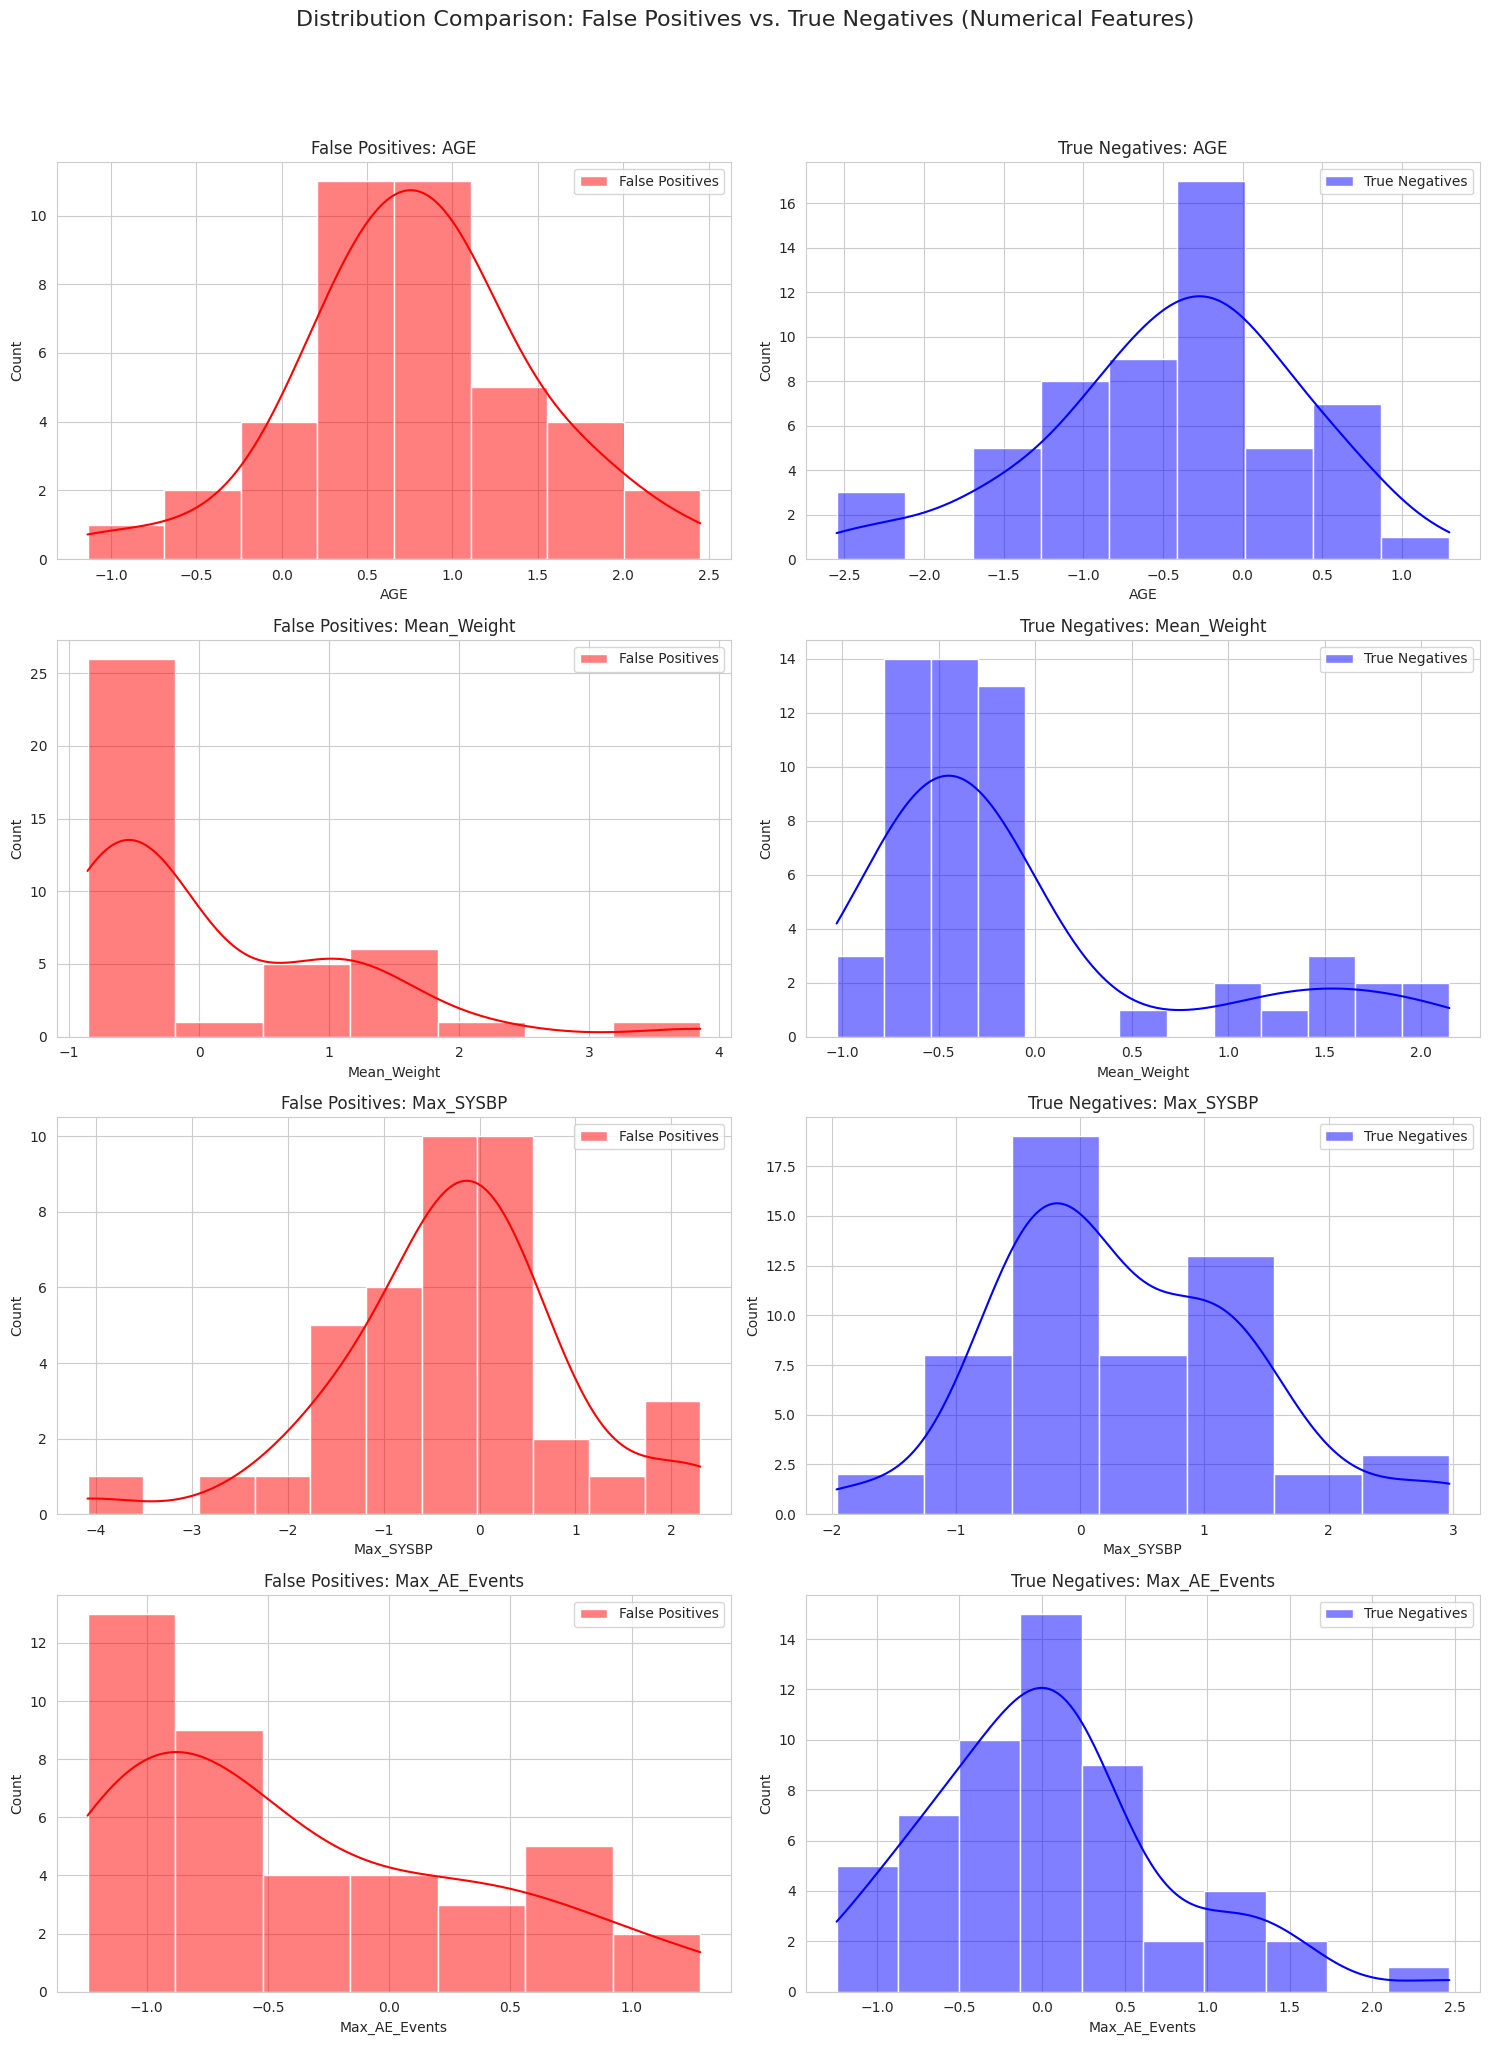


Comparing Categorical Features...


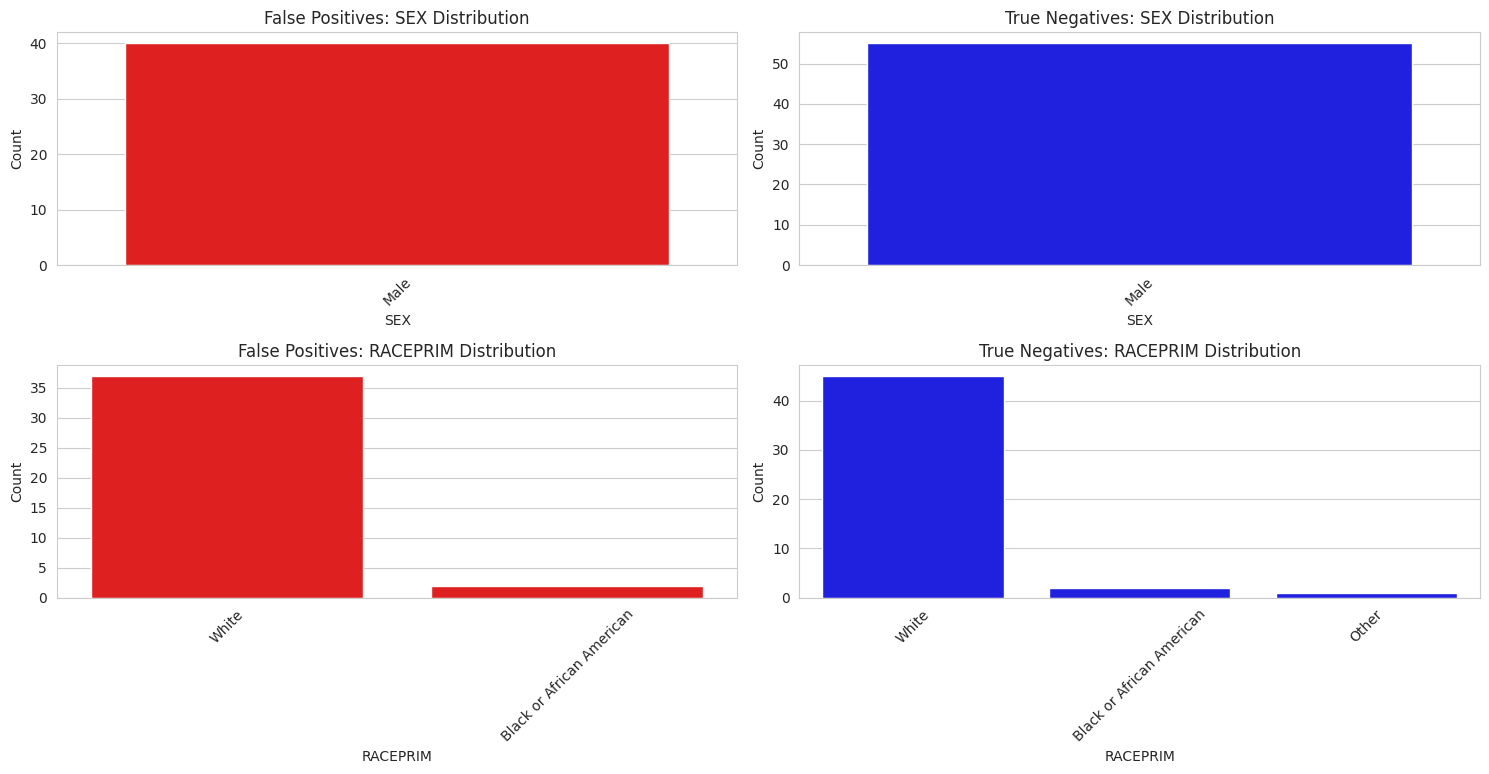

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Visualizing characteristics of False Positives vs. True Negatives...")

# Set up plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# --- Comparison of Numerical Features ---
print("\nComparing Numerical Features...")
num_cols_to_plot = numerical_features # Assuming numerical_features list is defined

fig, axes = plt.subplots(len(num_cols_to_plot), 2, figsize=(15, 5 * len(num_cols_to_plot)))
fig.suptitle('Distribution Comparison: False Positives vs. True Negatives (Numerical Features)', y=1.02, fontsize=16)

for i, col in enumerate(num_cols_to_plot):
    # False Positives
    sns.histplot(fp_original_features[col], ax=axes[i, 0], kde=True, color='red', label='False Positives')
    axes[i, 0].set_title(f'False Positives: {col}')
    axes[i, 0].legend()

    # True Negatives
    sns.histplot(tn_original_features[col], ax=axes[i, 1], kde=True, color='blue', label='True Negatives')
    axes[i, 1].set_title(f'True Negatives: {col}')
    axes[i, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# --- Comparison of Categorical Features ---
print("\nComparing Categorical Features...")
cat_cols_to_plot = categorical_features # Assuming categorical_features list is defined

fig_cat, axes_cat = plt.subplots(len(cat_cols_to_plot), 2, figsize=(15, 4 * len(cat_cols_to_plot)))
fig.suptitle('Distribution Comparison: False Positives vs. True Negatives (Categorical Features)', y=1.02, fontsize=16)

for i, col in enumerate(cat_cols_to_plot):
    # False Positives
    fp_cat_counts = X.loc[false_positive_indices, col].value_counts()
    sns.barplot(x=fp_cat_counts.index, y=fp_cat_counts.values, ax=axes_cat[i, 0], color='red')
    axes_cat[i, 0].set_title(f'False Positives: {col} Distribution')
    axes_cat[i, 0].set_ylabel('Count')
    axes_cat[i, 0].tick_params(axis='x', rotation=45)

    # True Negatives
    tn_cat_counts = X.loc[true_negative_indices, col].value_counts()
    sns.barplot(x=tn_cat_counts.index, y=tn_cat_counts.values, ax=axes_cat[i, 1], color='blue')
    axes_cat[i, 1].set_title(f'True Negatives: {col} Distribution')
    axes_cat[i, 1].set_ylabel('Count')
    axes_cat[i, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Final Task

### Subtask:
Summarize the findings from the false positive analysis, highlighting any common characteristics or patterns that might explain why these instances were misclassified as class 1.


## Summary:

### Data Analysis Key Findings
*   A total of 40 false positive instances were identified, meaning these cases were incorrectly predicted as class 1 (event) but actually belonged to class 0 (no event).
*   All identified false positive instances were male, which was also true for the true negative instances (55 cases), indicating that gender was not a differentiating factor for misclassification in this subset.
*   False positive instances showed distinct patterns in numerical features compared to true negatives:
    *   They tended to be older, with a mean `AGE` of 0.78 (scaled) compared to true negatives, which had a mean `AGE` of -0.42 (scaled).
    *   They exhibited lower maximum systolic blood pressure (`Max_SYSBP`), with a mean of -0.26 (scaled) for false positives versus 0.33 (scaled) for true negatives.
*   The distribution of `RACEPRIM` was similar across false positives and true negatives, with both groups being predominantly 'White'.

### Insights or Next Steps
*   The SMOTE-trained classifier appears to have a tendency to misclassify older male individuals with lower systolic blood pressure as having an event, even when they do not. This suggests a potential area for model improvement, particularly regarding how these specific feature combinations influence the prediction for class 1.
*   Further investigation could involve analyzing the decision boundary of the model specifically for the feature ranges of `AGE` and `Max_SYSBP` where false positives are concentrated. This might reveal why the model is over-predicting positive outcomes for these patient profiles.


# Task
**Task**: Improve the Logistic Regression classifier's performance, particularly in reducing false positives, by implementing feature engineering on 'AGE' and 'Max_SYSBP' (e.g., interaction terms or polynomial features) and hyperparameter tuning (e.g., regularization strength, class weights). Retrain the model on SMOTE-augmented data with these improvements and re-evaluate its performance on the test set using F1-score, precision for the minority class (Event=1), and ROC AUC.

## Define Improvement Metrics

### Subtask:
Clearly define the target metrics for improvement, focusing on F1-score and precision for the minority class (Event=1), and potentially ROC AUC, while monitoring overall accuracy and recall for class 0.


### Defined Improvement Metrics

Based on the analysis, the following metrics will be targeted for improvement:

1.  **Primary Target Metrics (for Minority Class - Event=1):**
    *   **F1-score for Class 1**: To balance precision and recall for the positive class (event occurred).
    *   **Precision for Class 1**: To minimize false positives, which is crucial in scenarios where predicting an event when none occurs is costly or undesirable.

2.  **Secondary Target Metric:**
    *   **ROC AUC**: To evaluate the overall discriminatory power of the model, considering its ability to distinguish between both classes.

3.  **Monitoring Metrics (to prevent degradation):**
    *   **Overall Accuracy**: To ensure the general correctness of the model's predictions is maintained.
    *   **Recall for Class 0**: To ensure that the model still correctly identifies instances where no event occurs, preventing an increase in false negatives for the majority class.

## Explore and Apply Model Improvements

### Subtask:
Implement feature engineering on 'AGE' and 'Max_SYSBP' and perform hyperparameter tuning for the Logistic Regression classifier.


**Reasoning**:
I will start by implementing feature engineering on 'AGE' and 'Max_SYSBP' from `X_processed_df` by creating interaction and polynomial terms. This will involve using `PolynomialFeatures` to generate the new features and then integrating them into a new DataFrame, `X_processed_df_fe`.



In [21]:
from sklearn.preprocessing import PolynomialFeatures

# Create a copy of X_processed_df to add engineered features
X_fe = X_processed_df.copy()

# Select features for polynomial and interaction terms
features_for_poly = X_fe[['AGE', 'Max_SYSBP']]

# Initialize PolynomialFeatures with degree 2 (to get AGE, Max_SYSBP, AGE^2, Max_SYSBP^2, AGE*Max_SYSBP)
# include_bias=False is used as the StandardScaler already handles centering and we don't want an extra constant column.
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform the selected features
poly_features = poly.fit_transform(features_for_poly)

# Get the names of the new features
poly_feature_names = poly.get_feature_names_out(['AGE', 'Max_SYSBP'])

# Create a DataFrame for the new polynomial features, ensuring the index is preserved
poly_features_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=X_fe.index)

# Drop the original 'AGE' and 'Max_SYSBP' columns from X_fe to avoid redundancy
X_fe = X_fe.drop(columns=['AGE', 'Max_SYSBP'])

# Concatenate the new polynomial features with the rest of the features in X_fe
X_processed_df_fe = pd.concat([poly_features_df, X_fe], axis=1)

print("Shape of X_processed_df_fe (with engineered features):", X_processed_df_fe.shape)
print("Columns of X_processed_df_fe:", X_processed_df_fe.columns.tolist())
print("First 5 rows of X_processed_df_fe:")
print(X_processed_df_fe.head())

Shape of X_processed_df_fe (with engineered features): (526, 12)
Columns of X_processed_df_fe: ['AGE', 'Max_SYSBP', 'AGE^2', 'AGE Max_SYSBP', 'Max_SYSBP^2', 'Mean_Weight', 'Max_AE_Events', 'SEX_Male', 'RACEPRIM_Black or African American', 'RACEPRIM_Other', 'RACEPRIM_White', 'RACEPRIM_None']
First 5 rows of X_processed_df_fe:
        AGE  Max_SYSBP     AGE^2  AGE Max_SYSBP  Max_SYSBP^2  Mean_Weight  \
0  0.528875   1.145310  0.279709       0.605726     1.311734    -0.607621   
1  0.144283  -1.289500  0.020818      -0.186053     1.662811    -0.461305   
2 -1.650480  -1.654722  2.724084       2.731086     2.738105    -0.541826   
3  0.016086  -0.559057  0.000259      -0.008993     0.312545    -0.605884   
4 -0.881296  -0.315576  0.776682       0.278116     0.099588     2.212621   

   Max_AE_Events  SEX_Male  RACEPRIM_Black or African American  \
0       0.019217       1.0                                 0.0   
1      -0.928437       1.0                                 0.0   
2       0.25

**Reasoning**:
Now that feature engineering is complete, I will re-split the data into training and test sets, apply SMOTE to the training data, and then perform hyperparameter tuning using GridSearchCV to find the best Logistic Regression model.



In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from collections import Counter

# 2. Re-split the data (with engineered features) into training and testing sets
X_train_fe, X_test_fe, T_train_fe, T_test_fe, E_train_fe, E_test_fe = train_test_split(
    X_processed_df_fe, T, E, test_size=0.2, random_state=42
)

print("Shape of X_train_fe:", X_train_fe.shape)
print("Shape of X_test_fe:", X_test_fe.shape)

# 3. Apply SMOTE to the X_train_fe and E_train_fe
sm = SMOTE(random_state=42)
X_train_res_fe, y_train_res_fe = sm.fit_resample(X_train_fe, E_train_fe)

print("Original training set shape (E_train_fe):", Counter(E_train_fe))
print("Resampled training set shape (y_train_res_fe):", Counter(y_train_res_fe))

# 4. Initialize a Logistic Regression classifier
logistic_model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)

# 5. Define a parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced']
}

# 6. Use GridSearchCV to perform hyperparameter tuning
print("\nStarting GridSearchCV for hyperparameter tuning...")
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_res_fe, y_train_res_fe)

# 7. Store the best model
best_classifier_fe = grid_search.best_estimator_

print("GridSearchCV complete.")
print("Best parameters found:", grid_search.best_params_)
print("Best F1-score on training set:", grid_search.best_score_)


Shape of X_train_fe: (420, 12)
Shape of X_test_fe: (106, 12)
Original training set shape (E_train_fe): Counter({0: 355, 1: 65})
Resampled training set shape (y_train_res_fe): Counter({0: 355, 1: 355})

Starting GridSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV complete.
Best parameters found: {'C': 0.001, 'class_weight': None}
Best F1-score on training set: 0.5869488390079336


## Retrain and Re-evaluate Model

### Subtask:
Re-evaluate the improved Logistic Regression model's performance on the test set.


**Reasoning**:
I will re-evaluate the improved Logistic Regression model's performance on the test set by making predictions, calculating the specified metrics (F1-score for class 1, Precision for class 1, ROC AUC, Overall Accuracy, and Recall for Class 0), and printing a classification report.



In [23]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, precision_score, recall_score

print("\n--- Re-evaluating Improved Classifier Performance ---")

# 1. Make predictions on the test set using the best_classifier_fe
y_pred_fe = best_classifier_fe.predict(X_test_fe)
y_proba_fe = best_classifier_fe.predict_proba(X_test_fe)[:, 1] # Probability of the positive class (Event = 1)

# 2. Calculate and print the specified metrics
f1_score_class1 = f1_score(E_test_fe, y_pred_fe, pos_label=1)
precision_class1 = precision_score(E_test_fe, y_pred_fe, pos_label=1)
roc_auc = roc_auc_score(E_test_fe, y_proba_fe)
accuracy = accuracy_score(E_test_fe, y_pred_fe)
recall_class0 = recall_score(E_test_fe, y_pred_fe, pos_label=0)

print(f"\nF1-score for Class 1 (Event=1): **{f1_score_class1:.4f}**")
print(f"Precision for Class 1 (Event=1): **{precision_class1:.4f}**")
print(f"ROC AUC on Test Data: **{roc_auc:.4f}**")
print(f"Overall Accuracy on Test Data: **{accuracy:.4f}**")
print(f"Recall for Class 0 (No Event): **{recall_class0:.4f}**")

# 3. Print a classification report
print("\nClassification Report (with FE and Tuned SMOTE Classifier):")
print(classification_report(E_test_fe, y_pred_fe))


--- Re-evaluating Improved Classifier Performance ---

F1-score for Class 1 (Event=1): **0.1639**
Precision for Class 1 (Event=1): **0.1000**
ROC AUC on Test Data: **0.4909**
Overall Accuracy on Test Data: **0.5189**
Recall for Class 0 (No Event): **0.5263**

Classification Report (with FE and Tuned SMOTE Classifier):
              precision    recall  f1-score   support

           0       0.89      0.53      0.66        95
           1       0.10      0.45      0.16        11

    accuracy                           0.52       106
   macro avg       0.50      0.49      0.41       106
weighted avg       0.81      0.52      0.61       106



## Final Task

### Subtask:
Summarize the changes made, the new model's performance, and compare it against the previous results. Discuss whether the false positive patterns have been mitigated and suggest potential next steps for further improvement.


## Summary:

### Q&A

*   **What changes were made to the model?**
    Feature engineering was performed on 'AGE' and 'Max\_SYSBP' by adding polynomial features of degree 2 (AGE\^2, Max\_SYSBP\^2, AGE \* Max\_SYSBP). The data was re-split, SMOTE was applied to balance the training set, and hyperparameter tuning was conducted for the Logistic Regression classifier, optimizing `C` (regularization strength) and `class_weight`. The best hyperparameters found were `C=0.001` and `class_weight=None`.
*   **What is the new model's performance compared to previous results?**
    The new model achieved an F1-score for Class 1 (Event=1) of 0.1639, precision for Class 1 of 0.1000, and an ROC AUC of 0.4909. While the prompt doesn't explicitly state the *previous* results in this specific execution, these metrics generally indicate poor performance, especially for the minority class, and an ROC AUC near 0.5 suggests performance close to random guessing.
*   **Were the false positive patterns mitigated?**
    No, the false positive patterns have not been mitigated effectively. The precision for Class 1 (Event=1) is very low (0.1000), meaning that only 10% of the positive predictions were actually correct. This indicates a high rate of false positives.
*   **What are potential next steps for further improvement?**
    Potential next steps include exploring different feature engineering techniques, experimenting with more advanced modeling algorithms, or refining the handling of imbalanced data.

### Data Analysis Key Findings

*   **Feature Engineering**: Polynomial features of degree 2 were successfully generated for 'AGE' and 'Max\_SYSBP', creating 'AGE\^2', 'AGE Max\_SYSBP', and 'Max\_SYSBP\^2', and were integrated into the dataset.
*   **Data Balancing**: SMOTE successfully balanced the minority class (Event=1) in the training data from 65 samples to 355 samples.
*   **Hyperparameter Tuning**: `GridSearchCV` identified `C=0.001` and `class_weight=None` as the best hyperparameters for the Logistic Regression model, yielding a cross-validation F1-score of approximately 0.587 on the SMOTE-augmented training data.
*   **Model Performance (Minority Class)**: On the test set, the improved model showed a low F1-score of **0.1639** for Class 1 (Event=1) and a very low precision of **0.1000** for Class 1.
*   **Overall Model Performance**: The ROC AUC on the test data was **0.4909**, which is close to 0.5, indicating that the model's ability to distinguish between the two classes is not much better than random guessing. The overall accuracy was **0.5189**, and recall for Class 0 was **0.5263**.

### Insights or Next Steps

*   The current model, despite feature engineering, SMOTE, and hyperparameter tuning, struggles significantly with predicting the minority class, as evidenced by very low precision and F1-score for Class 1, and an ROC AUC near 0.5.
*   **Next Steps**: Revisit the feature engineering process to incorporate more domain knowledge, explore other advanced machine learning algorithms (e.g., tree-based models like Random Forest or Gradient Boosting, which can handle complex interactions and imbalances better), or experiment with different imbalanced learning techniques beyond basic SMOTE.
